In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import argparse
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from trainer import Trainer
from utils import Logger
from utils import util
from utils import torchsummary
from utils import viewTraining
from utils import lr_finder
from utils import classActivationMap
import importlib
import math
import torchvision
from torch.nn import functional as F
from torch import topk
import skimage.transform
print("Modules loaded")

importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(module_arch)
importlib.reload(module_loss)
importlib.reload(module_metric)
importlib.reload(util)
importlib.reload(viewTraining)
importlib.reload(lr_finder)
importlib.reload(classActivationMap)
print("Reload complete")

print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Modules loaded
Reload complete
GPUs available: 1


In [2]:
resplit_data = False
if resplit_data:
    os.system('python3 utils/splitDataFolder.py -r "data/debug_dataset/" -c "data/debug_dataset/Label_all.csv" -s 0.15')
    
print("fin")

fin


In [2]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

def set_instance(module, name, config, *args):
    setattr(module, config[name]['type'])(*args, **config[name]['args'])

def main(config, resume):
    train_logger = Logger() #uses entries to store training performance metrics
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
    print("Total number of training images = " + str(data_loader.dataset.data_len))
    valid_data_loader = data_loader.split_validation() #allocate some images as validation

    # build model architecture
    model = get_instance(module_arch, 'arch', config) #looks in the model/model.py for 'MnistModel', as specified by config
    print(model)
    torchsummary.summary(model, (1,64,64))
     
    
    if torch.cuda.is_available():
        print("Using GPU: " + torch.cuda.get_device_name(0))
    else:
        print("Using CPU to train")
    
    normalized = False
    util.visualizeBatch(data_loader, normalized)
    
    
    # get function handles of loss and metrics
    loss = getattr(module_loss, config['loss']) #looks in model/loss.py for criterion function specified in config
    criterion = loss(data_loader.dataset.weight.to(device)) # for imbalanced datasets
    print(data_loader.dataset.weight)
    metrics = [getattr(module_metric, met) for met in config['metrics']] #get all the metrics in model/metrics.py - default is accuracy and top 3 accuracy

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters()) #Number of training params
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
    lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

    
    trainer = Trainer(model, criterion, metrics, optimizer,
                      resume=resume, #choose a previous epoch to start training from
                      config=config,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler,
                      train_logger=train_logger)
    
    
    findLR = False
    if findLR:
        #set lr = 1e-7 in config file 
        device_lr = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        lr_finder_training = lr_finder.LRFinder(model, optimizer, criterion, device=device_lr)
        lr_finder_training.range_test(data_loader, end_lr=1, num_iter=100, val_loader = valid_data_loader)
        lr_finder_training.plot(skip_start = 10, skip_end=5)
        # trim the first 10 and last 5 iteration from calculating loss (num_iter > skip_start + skip_end)
    else:
        trainer.train()
        a=1
    
 

In [3]:
config_file = 'configs/config_ManyEpochs.json'

# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

Total number of training images = 1749
heatmapModel64(
  (layer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (15): Conv2d(256, 512, k

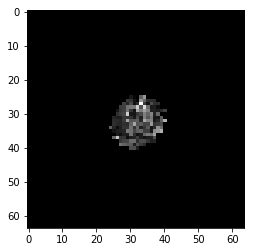

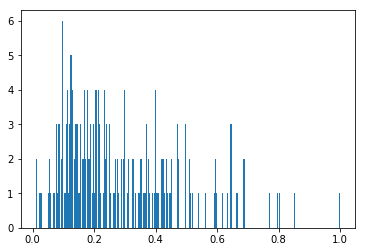

tensor([1.0000, 1.0456])


Train Epoch: 1 [0/1487 (0%)] Loss: 1.057999
Train Epoch: 1 [128/1487 (8%)] Loss: 2.661305
Train Epoch: 1 [256/1487 (17%)] Loss: 0.821106
Train Epoch: 1 [384/1487 (25%)] Loss: 1.436572
Train Epoch: 1 [512/1487 (33%)] Loss: 1.342657
Train Epoch: 1 [640/1487 (42%)] Loss: 0.987916
Train Epoch: 1 [768/1487 (50%)] Loss: 0.877633
Train Epoch: 1 [896/1487 (58%)] Loss: 0.738987
Train Epoch: 1 [1024/1487 (67%)] Loss: 0.749488
Train Epoch: 1 [1152/1487 (75%)] Loss: 0.645113
Train Epoch: 1 [1280/1487 (83%)] Loss: 0.687814
Train Epoch: 1 [1408/1487 (92%)] Loss: 0.668674
    epoch          : 1
    loss           : 1.0517829259236653
    my_metric      : 0.6366319444444445
    f1             : 0.6123025164742444
    balanced_accuracy: 0.6333631583416527
    precision      : 0.6765897446148909
    recall         : 0.6366319444444445
    val_loss       : 0.49896813929080963
    val_my_metric  : 0.7625
    val_f1         : 0.7619671803292494
    val_balanced_accuracy: 0.7628310979817147
    val_precisio

Model has not improved in -------------| 1 epochs


Train Epoch: 3 [0/1487 (0%)] Loss: 0.667461
Train Epoch: 3 [128/1487 (8%)] Loss: 0.556841
Train Epoch: 3 [256/1487 (17%)] Loss: 0.822389
Train Epoch: 3 [384/1487 (25%)] Loss: 0.741976
Train Epoch: 3 [512/1487 (33%)] Loss: 0.498790
Train Epoch: 3 [640/1487 (42%)] Loss: 0.570686
Train Epoch: 3 [768/1487 (50%)] Loss: 0.516877
Train Epoch: 3 [896/1487 (58%)] Loss: 0.718491
Train Epoch: 3 [1024/1487 (67%)] Loss: 0.620836
Train Epoch: 3 [1152/1487 (75%)] Loss: 0.533120
Train Epoch: 3 [1280/1487 (83%)] Loss: 0.513085
Train Epoch: 3 [1408/1487 (92%)] Loss: 0.578538
    epoch          : 3
    loss           : 0.5750988436241945
    my_metric      : 0.7371093750000001
    f1             : 0.7325973571475842
    balanced_accuracy: 0.7390204342109968
    precision      : 0.762202880198357
    recall         : 0.7371093750000001
    val_loss       : 0.5446585059165955
    val_my_metric  : 0.7145833333333333
    val_f1         : 0.7114343344741042
    val_balanced_accuracy: 0.7246684792791578
    va

Model has not improved in -------------| 2 epochs


Train Epoch: 4 [0/1487 (0%)] Loss: 0.470358
Train Epoch: 4 [128/1487 (8%)] Loss: 0.662755
Train Epoch: 4 [256/1487 (17%)] Loss: 0.538777
Train Epoch: 4 [384/1487 (25%)] Loss: 0.562594
Train Epoch: 4 [512/1487 (33%)] Loss: 0.538318
Train Epoch: 4 [640/1487 (42%)] Loss: 0.550359
Train Epoch: 4 [768/1487 (50%)] Loss: 0.591576
Train Epoch: 4 [896/1487 (58%)] Loss: 0.471022
Train Epoch: 4 [1024/1487 (67%)] Loss: 0.736862
Train Epoch: 4 [1152/1487 (75%)] Loss: 0.530117
Train Epoch: 4 [1280/1487 (83%)] Loss: 0.555449
Train Epoch: 4 [1408/1487 (92%)] Loss: 0.534796
    epoch          : 4
    loss           : 0.5642117423315843
    my_metric      : 0.7309461805555556
    f1             : 0.7285566061295818
    balanced_accuracy: 0.7327479503764032
    precision      : 0.7434927558381487
    recall         : 0.7309461805555556
    val_loss       : 0.5677498996257782
    val_my_metric  : 0.7270833333333333
    val_f1         : 0.7175769528459157
    val_balanced_accuracy: 0.7250554884710483
    v

Model has not improved in -------------| 3 epochs


Train Epoch: 5 [0/1487 (0%)] Loss: 0.635572
Train Epoch: 5 [128/1487 (8%)] Loss: 0.584107
Train Epoch: 5 [256/1487 (17%)] Loss: 0.465347
Train Epoch: 5 [384/1487 (25%)] Loss: 0.544361
Train Epoch: 5 [512/1487 (33%)] Loss: 0.505789
Train Epoch: 5 [640/1487 (42%)] Loss: 0.486096
Train Epoch: 5 [768/1487 (50%)] Loss: 0.495687
Train Epoch: 5 [896/1487 (58%)] Loss: 0.583851
Train Epoch: 5 [1024/1487 (67%)] Loss: 0.527378
Train Epoch: 5 [1152/1487 (75%)] Loss: 0.415868
Train Epoch: 5 [1280/1487 (83%)] Loss: 0.457920
Train Epoch: 5 [1408/1487 (92%)] Loss: 0.511941
    epoch          : 5
    loss           : 0.5403617694973946
    my_metric      : 0.7444010416666668
    f1             : 0.7456849898533666
    balanced_accuracy: 0.7472831135012717
    precision      : 0.757183765140903
    recall         : 0.7444010416666668
    val_loss       : 0.5149811685085297
    val_my_metric  : 0.7729166666666667
    val_f1         : 0.7715144232792625
    val_balanced_accuracy: 0.7755397753075772
    va

Model has not improved in -------------| 4 epochs


Train Epoch: 6 [0/1487 (0%)] Loss: 0.421736
Train Epoch: 6 [128/1487 (8%)] Loss: 0.499535
Train Epoch: 6 [256/1487 (17%)] Loss: 0.553976
Train Epoch: 6 [384/1487 (25%)] Loss: 0.482828
Train Epoch: 6 [512/1487 (33%)] Loss: 0.497294
Train Epoch: 6 [640/1487 (42%)] Loss: 0.570043
Train Epoch: 6 [768/1487 (50%)] Loss: 0.477766
Train Epoch: 6 [896/1487 (58%)] Loss: 0.641777
Train Epoch: 6 [1024/1487 (67%)] Loss: 0.553240
Train Epoch: 6 [1152/1487 (75%)] Loss: 0.411616
Train Epoch: 6 [1280/1487 (83%)] Loss: 0.436163
Train Epoch: 6 [1408/1487 (92%)] Loss: 0.466993
    epoch          : 6
    loss           : 0.5266267371674379
    my_metric      : 0.7455729166666667
    f1             : 0.7444518170245887
    balanced_accuracy: 0.7428797629668126
    precision      : 0.753594285943624
    recall         : 0.7455729166666667
    val_loss       : 0.5382041931152344
    val_my_metric  : 0.7020833333333333
    val_f1         : 0.7014244767037952
    val_balanced_accuracy: 0.6944057881773399
    va

Model has not improved in -------------| 5 epochs


Train Epoch: 7 [0/1487 (0%)] Loss: 0.397572
Train Epoch: 7 [128/1487 (8%)] Loss: 0.582828
Train Epoch: 7 [256/1487 (17%)] Loss: 0.396826
Train Epoch: 7 [384/1487 (25%)] Loss: 0.489471
Train Epoch: 7 [512/1487 (33%)] Loss: 0.392550
Train Epoch: 7 [640/1487 (42%)] Loss: 0.585034
Train Epoch: 7 [768/1487 (50%)] Loss: 0.521077
Train Epoch: 7 [896/1487 (58%)] Loss: 0.530127
Train Epoch: 7 [1024/1487 (67%)] Loss: 0.517150
Train Epoch: 7 [1152/1487 (75%)] Loss: 0.529326
Train Epoch: 7 [1280/1487 (83%)] Loss: 0.530294
Train Epoch: 7 [1408/1487 (92%)] Loss: 0.475440
    epoch          : 7
    loss           : 0.5266516904036204
    my_metric      : 0.7408420138888889
    f1             : 0.7409304203742879
    balanced_accuracy: 0.7439580164088114
    precision      : 0.7530697431534702
    recall         : 0.7408420138888889
    val_loss       : 0.5085096895694733
    val_my_metric  : 0.7510416666666667
    val_f1         : 0.7488406245807429
    val_balanced_accuracy: 0.7519004082571445
    v

Model has not improved in -------------| 6 epochs


Train Epoch: 8 [0/1487 (0%)] Loss: 0.451460
Train Epoch: 8 [128/1487 (8%)] Loss: 0.487021
Train Epoch: 8 [256/1487 (17%)] Loss: 0.746397
Train Epoch: 8 [384/1487 (25%)] Loss: 0.537173
Train Epoch: 8 [512/1487 (33%)] Loss: 0.471618
Train Epoch: 8 [640/1487 (42%)] Loss: 0.479038
Train Epoch: 8 [768/1487 (50%)] Loss: 0.449771
Train Epoch: 8 [896/1487 (58%)] Loss: 0.516595
Train Epoch: 8 [1024/1487 (67%)] Loss: 0.513147
Train Epoch: 8 [1152/1487 (75%)] Loss: 0.556423
Train Epoch: 8 [1280/1487 (83%)] Loss: 0.504159
Train Epoch: 8 [1408/1487 (92%)] Loss: 0.564336
    epoch          : 8
    loss           : 0.5402028672397137
    my_metric      : 0.7303819444444444
    f1             : 0.7259718780179781
    balanced_accuracy: 0.7276362549131461
    precision      : 0.7443844052645842
    recall         : 0.7303819444444444
    val_loss       : 0.5249651670455933
    val_my_metric  : 0.7458333333333333
    val_f1         : 0.7447522022021
    val_balanced_accuracy: 0.7368482768482769
    val_

Model has not improved in -------------| 7 epochs


Train Epoch: 9 [0/1487 (0%)] Loss: 0.508775
Train Epoch: 9 [128/1487 (8%)] Loss: 0.478469
Train Epoch: 9 [256/1487 (17%)] Loss: 0.461972
Train Epoch: 9 [384/1487 (25%)] Loss: 0.388485
Train Epoch: 9 [512/1487 (33%)] Loss: 0.614387
Train Epoch: 9 [640/1487 (42%)] Loss: 0.601600
Train Epoch: 9 [768/1487 (50%)] Loss: 0.464078
Train Epoch: 9 [896/1487 (58%)] Loss: 0.634804
Train Epoch: 9 [1024/1487 (67%)] Loss: 0.420254
Train Epoch: 9 [1152/1487 (75%)] Loss: 0.465194
Train Epoch: 9 [1280/1487 (83%)] Loss: 0.599656
Train Epoch: 9 [1408/1487 (92%)] Loss: 0.567645
    epoch          : 9
    loss           : 0.5366223392387232
    my_metric      : 0.7458767361111112
    f1             : 0.744994127957355
    balanced_accuracy: 0.7485175089308506
    precision      : 0.7621118109597758
    recall         : 0.7458767361111112
    val_loss       : 0.5742302179336548
    val_my_metric  : 0.7083333333333333
    val_f1         : 0.7058765295875593
    val_balanced_accuracy: 0.7119851962762386
    va

Model has not improved in -------------| 8 epochs


Train Epoch: 10 [0/1487 (0%)] Loss: 0.587618
Train Epoch: 10 [128/1487 (8%)] Loss: 0.482532
Train Epoch: 10 [256/1487 (17%)] Loss: 0.500213
Train Epoch: 10 [384/1487 (25%)] Loss: 0.510746
Train Epoch: 10 [512/1487 (33%)] Loss: 0.429811
Train Epoch: 10 [640/1487 (42%)] Loss: 0.513124
Train Epoch: 10 [768/1487 (50%)] Loss: 0.478508
Train Epoch: 10 [896/1487 (58%)] Loss: 0.493341
Train Epoch: 10 [1024/1487 (67%)] Loss: 0.470532
Train Epoch: 10 [1152/1487 (75%)] Loss: 0.600322
Train Epoch: 10 [1280/1487 (83%)] Loss: 0.477919
Train Epoch: 10 [1408/1487 (92%)] Loss: 0.452579
    epoch          : 10
    loss           : 0.5173371223111948
    my_metric      : 0.7470052083333334
    f1             : 0.7452413896704262
    balanced_accuracy: 0.7459550313630565
    precision      : 0.7590080870957783
    recall         : 0.7470052083333334
    val_loss       : 0.5221787631511688
    val_my_metric  : 0.7354166666666667
    val_f1         : 0.7378650146795694
    val_balanced_accuracy: 0.745286137

Model has not improved in -------------| 9 epochs


Train Epoch: 11 [0/1487 (0%)] Loss: 0.442417
Train Epoch: 11 [128/1487 (8%)] Loss: 0.592045
Train Epoch: 11 [256/1487 (17%)] Loss: 0.558339
Train Epoch: 11 [384/1487 (25%)] Loss: 0.630246
Train Epoch: 11 [512/1487 (33%)] Loss: 0.397759
Train Epoch: 11 [640/1487 (42%)] Loss: 0.489692
Train Epoch: 11 [768/1487 (50%)] Loss: 0.516758
Train Epoch: 11 [896/1487 (58%)] Loss: 0.483624
Train Epoch: 11 [1024/1487 (67%)] Loss: 0.450863
Train Epoch: 11 [1152/1487 (75%)] Loss: 0.558098
Train Epoch: 11 [1280/1487 (83%)] Loss: 0.474737
Train Epoch: 11 [1408/1487 (92%)] Loss: 0.446979
    epoch          : 11
    loss           : 0.5127205861111482
    my_metric      : 0.7404947916666668
    f1             : 0.7387439706193666
    balanced_accuracy: 0.7420962542865502
    precision      : 0.7540248148943508
    recall         : 0.7404947916666668
    val_loss       : 0.47734191417694094
    val_my_metric  : 0.796875
    val_f1         : 0.7963165160597099
    val_balanced_accuracy: 0.7952122169527129
 

Model has not improved in -------------| 1 epochs


Train Epoch: 13 [0/1487 (0%)] Loss: 0.493438
Train Epoch: 13 [128/1487 (8%)] Loss: 0.477325
Train Epoch: 13 [256/1487 (17%)] Loss: 0.466464
Train Epoch: 13 [384/1487 (25%)] Loss: 0.607369
Train Epoch: 13 [512/1487 (33%)] Loss: 0.568077
Train Epoch: 13 [640/1487 (42%)] Loss: 0.454986
Train Epoch: 13 [768/1487 (50%)] Loss: 0.435036
Train Epoch: 13 [896/1487 (58%)] Loss: 0.474807
Train Epoch: 13 [1024/1487 (67%)] Loss: 0.561005
Train Epoch: 13 [1152/1487 (75%)] Loss: 0.578079
Train Epoch: 13 [1280/1487 (83%)] Loss: 0.440493
Train Epoch: 13 [1408/1487 (92%)] Loss: 0.541256
    epoch          : 13
    loss           : 0.5130100299914678
    my_metric      : 0.7588975694444445
    f1             : 0.7591179407942824
    balanced_accuracy: 0.7602002702947793
    precision      : 0.766181498315199
    recall         : 0.7588975694444445
    val_loss       : 0.5887934446334839
    val_my_metric  : 0.7395833333333333
    val_f1         : 0.7345028989475458
    val_balanced_accuracy: 0.7257780777

Model has not improved in -------------| 2 epochs


Train Epoch: 14 [0/1487 (0%)] Loss: 0.579314
Train Epoch: 14 [128/1487 (8%)] Loss: 0.576646
Train Epoch: 14 [256/1487 (17%)] Loss: 0.618408
Train Epoch: 14 [384/1487 (25%)] Loss: 0.499639
Train Epoch: 14 [512/1487 (33%)] Loss: 0.489266
Train Epoch: 14 [640/1487 (42%)] Loss: 0.476557
Train Epoch: 14 [768/1487 (50%)] Loss: 0.498189
Train Epoch: 14 [896/1487 (58%)] Loss: 0.466655
Train Epoch: 14 [1024/1487 (67%)] Loss: 0.433129
Train Epoch: 14 [1152/1487 (75%)] Loss: 0.675825
Train Epoch: 14 [1280/1487 (83%)] Loss: 0.448959
Train Epoch: 14 [1408/1487 (92%)] Loss: 0.697973
    epoch          : 14
    loss           : 0.5108192885915438
    my_metric      : 0.7429687500000001
    f1             : 0.74285751654965
    balanced_accuracy: 0.7461087690868363
    precision      : 0.7568966241083821
    recall         : 0.7429687500000001
    val_loss       : 0.6245661973953247
    val_my_metric  : 0.6760416666666667
    val_f1         : 0.6731841833711595
    val_balanced_accuracy: 0.66997705446

Model has not improved in -------------| 3 epochs


Train Epoch: 15 [0/1487 (0%)] Loss: 0.521214
Train Epoch: 15 [128/1487 (8%)] Loss: 0.436924
Train Epoch: 15 [256/1487 (17%)] Loss: 0.529087
Train Epoch: 15 [384/1487 (25%)] Loss: 0.445753
Train Epoch: 15 [512/1487 (33%)] Loss: 0.439245
Train Epoch: 15 [640/1487 (42%)] Loss: 0.587918
Train Epoch: 15 [768/1487 (50%)] Loss: 0.515548
Train Epoch: 15 [896/1487 (58%)] Loss: 0.525562
Train Epoch: 15 [1024/1487 (67%)] Loss: 0.531316
Train Epoch: 15 [1152/1487 (75%)] Loss: 0.553189
Train Epoch: 15 [1280/1487 (83%)] Loss: 0.467050
Train Epoch: 15 [1408/1487 (92%)] Loss: 0.495602
    epoch          : 15
    loss           : 0.5055079199373722
    my_metric      : 0.7531684027777777
    f1             : 0.7527953418138934
    balanced_accuracy: 0.7563169374874361
    precision      : 0.763425609275533
    recall         : 0.7531684027777777
    val_loss       : 0.47698056101799013
    val_my_metric  : 0.803125
    val_f1         : 0.8023603247665114
    val_balanced_accuracy: 0.8032192657121499
  

Model has not improved in -------------| 1 epochs


Train Epoch: 17 [0/1487 (0%)] Loss: 0.577793
Train Epoch: 17 [128/1487 (8%)] Loss: 0.459420
Train Epoch: 17 [256/1487 (17%)] Loss: 0.540774
Train Epoch: 17 [384/1487 (25%)] Loss: 0.612307
Train Epoch: 17 [512/1487 (33%)] Loss: 0.535514
Train Epoch: 17 [640/1487 (42%)] Loss: 0.537837
Train Epoch: 17 [768/1487 (50%)] Loss: 0.481919
Train Epoch: 17 [896/1487 (58%)] Loss: 0.586950
Train Epoch: 17 [1024/1487 (67%)] Loss: 0.417335
Train Epoch: 17 [1152/1487 (75%)] Loss: 0.551614
Train Epoch: 17 [1280/1487 (83%)] Loss: 0.414949
Train Epoch: 17 [1408/1487 (92%)] Loss: 0.484463
    epoch          : 17
    loss           : 0.49641059959928197
    my_metric      : 0.7587239583333334
    f1             : 0.7584727393040384
    balanced_accuracy: 0.7634772730360191
    precision      : 0.7723863004837478
    recall         : 0.7587239583333334
    val_loss       : 0.5037293255329132
    val_my_metric  : 0.7572916666666667
    val_f1         : 0.7537062939583218
    val_balanced_accuracy: 0.75502753

Model has not improved in -------------| 2 epochs


Train Epoch: 18 [0/1487 (0%)] Loss: 0.517211
Train Epoch: 18 [128/1487 (8%)] Loss: 0.531245
Train Epoch: 18 [256/1487 (17%)] Loss: 0.513302
Train Epoch: 18 [384/1487 (25%)] Loss: 0.421230
Train Epoch: 18 [512/1487 (33%)] Loss: 0.478238
Train Epoch: 18 [640/1487 (42%)] Loss: 0.513033
Train Epoch: 18 [768/1487 (50%)] Loss: 0.450715
Train Epoch: 18 [896/1487 (58%)] Loss: 0.438709
Train Epoch: 18 [1024/1487 (67%)] Loss: 0.653302
Train Epoch: 18 [1152/1487 (75%)] Loss: 0.467093
Train Epoch: 18 [1280/1487 (83%)] Loss: 0.504056
Train Epoch: 18 [1408/1487 (92%)] Loss: 0.422220
    epoch          : 18
    loss           : 0.48999281600117683
    my_metric      : 0.7716145833333333
    f1             : 0.771679878796892
    balanced_accuracy: 0.7729118849428813
    precision      : 0.7788681167592523
    recall         : 0.7716145833333333
    val_loss       : 0.5371276319026947
    val_my_metric  : 0.7395833333333333
    val_f1         : 0.739861397663345
    val_balanced_accuracy: 0.7561152795

Model has not improved in -------------| 3 epochs


Train Epoch: 19 [0/1487 (0%)] Loss: 0.422322
Train Epoch: 19 [128/1487 (8%)] Loss: 0.607154
Train Epoch: 19 [256/1487 (17%)] Loss: 0.531139
Train Epoch: 19 [384/1487 (25%)] Loss: 0.538846
Train Epoch: 19 [512/1487 (33%)] Loss: 0.472129
Train Epoch: 19 [640/1487 (42%)] Loss: 0.432312
Train Epoch: 19 [768/1487 (50%)] Loss: 0.419964
Train Epoch: 19 [896/1487 (58%)] Loss: 0.505679
Train Epoch: 19 [1024/1487 (67%)] Loss: 0.481099
Train Epoch: 19 [1152/1487 (75%)] Loss: 0.381276
Train Epoch: 19 [1280/1487 (83%)] Loss: 0.436310
Train Epoch: 19 [1408/1487 (92%)] Loss: 0.476136
    epoch          : 19
    loss           : 0.48883989950021106
    my_metric      : 0.7717881944444445
    f1             : 0.7716721712422648
    balanced_accuracy: 0.7737387185504826
    precision      : 0.7790862597578491
    recall         : 0.7717881944444445
    val_loss       : 0.5285691082477569
    val_my_metric  : 0.7552083333333333
    val_f1         : 0.7511251325369245
    val_balanced_accuracy: 0.76796487

Model has not improved in -------------| 4 epochs


Train Epoch: 20 [0/1487 (0%)] Loss: 0.487235
Train Epoch: 20 [128/1487 (8%)] Loss: 0.570840
Train Epoch: 20 [256/1487 (17%)] Loss: 0.474343
Train Epoch: 20 [384/1487 (25%)] Loss: 0.520635
Train Epoch: 20 [512/1487 (33%)] Loss: 0.546988
Train Epoch: 20 [640/1487 (42%)] Loss: 0.498306
Train Epoch: 20 [768/1487 (50%)] Loss: 0.462056
Train Epoch: 20 [896/1487 (58%)] Loss: 0.590651
Train Epoch: 20 [1024/1487 (67%)] Loss: 0.603839
Train Epoch: 20 [1152/1487 (75%)] Loss: 0.505108
Train Epoch: 20 [1280/1487 (83%)] Loss: 0.371464
Train Epoch: 20 [1408/1487 (92%)] Loss: 0.380967
    epoch          : 20
    loss           : 0.4850924586256345
    my_metric      : 0.7726128472222222
    f1             : 0.7721414309137971
    balanced_accuracy: 0.7742097346515174
    precision      : 0.780786813337717
    recall         : 0.7726128472222222
    val_loss       : 0.5388839960098266
    val_my_metric  : 0.715625
    val_f1         : 0.7116908063201658
    val_balanced_accuracy: 0.7155129557131781
   

Model has not improved in -------------| 5 epochs


Train Epoch: 21 [0/1487 (0%)] Loss: 0.451917
Train Epoch: 21 [128/1487 (8%)] Loss: 0.514063
Train Epoch: 21 [256/1487 (17%)] Loss: 0.453569
Train Epoch: 21 [384/1487 (25%)] Loss: 0.534299
Train Epoch: 21 [512/1487 (33%)] Loss: 0.392682
Train Epoch: 21 [640/1487 (42%)] Loss: 0.403266
Train Epoch: 21 [768/1487 (50%)] Loss: 0.509876
Train Epoch: 21 [896/1487 (58%)] Loss: 0.407306
Train Epoch: 21 [1024/1487 (67%)] Loss: 0.468249
Train Epoch: 21 [1152/1487 (75%)] Loss: 0.543478
Train Epoch: 21 [1280/1487 (83%)] Loss: 0.542169
Train Epoch: 21 [1408/1487 (92%)] Loss: 0.515080
    epoch          : 21
    loss           : 0.4811750625570615
    my_metric      : 0.773046875
    f1             : 0.7724592733619953
    balanced_accuracy: 0.7733835519191232
    precision      : 0.7813132578828895
    recall         : 0.773046875
    val_loss       : 0.47138512134552
    val_my_metric  : 0.803125
    val_f1         : 0.8021151714785291
    val_balanced_accuracy: 0.8104396098278188
    val_precision 

Model has not improved in -------------| 1 epochs


Train Epoch: 23 [0/1487 (0%)] Loss: 0.605320
Train Epoch: 23 [128/1487 (8%)] Loss: 0.532338
Train Epoch: 23 [256/1487 (17%)] Loss: 0.415308
Train Epoch: 23 [384/1487 (25%)] Loss: 0.441897
Train Epoch: 23 [512/1487 (33%)] Loss: 0.552750
Train Epoch: 23 [640/1487 (42%)] Loss: 0.478532
Train Epoch: 23 [768/1487 (50%)] Loss: 0.488451
Train Epoch: 23 [896/1487 (58%)] Loss: 0.449609
Train Epoch: 23 [1024/1487 (67%)] Loss: 0.508692
Train Epoch: 23 [1152/1487 (75%)] Loss: 0.557986
Train Epoch: 23 [1280/1487 (83%)] Loss: 0.496051
Train Epoch: 23 [1408/1487 (92%)] Loss: 0.457158
    epoch          : 23
    loss           : 0.485354695469141
    my_metric      : 0.7727430555555556
    f1             : 0.7718272612987261
    balanced_accuracy: 0.7737130613647606
    precision      : 0.7830366954015343
    recall         : 0.7727430555555556
    val_loss       : 0.5072550237178802
    val_my_metric  : 0.7760416666666667
    val_f1         : 0.7775603241974172
    val_balanced_accuracy: 0.7840500031

Model has not improved in -------------| 2 epochs


Train Epoch: 24 [0/1487 (0%)] Loss: 0.546024
Train Epoch: 24 [128/1487 (8%)] Loss: 0.520182
Train Epoch: 24 [256/1487 (17%)] Loss: 0.470145
Train Epoch: 24 [384/1487 (25%)] Loss: 0.617173
Train Epoch: 24 [512/1487 (33%)] Loss: 0.546903
Train Epoch: 24 [640/1487 (42%)] Loss: 0.548581
Train Epoch: 24 [768/1487 (50%)] Loss: 0.413150
Train Epoch: 24 [896/1487 (58%)] Loss: 0.503422
Train Epoch: 24 [1024/1487 (67%)] Loss: 0.520013
Train Epoch: 24 [1152/1487 (75%)] Loss: 0.460205
Train Epoch: 24 [1280/1487 (83%)] Loss: 0.424219
Train Epoch: 24 [1408/1487 (92%)] Loss: 0.409296
    epoch          : 24
    loss           : 0.500004667788744
    my_metric      : 0.75546875
    f1             : 0.7559082716235985
    balanced_accuracy: 0.7601898024567548
    precision      : 0.766957558277066
    recall         : 0.75546875
    val_loss       : 0.45044560432434083
    val_my_metric  : 0.8
    val_f1         : 0.7999511241446726
    val_balanced_accuracy: 0.7991179071824233
    val_precision  : 0.8

Model has not improved in -------------| 1 epochs


Train Epoch: 26 [0/1487 (0%)] Loss: 0.487010
Train Epoch: 26 [128/1487 (8%)] Loss: 0.369217
Train Epoch: 26 [256/1487 (17%)] Loss: 0.542225
Train Epoch: 26 [384/1487 (25%)] Loss: 0.547671
Train Epoch: 26 [512/1487 (33%)] Loss: 0.449217
Train Epoch: 26 [640/1487 (42%)] Loss: 0.523419
Train Epoch: 26 [768/1487 (50%)] Loss: 0.412062
Train Epoch: 26 [896/1487 (58%)] Loss: 0.464403
Train Epoch: 26 [1024/1487 (67%)] Loss: 0.423823
Train Epoch: 26 [1152/1487 (75%)] Loss: 0.528649
Train Epoch: 26 [1280/1487 (83%)] Loss: 0.457931
Train Epoch: 26 [1408/1487 (92%)] Loss: 0.438590
    epoch          : 26
    loss           : 0.48648955672979355
    my_metric      : 0.7618489583333333
    f1             : 0.7603325551338672
    balanced_accuracy: 0.7647374219517457
    precision      : 0.7772042623919183
    recall         : 0.7618489583333333
    val_loss       : 0.48861864805221555
    val_my_metric  : 0.803125
    val_f1         : 0.8029848857208652
    val_balanced_accuracy: 0.8018503483909492


Model has not improved in -------------| 2 epochs


Train Epoch: 27 [0/1487 (0%)] Loss: 0.522654
Train Epoch: 27 [128/1487 (8%)] Loss: 0.431575
Train Epoch: 27 [256/1487 (17%)] Loss: 0.579631
Train Epoch: 27 [384/1487 (25%)] Loss: 0.468257
Train Epoch: 27 [512/1487 (33%)] Loss: 0.493352
Train Epoch: 27 [640/1487 (42%)] Loss: 0.394349
Train Epoch: 27 [768/1487 (50%)] Loss: 0.397285
Train Epoch: 27 [896/1487 (58%)] Loss: 0.625690
Train Epoch: 27 [1024/1487 (67%)] Loss: 0.493810
Train Epoch: 27 [1152/1487 (75%)] Loss: 0.460871
Train Epoch: 27 [1280/1487 (83%)] Loss: 0.610876
Train Epoch: 27 [1408/1487 (92%)] Loss: 0.377134
    epoch          : 27
    loss           : 0.48254596441984177
    my_metric      : 0.7694878472222223
    f1             : 0.7664718180971669
    balanced_accuracy: 0.7715447522052458
    precision      : 0.7904592073218648
    recall         : 0.7694878472222223
    val_loss       : 0.6074790835380555
    val_my_metric  : 0.6927083333333333
    val_f1         : 0.695456284197257
    val_balanced_accuracy: 0.721149155

Model has not improved in -------------| 3 epochs


Train Epoch: 28 [0/1487 (0%)] Loss: 0.600673
Train Epoch: 28 [128/1487 (8%)] Loss: 0.462112
Train Epoch: 28 [256/1487 (17%)] Loss: 0.421289
Train Epoch: 28 [384/1487 (25%)] Loss: 0.444488
Train Epoch: 28 [512/1487 (33%)] Loss: 0.533307
Train Epoch: 28 [640/1487 (42%)] Loss: 0.423423
Train Epoch: 28 [768/1487 (50%)] Loss: 0.385483
Train Epoch: 28 [896/1487 (58%)] Loss: 0.460055
Train Epoch: 28 [1024/1487 (67%)] Loss: 0.474627
Train Epoch: 28 [1152/1487 (75%)] Loss: 0.445121
Train Epoch: 28 [1280/1487 (83%)] Loss: 0.567209
Train Epoch: 28 [1408/1487 (92%)] Loss: 0.524716
    epoch          : 28
    loss           : 0.46574070304632187
    my_metric      : 0.7875868055555556
    f1             : 0.7869102318414435
    balanced_accuracy: 0.7878435241057655
    precision      : 0.796457746561256
    recall         : 0.7875868055555556
    val_loss       : 0.45543260872364044
    val_my_metric  : 0.8
    val_f1         : 0.7994498897019173
    val_balanced_accuracy: 0.7985142371044835
    va

Model has not improved in -------------| 4 epochs


Train Epoch: 29 [0/1487 (0%)] Loss: 0.413596
Train Epoch: 29 [128/1487 (8%)] Loss: 0.449592
Train Epoch: 29 [256/1487 (17%)] Loss: 0.408604
Train Epoch: 29 [384/1487 (25%)] Loss: 0.545935
Train Epoch: 29 [512/1487 (33%)] Loss: 0.519221
Train Epoch: 29 [640/1487 (42%)] Loss: 0.527252
Train Epoch: 29 [768/1487 (50%)] Loss: 0.500642
Train Epoch: 29 [896/1487 (58%)] Loss: 0.564092
Train Epoch: 29 [1024/1487 (67%)] Loss: 0.372958
Train Epoch: 29 [1152/1487 (75%)] Loss: 0.461288
Train Epoch: 29 [1280/1487 (83%)] Loss: 0.372551
Train Epoch: 29 [1408/1487 (92%)] Loss: 0.416520
    epoch          : 29
    loss           : 0.46994584302107495
    my_metric      : 0.7848090277777778
    f1             : 0.7833330570398137
    balanced_accuracy: 0.7838799362586539
    precision      : 0.7956723743924409
    recall         : 0.7848090277777778
    val_loss       : 0.5170425474643707
    val_my_metric  : 0.7489583333333333
    val_f1         : 0.7559987378846741
    val_balanced_accuracy: 0.77408748

Model has not improved in -------------| 5 epochs


Train Epoch: 30 [0/1487 (0%)] Loss: 0.422912
Train Epoch: 30 [128/1487 (8%)] Loss: 0.404466
Train Epoch: 30 [256/1487 (17%)] Loss: 0.496009
Train Epoch: 30 [384/1487 (25%)] Loss: 0.510963
Train Epoch: 30 [512/1487 (33%)] Loss: 0.498888
Train Epoch: 30 [640/1487 (42%)] Loss: 0.375675
Train Epoch: 30 [768/1487 (50%)] Loss: 0.529306
Train Epoch: 30 [896/1487 (58%)] Loss: 0.477098
Train Epoch: 30 [1024/1487 (67%)] Loss: 0.564999
Train Epoch: 30 [1152/1487 (75%)] Loss: 0.419903
Train Epoch: 30 [1280/1487 (83%)] Loss: 0.389572
Train Epoch: 30 [1408/1487 (92%)] Loss: 0.489593
    epoch          : 30
    loss           : 0.489904560148716
    my_metric      : 0.755295138888889
    f1             : 0.7541475646650276
    balanced_accuracy: 0.757618630006335
    precision      : 0.7679227968731445
    recall         : 0.755295138888889
    val_loss       : 0.4897733390331268
    val_my_metric  : 0.815625
    val_f1         : 0.8126429543391824
    val_balanced_accuracy: 0.8151601403024553
    va

Model has not improved in -------------| 6 epochs


Train Epoch: 31 [0/1487 (0%)] Loss: 0.462916
Train Epoch: 31 [128/1487 (8%)] Loss: 0.495372
Train Epoch: 31 [256/1487 (17%)] Loss: 0.380153
Train Epoch: 31 [384/1487 (25%)] Loss: 0.477301
Train Epoch: 31 [512/1487 (33%)] Loss: 0.347064
Train Epoch: 31 [640/1487 (42%)] Loss: 0.399088
Train Epoch: 31 [768/1487 (50%)] Loss: 0.449591
Train Epoch: 31 [896/1487 (58%)] Loss: 0.484447
Train Epoch: 31 [1024/1487 (67%)] Loss: 0.455373
Train Epoch: 31 [1152/1487 (75%)] Loss: 0.554424
Train Epoch: 31 [1280/1487 (83%)] Loss: 0.388762
Train Epoch: 31 [1408/1487 (92%)] Loss: 0.407798
    epoch          : 31
    loss           : 0.4627142200867335
    my_metric      : 0.7926215277777778
    f1             : 0.7920543066971147
    balanced_accuracy: 0.7926608551937143
    precision      : 0.7981768443105265
    recall         : 0.7926215277777778
    val_loss       : 0.47470935583114626
    val_my_metric  : 0.83125
    val_f1         : 0.8308214500968442
    val_balanced_accuracy: 0.832046944709053
   

Model has not improved in -------------| 7 epochs


Train Epoch: 32 [0/1487 (0%)] Loss: 0.373607
Train Epoch: 32 [128/1487 (8%)] Loss: 0.480136
Train Epoch: 32 [256/1487 (17%)] Loss: 0.415014
Train Epoch: 32 [384/1487 (25%)] Loss: 0.506146
Train Epoch: 32 [512/1487 (33%)] Loss: 0.406352
Train Epoch: 32 [640/1487 (42%)] Loss: 0.416575
Train Epoch: 32 [768/1487 (50%)] Loss: 0.418819
Train Epoch: 32 [896/1487 (58%)] Loss: 0.475237
Train Epoch: 32 [1024/1487 (67%)] Loss: 0.365368
Train Epoch: 32 [1152/1487 (75%)] Loss: 0.477327
Train Epoch: 32 [1280/1487 (83%)] Loss: 0.461148
Train Epoch: 32 [1408/1487 (92%)] Loss: 0.340848
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn(

Model has not improved in -------------| 8 epochs


Train Epoch: 33 [0/1487 (0%)] Loss: 0.442774
Train Epoch: 33 [128/1487 (8%)] Loss: 0.475240
Train Epoch: 33 [256/1487 (17%)] Loss: 0.468315
Train Epoch: 33 [384/1487 (25%)] Loss: 0.418971
Train Epoch: 33 [512/1487 (33%)] Loss: 0.482142
Train Epoch: 33 [640/1487 (42%)] Loss: 0.513600
Train Epoch: 33 [768/1487 (50%)] Loss: 0.534325
Train Epoch: 33 [896/1487 (58%)] Loss: 0.491242
Train Epoch: 33 [1024/1487 (67%)] Loss: 0.413944
Train Epoch: 33 [1152/1487 (75%)] Loss: 0.571958
Train Epoch: 33 [1280/1487 (83%)] Loss: 0.392393
Train Epoch: 33 [1408/1487 (92%)] Loss: 0.388625
    epoch          : 33
    loss           : 0.4698084481060505
    my_metric      : 0.7841145833333334
    f1             : 0.7833365244442674
    balanced_accuracy: 0.783993333714951
    precision      : 0.7919049651260642
    recall         : 0.7841145833333334
    val_loss       : 0.5574833691120148
    val_my_metric  : 0.7427083333333333
    val_f1         : 0.7410794277407181
    val_balanced_accuracy: 0.7558661136

Model has not improved in -------------| 9 epochs


Train Epoch: 34 [0/1487 (0%)] Loss: 0.513686
Train Epoch: 34 [128/1487 (8%)] Loss: 0.366068
Train Epoch: 34 [256/1487 (17%)] Loss: 0.398615
Train Epoch: 34 [384/1487 (25%)] Loss: 0.388947
Train Epoch: 34 [512/1487 (33%)] Loss: 0.516767
Train Epoch: 34 [640/1487 (42%)] Loss: 0.406618
Train Epoch: 34 [768/1487 (50%)] Loss: 0.630243
Train Epoch: 34 [896/1487 (58%)] Loss: 0.538218
Train Epoch: 34 [1024/1487 (67%)] Loss: 0.421387
Train Epoch: 34 [1152/1487 (75%)] Loss: 0.471788
Train Epoch: 34 [1280/1487 (83%)] Loss: 0.403398
Train Epoch: 34 [1408/1487 (92%)] Loss: 0.457882
    epoch          : 34
    loss           : 0.46608299016952515
    my_metric      : 0.7903211805555556
    f1             : 0.7907740991468603
    balanced_accuracy: 0.7951196740968299
    precision      : 0.8040088974980594
    recall         : 0.7903211805555556
    val_loss       : 0.5467065870761871
    val_my_metric  : 0.715625
    val_f1         : 0.7079723805369784
    val_balanced_accuracy: 0.7424327927177291
 

Model has not improved in -------------| 10 epochs


Train Epoch: 35 [0/1487 (0%)] Loss: 0.360239
Train Epoch: 35 [128/1487 (8%)] Loss: 0.502786
Train Epoch: 35 [256/1487 (17%)] Loss: 0.417742
Train Epoch: 35 [384/1487 (25%)] Loss: 0.454785
Train Epoch: 35 [512/1487 (33%)] Loss: 0.420140
Train Epoch: 35 [640/1487 (42%)] Loss: 0.498353
Train Epoch: 35 [768/1487 (50%)] Loss: 0.617009
Train Epoch: 35 [896/1487 (58%)] Loss: 0.539465
Train Epoch: 35 [1024/1487 (67%)] Loss: 0.537603
Train Epoch: 35 [1152/1487 (75%)] Loss: 0.492057
Train Epoch: 35 [1280/1487 (83%)] Loss: 0.380110
Train Epoch: 35 [1408/1487 (92%)] Loss: 0.457052
    epoch          : 35
    loss           : 0.4728727365533511
    my_metric      : 0.7701388888888889
    f1             : 0.7692222168334477
    balanced_accuracy: 0.7729455846327639
    precision      : 0.787037412677963
    recall         : 0.7701388888888889
    val_loss       : 0.46579442620277406
    val_my_metric  : 0.7791666666666667
    val_f1         : 0.7823994859680343
    val_balanced_accuracy: 0.792316176

Model has not improved in -------------| 11 epochs


Train Epoch: 36 [0/1487 (0%)] Loss: 0.397752
Train Epoch: 36 [128/1487 (8%)] Loss: 0.487620
Train Epoch: 36 [256/1487 (17%)] Loss: 0.400925
Train Epoch: 36 [384/1487 (25%)] Loss: 0.530404
Train Epoch: 36 [512/1487 (33%)] Loss: 0.431195
Train Epoch: 36 [640/1487 (42%)] Loss: 0.427924
Train Epoch: 36 [768/1487 (50%)] Loss: 0.569017
Train Epoch: 36 [896/1487 (58%)] Loss: 0.493241
Train Epoch: 36 [1024/1487 (67%)] Loss: 0.460672
Train Epoch: 36 [1152/1487 (75%)] Loss: 0.378511
Train Epoch: 36 [1280/1487 (83%)] Loss: 0.422864
Train Epoch: 36 [1408/1487 (92%)] Loss: 0.376029
    epoch          : 36
    loss           : 0.44742751121520996
    my_metric      : 0.7864149305555556
    f1             : 0.7860248490553406
    balanced_accuracy: 0.7864363949721535
    precision      : 0.7947552670480861
    recall         : 0.7864149305555556
    val_loss       : 0.5645480811595917
    val_my_metric  : 0.7395833333333333
    val_f1         : 0.7401643429045885
    val_balanced_accuracy: 0.73195241

Model has not improved in -------------| 12 epochs


Train Epoch: 37 [0/1487 (0%)] Loss: 0.481086
Train Epoch: 37 [128/1487 (8%)] Loss: 0.473909
Train Epoch: 37 [256/1487 (17%)] Loss: 0.496201
Train Epoch: 37 [384/1487 (25%)] Loss: 0.517604
Train Epoch: 37 [512/1487 (33%)] Loss: 0.379311
Train Epoch: 37 [640/1487 (42%)] Loss: 0.485170
Train Epoch: 37 [768/1487 (50%)] Loss: 0.546523
Train Epoch: 37 [896/1487 (58%)] Loss: 0.430313
Train Epoch: 37 [1024/1487 (67%)] Loss: 0.459768
Train Epoch: 37 [1152/1487 (75%)] Loss: 0.567460
Train Epoch: 37 [1280/1487 (83%)] Loss: 0.398072
Train Epoch: 37 [1408/1487 (92%)] Loss: 0.423470
    epoch          : 37
    loss           : 0.46560459956526756
    my_metric      : 0.77109375
    f1             : 0.7707878883266924
    balanced_accuracy: 0.773181832349779
    precision      : 0.7814527560629942
    recall         : 0.77109375
    val_loss       : 0.4797373950481415
    val_my_metric  : 0.7666666666666667
    val_f1         : 0.7675491433793321
    val_balanced_accuracy: 0.7797044334975369
    val_

Model has not improved in -------------| 13 epochs


Train Epoch: 38 [0/1487 (0%)] Loss: 0.440067
Train Epoch: 38 [128/1487 (8%)] Loss: 0.375294
Train Epoch: 38 [256/1487 (17%)] Loss: 0.479193
Train Epoch: 38 [384/1487 (25%)] Loss: 0.446871
Train Epoch: 38 [512/1487 (33%)] Loss: 0.449049
Train Epoch: 38 [640/1487 (42%)] Loss: 0.471400
Train Epoch: 38 [768/1487 (50%)] Loss: 0.343706
Train Epoch: 38 [896/1487 (58%)] Loss: 0.434778
Train Epoch: 38 [1024/1487 (67%)] Loss: 0.611102
Train Epoch: 38 [1152/1487 (75%)] Loss: 0.551539
Train Epoch: 38 [1280/1487 (83%)] Loss: 0.491457
Train Epoch: 38 [1408/1487 (92%)] Loss: 0.679926
    epoch          : 38
    loss           : 0.46671748409668606
    my_metric      : 0.7768229166666667
    f1             : 0.7748009349658921
    balanced_accuracy: 0.7795372581925201
    precision      : 0.7963035839052307
    recall         : 0.7768229166666667
    val_loss       : 0.5987160861492157
    val_my_metric  : 0.7364583333333333
    val_f1         : 0.7446798525470417
    val_balanced_accuracy: 0.76384621

Model has not improved in -------------| 14 epochs


Train Epoch: 39 [0/1487 (0%)] Loss: 0.402686
Train Epoch: 39 [128/1487 (8%)] Loss: 0.382697
Train Epoch: 39 [256/1487 (17%)] Loss: 0.455545
Train Epoch: 39 [384/1487 (25%)] Loss: 0.544698
Train Epoch: 39 [512/1487 (33%)] Loss: 0.436890
Train Epoch: 39 [640/1487 (42%)] Loss: 0.448107
Train Epoch: 39 [768/1487 (50%)] Loss: 0.386265
Train Epoch: 39 [896/1487 (58%)] Loss: 0.515364
Train Epoch: 39 [1024/1487 (67%)] Loss: 0.394494
Train Epoch: 39 [1152/1487 (75%)] Loss: 0.379253
Train Epoch: 39 [1280/1487 (83%)] Loss: 0.397907
Train Epoch: 39 [1408/1487 (92%)] Loss: 0.494636
    epoch          : 39
    loss           : 0.4644305134812991
    my_metric      : 0.7790798611111112
    f1             : 0.7785476973257404
    balanced_accuracy: 0.784351961601529
    precision      : 0.7962766841071697
    recall         : 0.7790798611111112
    val_loss       : 0.531728082895279
    val_my_metric  : 0.7489583333333333
    val_f1         : 0.7486244719028345
    val_balanced_accuracy: 0.74048269020

Model has not improved in -------------| 15 epochs


Train Epoch: 40 [0/1487 (0%)] Loss: 0.345315
Train Epoch: 40 [128/1487 (8%)] Loss: 0.561511
Train Epoch: 40 [256/1487 (17%)] Loss: 0.402255
Train Epoch: 40 [384/1487 (25%)] Loss: 0.460943
Train Epoch: 40 [512/1487 (33%)] Loss: 0.425430
Train Epoch: 40 [640/1487 (42%)] Loss: 0.546008
Train Epoch: 40 [768/1487 (50%)] Loss: 0.482074
Train Epoch: 40 [896/1487 (58%)] Loss: 0.399775
Train Epoch: 40 [1024/1487 (67%)] Loss: 0.407471
Train Epoch: 40 [1152/1487 (75%)] Loss: 0.380677
Train Epoch: 40 [1280/1487 (83%)] Loss: 0.401888
Train Epoch: 40 [1408/1487 (92%)] Loss: 0.442030
    epoch          : 40
    loss           : 0.44224164572854835
    my_metric      : 0.794921875
    f1             : 0.7943595236514228
    balanced_accuracy: 0.796271786095529
    precision      : 0.804011160991508
    recall         : 0.794921875
    val_loss       : 0.4929137468338013
    val_my_metric  : 0.7635416666666667
    val_f1         : 0.7623644467625753
    val_balanced_accuracy: 0.7648268933079304
    val

Model has not improved in -------------| 16 epochs


Train Epoch: 41 [0/1487 (0%)] Loss: 0.457636
Train Epoch: 41 [128/1487 (8%)] Loss: 0.425097
Train Epoch: 41 [256/1487 (17%)] Loss: 0.636227
Train Epoch: 41 [384/1487 (25%)] Loss: 0.319093
Train Epoch: 41 [512/1487 (33%)] Loss: 0.451738
Train Epoch: 41 [640/1487 (42%)] Loss: 0.337906
Train Epoch: 41 [768/1487 (50%)] Loss: 0.454513
Train Epoch: 41 [896/1487 (58%)] Loss: 0.423119
Train Epoch: 41 [1024/1487 (67%)] Loss: 0.437969
Train Epoch: 41 [1152/1487 (75%)] Loss: 0.437631
Train Epoch: 41 [1280/1487 (83%)] Loss: 0.369575
Train Epoch: 41 [1408/1487 (92%)] Loss: 0.409214
    epoch          : 41
    loss           : 0.4466451791425546
    my_metric      : 0.7904947916666667
    f1             : 0.7903690989995972
    balanced_accuracy: 0.7923947957843396
    precision      : 0.8006483132585672
    recall         : 0.7904947916666667
    val_loss       : 0.6042007684707642
    val_my_metric  : 0.703125
    val_f1         : 0.6999135654384092
    val_balanced_accuracy: 0.7030303030303031
  

Model has not improved in -------------| 17 epochs


Train Epoch: 42 [0/1487 (0%)] Loss: 0.547675
Train Epoch: 42 [128/1487 (8%)] Loss: 0.327493
Train Epoch: 42 [256/1487 (17%)] Loss: 0.438585
Train Epoch: 42 [384/1487 (25%)] Loss: 0.376446
Train Epoch: 42 [512/1487 (33%)] Loss: 0.269423
Train Epoch: 42 [640/1487 (42%)] Loss: 0.329793
Train Epoch: 42 [768/1487 (50%)] Loss: 0.420794
Train Epoch: 42 [896/1487 (58%)] Loss: 0.484089
Train Epoch: 42 [1024/1487 (67%)] Loss: 0.475421
Train Epoch: 42 [1152/1487 (75%)] Loss: 0.418300
Train Epoch: 42 [1280/1487 (83%)] Loss: 0.414407
Train Epoch: 42 [1408/1487 (92%)] Loss: 0.576959
    epoch          : 42
    loss           : 0.43943796555201214
    my_metric      : 0.7878906250000001
    f1             : 0.787134996575262
    balanced_accuracy: 0.7878857681016892
    precision      : 0.7970694675459078
    recall         : 0.7878906250000001
    val_loss       : 0.4931382298469543
    val_my_metric  : 0.7916666666666667
    val_f1         : 0.792867414077323
    val_balanced_accuracy: 0.8039652693

Model has not improved in -------------| 18 epochs


Train Epoch: 43 [0/1487 (0%)] Loss: 0.504089
Train Epoch: 43 [128/1487 (8%)] Loss: 0.422900
Train Epoch: 43 [256/1487 (17%)] Loss: 0.462191
Train Epoch: 43 [384/1487 (25%)] Loss: 0.518098
Train Epoch: 43 [512/1487 (33%)] Loss: 0.481466
Train Epoch: 43 [640/1487 (42%)] Loss: 0.462745
Train Epoch: 43 [768/1487 (50%)] Loss: 0.383049
Train Epoch: 43 [896/1487 (58%)] Loss: 0.438890
Train Epoch: 43 [1024/1487 (67%)] Loss: 0.404332
Train Epoch: 43 [1152/1487 (75%)] Loss: 0.446740
Train Epoch: 43 [1280/1487 (83%)] Loss: 0.465164
Train Epoch: 43 [1408/1487 (92%)] Loss: 0.500986
    epoch          : 43
    loss           : 0.45281461874643963
    my_metric      : 0.780859375
    f1             : 0.7810551462679087
    balanced_accuracy: 0.7840950794697833
    precision      : 0.7956522699739588
    recall         : 0.780859375
    val_loss       : 0.46455695331096647
    val_my_metric  : 0.790625
    val_f1         : 0.7889378449953932
    val_balanced_accuracy: 0.7947988505747127
    val_precis

Model has not improved in -------------| 19 epochs


Train Epoch: 44 [0/1487 (0%)] Loss: 0.336921
Train Epoch: 44 [128/1487 (8%)] Loss: 0.427129
Train Epoch: 44 [256/1487 (17%)] Loss: 0.455081
Train Epoch: 44 [384/1487 (25%)] Loss: 0.421534
Train Epoch: 44 [512/1487 (33%)] Loss: 0.622651
Train Epoch: 44 [640/1487 (42%)] Loss: 0.521818
Train Epoch: 44 [768/1487 (50%)] Loss: 0.483553
Train Epoch: 44 [896/1487 (58%)] Loss: 0.511128
Train Epoch: 44 [1024/1487 (67%)] Loss: 0.398199
Train Epoch: 44 [1152/1487 (75%)] Loss: 0.416301
Train Epoch: 44 [1280/1487 (83%)] Loss: 0.395984
Train Epoch: 44 [1408/1487 (92%)] Loss: 0.434918
    epoch          : 44
    loss           : 0.4625761608282725
    my_metric      : 0.7735677083333333
    f1             : 0.7721087630330651
    balanced_accuracy: 0.7742441828189014
    precision      : 0.7852167174462298
    recall         : 0.7735677083333333
    val_loss       : 0.5078153014183044
    val_my_metric  : 0.7583333333333333
    val_f1         : 0.7576155462184874
    val_balanced_accuracy: 0.776244516

Model has not improved in -------------| 20 epochs


Train Epoch: 45 [0/1487 (0%)] Loss: 0.419823
Train Epoch: 45 [128/1487 (8%)] Loss: 0.537930
Train Epoch: 45 [256/1487 (17%)] Loss: 0.411554
Train Epoch: 45 [384/1487 (25%)] Loss: 0.396393
Train Epoch: 45 [512/1487 (33%)] Loss: 0.406846
Train Epoch: 45 [640/1487 (42%)] Loss: 0.329949
Train Epoch: 45 [768/1487 (50%)] Loss: 0.392123
Train Epoch: 45 [896/1487 (58%)] Loss: 0.476278
Train Epoch: 45 [1024/1487 (67%)] Loss: 0.500531
Train Epoch: 45 [1152/1487 (75%)] Loss: 0.461372
Train Epoch: 45 [1280/1487 (83%)] Loss: 0.528600
Train Epoch: 45 [1408/1487 (92%)] Loss: 0.466396
    epoch          : 45
    loss           : 0.4400536057849725
    my_metric      : 0.7922743055555556
    f1             : 0.7912755627328113
    balanced_accuracy: 0.7933303204581507
    precision      : 0.8026182872377786
    recall         : 0.7922743055555556
    val_loss       : 0.7509577870368958
    val_my_metric  : 0.7322916666666667
    val_f1         : 0.7301920746890429
    val_balanced_accuracy: 0.739382162

Model has not improved in -------------| 21 epochs


Train Epoch: 46 [0/1487 (0%)] Loss: 0.428052
Train Epoch: 46 [128/1487 (8%)] Loss: 0.338293
Train Epoch: 46 [256/1487 (17%)] Loss: 0.489695
Train Epoch: 46 [384/1487 (25%)] Loss: 0.429038
Train Epoch: 46 [512/1487 (33%)] Loss: 0.317122
Train Epoch: 46 [640/1487 (42%)] Loss: 0.541650
Train Epoch: 46 [768/1487 (50%)] Loss: 0.485819
Train Epoch: 46 [896/1487 (58%)] Loss: 0.405109
Train Epoch: 46 [1024/1487 (67%)] Loss: 0.453644
Train Epoch: 46 [1152/1487 (75%)] Loss: 0.583170
Train Epoch: 46 [1280/1487 (83%)] Loss: 0.536328
Train Epoch: 46 [1408/1487 (92%)] Loss: 0.477185
    epoch          : 46
    loss           : 0.44484283154209453
    my_metric      : 0.7904947916666667
    f1             : 0.7895388105726009
    balanced_accuracy: 0.7961376225170317
    precision      : 0.8092011971597125
    recall         : 0.7904947916666667
    val_loss       : 0.49475704729557035
    val_my_metric  : 0.80625
    val_f1         : 0.8005843745991831
    val_balanced_accuracy: 0.8055338968431947
 

Model has not improved in -------------| 22 epochs


Train Epoch: 47 [0/1487 (0%)] Loss: 0.620652
Train Epoch: 47 [128/1487 (8%)] Loss: 0.401335
Train Epoch: 47 [256/1487 (17%)] Loss: 0.463081
Train Epoch: 47 [384/1487 (25%)] Loss: 0.343138
Train Epoch: 47 [512/1487 (33%)] Loss: 0.406927
Train Epoch: 47 [640/1487 (42%)] Loss: 0.391838
Train Epoch: 47 [768/1487 (50%)] Loss: 0.396650
Train Epoch: 47 [896/1487 (58%)] Loss: 0.412158
Train Epoch: 47 [1024/1487 (67%)] Loss: 0.409672
Train Epoch: 47 [1152/1487 (75%)] Loss: 0.419679
Train Epoch: 47 [1280/1487 (83%)] Loss: 0.456032
Train Epoch: 47 [1408/1487 (92%)] Loss: 0.456395
    epoch          : 47
    loss           : 0.4143923868735631
    my_metric      : 0.8046440972222223
    f1             : 0.8041566014195602
    balanced_accuracy: 0.8059077732029246
    precision      : 0.8145928648859186
    recall         : 0.8046440972222223
    val_loss       : 0.6149104237556458
    val_my_metric  : 0.7083333333333333
    val_f1         : 0.6984756285377619
    val_balanced_accuracy: 0.698600647

Model has not improved in -------------| 23 epochs


Train Epoch: 48 [0/1487 (0%)] Loss: 0.425274
Train Epoch: 48 [128/1487 (8%)] Loss: 0.386420
Train Epoch: 48 [256/1487 (17%)] Loss: 0.487285
Train Epoch: 48 [384/1487 (25%)] Loss: 0.483922
Train Epoch: 48 [512/1487 (33%)] Loss: 0.397125
Train Epoch: 48 [640/1487 (42%)] Loss: 0.457985
Train Epoch: 48 [768/1487 (50%)] Loss: 0.459097
Train Epoch: 48 [896/1487 (58%)] Loss: 0.599897
Train Epoch: 48 [1024/1487 (67%)] Loss: 0.420574
Train Epoch: 48 [1152/1487 (75%)] Loss: 0.391191
Train Epoch: 48 [1280/1487 (83%)] Loss: 0.477115
Train Epoch: 48 [1408/1487 (92%)] Loss: 0.387686
    epoch          : 48
    loss           : 0.43840250993768376
    my_metric      : 0.7978298611111111
    f1             : 0.7974490319808502
    balanced_accuracy: 0.7979796740827791
    precision      : 0.8054213540395178
    recall         : 0.7978298611111111
    val_loss       : 0.6026050209999084
    val_my_metric  : 0.7333333333333333
    val_f1         : 0.7329130562951698
    val_balanced_accuracy: 0.72777552

Model has not improved in -------------| 24 epochs


Train Epoch: 49 [0/1487 (0%)] Loss: 0.434502
Train Epoch: 49 [128/1487 (8%)] Loss: 0.302955
Train Epoch: 49 [256/1487 (17%)] Loss: 0.475911
Train Epoch: 49 [384/1487 (25%)] Loss: 0.456758
Train Epoch: 49 [512/1487 (33%)] Loss: 0.498640
Train Epoch: 49 [640/1487 (42%)] Loss: 0.463468
Train Epoch: 49 [768/1487 (50%)] Loss: 0.400289
Train Epoch: 49 [896/1487 (58%)] Loss: 0.412115
Train Epoch: 49 [1024/1487 (67%)] Loss: 0.364743
Train Epoch: 49 [1152/1487 (75%)] Loss: 0.413030
Train Epoch: 49 [1280/1487 (83%)] Loss: 0.371975
Train Epoch: 49 [1408/1487 (92%)] Loss: 0.424086
    epoch          : 49
    loss           : 0.4218913620958726
    my_metric      : 0.8006076388888889
    f1             : 0.8006315849808013
    balanced_accuracy: 0.8024570160127116
    precision      : 0.8064800114515234
    recall         : 0.8006076388888889
    val_loss       : 0.4883469492197037
    val_my_metric  : 0.80625
    val_f1         : 0.7989584433019028
    val_balanced_accuracy: 0.8089642696158924
   

Model has not improved in -------------| 25 epochs


Train Epoch: 50 [0/1487 (0%)] Loss: 0.367774
Train Epoch: 50 [128/1487 (8%)] Loss: 0.308373
Train Epoch: 50 [256/1487 (17%)] Loss: 0.357349
Train Epoch: 50 [384/1487 (25%)] Loss: 0.466985
Train Epoch: 50 [512/1487 (33%)] Loss: 0.416007
Train Epoch: 50 [640/1487 (42%)] Loss: 0.451906
Train Epoch: 50 [768/1487 (50%)] Loss: 0.423430
Train Epoch: 50 [896/1487 (58%)] Loss: 0.519664
Train Epoch: 50 [1024/1487 (67%)] Loss: 0.428251
Train Epoch: 50 [1152/1487 (75%)] Loss: 0.426429
Train Epoch: 50 [1280/1487 (83%)] Loss: 0.441960
Train Epoch: 50 [1408/1487 (92%)] Loss: 0.560440
    epoch          : 50
    loss           : 0.4295211434364319
    my_metric      : 0.7916232638888889
    f1             : 0.7914632686174713
    balanced_accuracy: 0.7919276552951113
    precision      : 0.8019490763469347
    recall         : 0.7916232638888889
    val_loss       : 0.4916566789150238
    val_my_metric  : 0.8
    val_f1         : 0.7996253410567926
    val_balanced_accuracy: 0.80050080260641
    val_p

Model has not improved in -------------| 26 epochs


Train Epoch: 51 [0/1487 (0%)] Loss: 0.423497
Train Epoch: 51 [128/1487 (8%)] Loss: 0.411200
Train Epoch: 51 [256/1487 (17%)] Loss: 0.418469
Train Epoch: 51 [384/1487 (25%)] Loss: 0.550686
Train Epoch: 51 [512/1487 (33%)] Loss: 0.327729
Train Epoch: 51 [640/1487 (42%)] Loss: 0.300798
Train Epoch: 51 [768/1487 (50%)] Loss: 0.412839
Train Epoch: 51 [896/1487 (58%)] Loss: 0.491636
Train Epoch: 51 [1024/1487 (67%)] Loss: 0.493955
Train Epoch: 51 [1152/1487 (75%)] Loss: 0.473268
Train Epoch: 51 [1280/1487 (83%)] Loss: 0.386960
Train Epoch: 51 [1408/1487 (92%)] Loss: 0.378070
    epoch          : 51
    loss           : 0.43101385856668156
    my_metric      : 0.7944010416666667
    f1             : 0.794097692104772
    balanced_accuracy: 0.7979615772546967
    precision      : 0.8056659933838487
    recall         : 0.7944010416666667
    val_loss       : 0.5059270203113556
    val_my_metric  : 0.8072916666666666
    val_f1         : 0.8069159400849542
    val_balanced_accuracy: 0.816465660

Model has not improved in -------------| 27 epochs


Train Epoch: 52 [0/1487 (0%)] Loss: 0.562883
Train Epoch: 52 [128/1487 (8%)] Loss: 0.412338
Train Epoch: 52 [256/1487 (17%)] Loss: 0.323772
Train Epoch: 52 [384/1487 (25%)] Loss: 0.514376
Train Epoch: 52 [512/1487 (33%)] Loss: 0.443508
Train Epoch: 52 [640/1487 (42%)] Loss: 0.482267
Train Epoch: 52 [768/1487 (50%)] Loss: 0.360962
Train Epoch: 52 [896/1487 (58%)] Loss: 0.442535
Train Epoch: 52 [1024/1487 (67%)] Loss: 0.411593
Train Epoch: 52 [1152/1487 (75%)] Loss: 0.421563
Train Epoch: 52 [1280/1487 (83%)] Loss: 0.402076
Train Epoch: 52 [1408/1487 (92%)] Loss: 0.357148
    epoch          : 52
    loss           : 0.42804375290870667
    my_metric      : 0.8106770833333333
    f1             : 0.8113303500946665
    balanced_accuracy: 0.8147350609092091
    precision      : 0.8214101897565222
    recall         : 0.8106770833333333
    val_loss       : 0.632152509689331
    val_my_metric  : 0.7239583333333333
    val_f1         : 0.7212259667771026
    val_balanced_accuracy: 0.744155597

Model has not improved in -------------| 28 epochs


Train Epoch: 53 [0/1487 (0%)] Loss: 0.339742
Train Epoch: 53 [128/1487 (8%)] Loss: 0.341294
Train Epoch: 53 [256/1487 (17%)] Loss: 0.504658
Train Epoch: 53 [384/1487 (25%)] Loss: 0.303650
Train Epoch: 53 [512/1487 (33%)] Loss: 0.466444
Train Epoch: 53 [640/1487 (42%)] Loss: 0.341851
Train Epoch: 53 [768/1487 (50%)] Loss: 0.590116
Train Epoch: 53 [896/1487 (58%)] Loss: 0.459278
Train Epoch: 53 [1024/1487 (67%)] Loss: 0.400958
Train Epoch: 53 [1152/1487 (75%)] Loss: 0.467592
Train Epoch: 53 [1280/1487 (83%)] Loss: 0.512672
Train Epoch: 53 [1408/1487 (92%)] Loss: 0.354566
    epoch          : 53
    loss           : 0.41353395705421764
    my_metric      : 0.8020399305555556
    f1             : 0.8005774216284979
    balanced_accuracy: 0.7990700395867435
    precision      : 0.8095562703938515
    recall         : 0.8020399305555556
    val_loss       : 0.48169161677360534
    val_my_metric  : 0.78125
    val_f1         : 0.7807504847245309
    val_balanced_accuracy: 0.7831303397932986
 

Model has not improved in -------------| 29 epochs


Train Epoch: 54 [0/1487 (0%)] Loss: 0.356751
Train Epoch: 54 [128/1487 (8%)] Loss: 0.335073
Train Epoch: 54 [256/1487 (17%)] Loss: 0.450643
Train Epoch: 54 [384/1487 (25%)] Loss: 0.355345
Train Epoch: 54 [512/1487 (33%)] Loss: 0.409664
Train Epoch: 54 [640/1487 (42%)] Loss: 0.452460
Train Epoch: 54 [768/1487 (50%)] Loss: 0.364910
Train Epoch: 54 [896/1487 (58%)] Loss: 0.464580
Train Epoch: 54 [1024/1487 (67%)] Loss: 0.437042
Train Epoch: 54 [1152/1487 (75%)] Loss: 0.373416
Train Epoch: 54 [1280/1487 (83%)] Loss: 0.421931
Train Epoch: 54 [1408/1487 (92%)] Loss: 0.403073
    epoch          : 54
    loss           : 0.39986931905150414
    my_metric      : 0.8142795138888889
    f1             : 0.8141389885618211
    balanced_accuracy: 0.8139579620278768
    precision      : 0.8204318638153304
    recall         : 0.8142795138888889
    val_loss       : 0.5342833995819092
    val_my_metric  : 0.7791666666666667
    val_f1         : 0.7834016966829467
    val_balanced_accuracy: 0.79089942

Model has not improved in -------------| 30 epochs


Train Epoch: 55 [0/1487 (0%)] Loss: 0.429014
Train Epoch: 55 [128/1487 (8%)] Loss: 0.375504
Train Epoch: 55 [256/1487 (17%)] Loss: 0.397486
Train Epoch: 55 [384/1487 (25%)] Loss: 0.390050
Train Epoch: 55 [512/1487 (33%)] Loss: 0.457404
Train Epoch: 55 [640/1487 (42%)] Loss: 0.399367
Train Epoch: 55 [768/1487 (50%)] Loss: 0.459386
Train Epoch: 55 [896/1487 (58%)] Loss: 0.368483
Train Epoch: 55 [1024/1487 (67%)] Loss: 0.358380
Train Epoch: 55 [1152/1487 (75%)] Loss: 0.539816
Train Epoch: 55 [1280/1487 (83%)] Loss: 0.401540
Train Epoch: 55 [1408/1487 (92%)] Loss: 0.398270
    epoch          : 55
    loss           : 0.3975588170190652
    my_metric      : 0.8227430555555556
    f1             : 0.8224024902522928
    balanced_accuracy: 0.8232574809525741
    precision      : 0.8328374707674239
    recall         : 0.8227430555555556
    val_loss       : 0.5872996091842652
    val_my_metric  : 0.71875
    val_f1         : 0.7042085396235865
    val_balanced_accuracy: 0.6956207467972174
   

Model has not improved in -------------| 31 epochs


Train Epoch: 56 [0/1487 (0%)] Loss: 0.411654
Train Epoch: 56 [128/1487 (8%)] Loss: 0.386675
Train Epoch: 56 [256/1487 (17%)] Loss: 0.526182
Train Epoch: 56 [384/1487 (25%)] Loss: 0.342195
Train Epoch: 56 [512/1487 (33%)] Loss: 0.356700
Train Epoch: 56 [640/1487 (42%)] Loss: 0.354596
Train Epoch: 56 [768/1487 (50%)] Loss: 0.353899
Train Epoch: 56 [896/1487 (58%)] Loss: 0.388165
Train Epoch: 56 [1024/1487 (67%)] Loss: 0.428173
Train Epoch: 56 [1152/1487 (75%)] Loss: 0.378551
Train Epoch: 56 [1280/1487 (83%)] Loss: 0.367225
Train Epoch: 56 [1408/1487 (92%)] Loss: 0.381435
    epoch          : 56
    loss           : 0.41586434841156006
    my_metric      : 0.8083767361111112
    f1             : 0.8078880063530308
    balanced_accuracy: 0.8090168906235554
    precision      : 0.8139437459625167
    recall         : 0.8083767361111112
    val_loss       : 0.5051927447319031
    val_my_metric  : 0.7510416666666667
    val_f1         : 0.7551359613768176
    val_balanced_accuracy: 0.76509933

Model has not improved in -------------| 32 epochs


Train Epoch: 57 [0/1487 (0%)] Loss: 0.329058
Train Epoch: 57 [128/1487 (8%)] Loss: 0.409580
Train Epoch: 57 [256/1487 (17%)] Loss: 0.415709
Train Epoch: 57 [384/1487 (25%)] Loss: 0.433734
Train Epoch: 57 [512/1487 (33%)] Loss: 0.468873
Train Epoch: 57 [640/1487 (42%)] Loss: 0.330456
Train Epoch: 57 [768/1487 (50%)] Loss: 0.324718
Train Epoch: 57 [896/1487 (58%)] Loss: 0.380336
Train Epoch: 57 [1024/1487 (67%)] Loss: 0.455173
Train Epoch: 57 [1152/1487 (75%)] Loss: 0.406200
Train Epoch: 57 [1280/1487 (83%)] Loss: 0.421744
Train Epoch: 57 [1408/1487 (92%)] Loss: 0.340887
    epoch          : 57
    loss           : 0.40051661680142087
    my_metric      : 0.8098524305555556
    f1             : 0.8098746328439065
    balanced_accuracy: 0.8124745397558222
    precision      : 0.817232725321878
    recall         : 0.8098524305555556
    val_loss       : 0.6311821520328522
    val_my_metric  : 0.7697916666666667
    val_f1         : 0.766893455711711
    val_balanced_accuracy: 0.7680698471

Model has not improved in -------------| 33 epochs


Train Epoch: 58 [0/1487 (0%)] Loss: 0.472809
Train Epoch: 58 [128/1487 (8%)] Loss: 0.383024
Train Epoch: 58 [256/1487 (17%)] Loss: 0.327953
Train Epoch: 58 [384/1487 (25%)] Loss: 0.353552
Train Epoch: 58 [512/1487 (33%)] Loss: 0.571247
Train Epoch: 58 [640/1487 (42%)] Loss: 0.290415
Train Epoch: 58 [768/1487 (50%)] Loss: 0.423033
Train Epoch: 58 [896/1487 (58%)] Loss: 0.434806
Train Epoch: 58 [1024/1487 (67%)] Loss: 0.311454
Train Epoch: 58 [1152/1487 (75%)] Loss: 0.429477
Train Epoch: 58 [1280/1487 (83%)] Loss: 0.445149
Train Epoch: 58 [1408/1487 (92%)] Loss: 0.456518
    epoch          : 58
    loss           : 0.40847936024268466
    my_metric      : 0.8103298611111112
    f1             : 0.8102964060165804
    balanced_accuracy: 0.8135785569806785
    precision      : 0.8199322677933877
    recall         : 0.8103298611111112
    val_loss       : 0.7757838845252991
    val_my_metric  : 0.7458333333333333
    val_f1         : 0.7451738669419752
    val_balanced_accuracy: 0.73458078

Model has not improved in -------------| 34 epochs


Train Epoch: 59 [0/1487 (0%)] Loss: 0.398287
Train Epoch: 59 [128/1487 (8%)] Loss: 0.404708
Train Epoch: 59 [256/1487 (17%)] Loss: 0.342073
Train Epoch: 59 [384/1487 (25%)] Loss: 0.369835
Train Epoch: 59 [512/1487 (33%)] Loss: 0.336080
Train Epoch: 59 [640/1487 (42%)] Loss: 0.447563
Train Epoch: 59 [768/1487 (50%)] Loss: 0.407039
Train Epoch: 59 [896/1487 (58%)] Loss: 0.414229
Train Epoch: 59 [1024/1487 (67%)] Loss: 0.601605
Train Epoch: 59 [1152/1487 (75%)] Loss: 0.483012
Train Epoch: 59 [1280/1487 (83%)] Loss: 0.435092
Train Epoch: 59 [1408/1487 (92%)] Loss: 0.354307
    epoch          : 59
    loss           : 0.41031608171761036
    my_metric      : 0.8148871527777778
    f1             : 0.8149957873345453
    balanced_accuracy: 0.8170387515188628
    precision      : 0.825437422642345
    recall         : 0.8148871527777778
    val_loss       : 0.5429624438285827
    val_my_metric  : 0.7760416666666667
    val_f1         : 0.7713818030310828
    val_balanced_accuracy: 0.760047369

Model has not improved in -------------| 35 epochs


Train Epoch: 60 [0/1487 (0%)] Loss: 0.394316
Train Epoch: 60 [128/1487 (8%)] Loss: 0.373987
Train Epoch: 60 [256/1487 (17%)] Loss: 0.448186
Train Epoch: 60 [384/1487 (25%)] Loss: 0.443192
Train Epoch: 60 [512/1487 (33%)] Loss: 0.392988
Train Epoch: 60 [640/1487 (42%)] Loss: 0.469682
Train Epoch: 60 [768/1487 (50%)] Loss: 0.449734
Train Epoch: 60 [896/1487 (58%)] Loss: 0.334662
Train Epoch: 60 [1024/1487 (67%)] Loss: 0.510271
Train Epoch: 60 [1152/1487 (75%)] Loss: 0.408775
Train Epoch: 60 [1280/1487 (83%)] Loss: 0.434933
Train Epoch: 60 [1408/1487 (92%)] Loss: 0.304474
    epoch          : 60
    loss           : 0.39711661140124005
    my_metric      : 0.8084201388888889
    f1             : 0.8080498793628857
    balanced_accuracy: 0.8084859784389171
    precision      : 0.8138546029964085
    recall         : 0.8084201388888889
    val_loss       : 0.5165271162986755
    val_my_metric  : 0.7354166666666667
    val_f1         : 0.7377293543523382
    val_balanced_accuracy: 0.75294463

Model has not improved in -------------| 36 epochs


Train Epoch: 61 [0/1487 (0%)] Loss: 0.363357
Train Epoch: 61 [128/1487 (8%)] Loss: 0.508947
Train Epoch: 61 [256/1487 (17%)] Loss: 0.379626
Train Epoch: 61 [384/1487 (25%)] Loss: 0.279668
Train Epoch: 61 [512/1487 (33%)] Loss: 0.453438
Train Epoch: 61 [640/1487 (42%)] Loss: 0.352939
Train Epoch: 61 [768/1487 (50%)] Loss: 0.431859
Train Epoch: 61 [896/1487 (58%)] Loss: 0.459838
Train Epoch: 61 [1024/1487 (67%)] Loss: 0.422357
Train Epoch: 61 [1152/1487 (75%)] Loss: 0.391767
Train Epoch: 61 [1280/1487 (83%)] Loss: 0.468162
Train Epoch: 61 [1408/1487 (92%)] Loss: 0.478134
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and b

Model has not improved in -------------| 37 epochs


Train Epoch: 62 [0/1487 (0%)] Loss: 0.296923
Train Epoch: 62 [128/1487 (8%)] Loss: 0.489742
Train Epoch: 62 [256/1487 (17%)] Loss: 0.370519
Train Epoch: 62 [384/1487 (25%)] Loss: 0.365645
Train Epoch: 62 [512/1487 (33%)] Loss: 0.344078
Train Epoch: 62 [640/1487 (42%)] Loss: 0.317539
Train Epoch: 62 [768/1487 (50%)] Loss: 0.345012
Train Epoch: 62 [896/1487 (58%)] Loss: 0.353881
Train Epoch: 62 [1024/1487 (67%)] Loss: 0.387435
Train Epoch: 62 [1152/1487 (75%)] Loss: 0.422505
Train Epoch: 62 [1280/1487 (83%)] Loss: 0.355168
Train Epoch: 62 [1408/1487 (92%)] Loss: 0.297756
    epoch          : 62
    loss           : 0.39122163876891136
    my_metric      : 0.8127604166666668
    f1             : 0.8127911364748303
    balanced_accuracy: 0.814860950279953
    precision      : 0.822241774056306
    recall         : 0.8127604166666668
    val_loss       : 0.5272528648376464
    val_my_metric  : 0.7072916666666667
    val_f1         : 0.7017446652080432
    val_balanced_accuracy: 0.7189836243

Model has not improved in -------------| 38 epochs


Train Epoch: 63 [0/1487 (0%)] Loss: 0.363587
Train Epoch: 63 [128/1487 (8%)] Loss: 0.367141
Train Epoch: 63 [256/1487 (17%)] Loss: 0.342516
Train Epoch: 63 [384/1487 (25%)] Loss: 0.335690
Train Epoch: 63 [512/1487 (33%)] Loss: 0.475642
Train Epoch: 63 [640/1487 (42%)] Loss: 0.571947
Train Epoch: 63 [768/1487 (50%)] Loss: 0.373441
Train Epoch: 63 [896/1487 (58%)] Loss: 0.323025
Train Epoch: 63 [1024/1487 (67%)] Loss: 0.513540
Train Epoch: 63 [1152/1487 (75%)] Loss: 0.529283
Train Epoch: 63 [1280/1487 (83%)] Loss: 0.577745
Train Epoch: 63 [1408/1487 (92%)] Loss: 0.350817
    epoch          : 63
    loss           : 0.40023448194066685
    my_metric      : 0.8132812500000001
    f1             : 0.8125802607907179
    balanced_accuracy: 0.8127301427727658
    precision      : 0.8210488622818087
    recall         : 0.8132812500000001
    val_loss       : 0.6243726313114166
    val_my_metric  : 0.7739583333333333
    val_f1         : 0.7729073204780484
    val_balanced_accuracy: 0.72159696

Model has not improved in -------------| 39 epochs


Train Epoch: 64 [0/1487 (0%)] Loss: 0.370565
Train Epoch: 64 [128/1487 (8%)] Loss: 0.393039
Train Epoch: 64 [256/1487 (17%)] Loss: 0.418061
Train Epoch: 64 [384/1487 (25%)] Loss: 0.442262
Train Epoch: 64 [512/1487 (33%)] Loss: 0.361336
Train Epoch: 64 [640/1487 (42%)] Loss: 0.385316
Train Epoch: 64 [768/1487 (50%)] Loss: 0.315253
Train Epoch: 64 [896/1487 (58%)] Loss: 0.321991
Train Epoch: 64 [1024/1487 (67%)] Loss: 0.450854
Train Epoch: 64 [1152/1487 (75%)] Loss: 0.465028
Train Epoch: 64 [1280/1487 (83%)] Loss: 0.439072
Train Epoch: 64 [1408/1487 (92%)] Loss: 0.358720
    epoch          : 64
    loss           : 0.40508916477362317
    my_metric      : 0.8088975694444445
    f1             : 0.8096499225108036
    balanced_accuracy: 0.8110876397070291
    precision      : 0.8182648326104371
    recall         : 0.8088975694444445
    val_loss       : 0.6754478931427002
    val_my_metric  : 0.7239583333333333
    val_f1         : 0.7231845563718597
    val_balanced_accuracy: 0.72312599

Model has not improved in -------------| 40 epochs


Train Epoch: 65 [0/1487 (0%)] Loss: 0.315336
Train Epoch: 65 [128/1487 (8%)] Loss: 0.405130
Train Epoch: 65 [256/1487 (17%)] Loss: 0.308681
Train Epoch: 65 [384/1487 (25%)] Loss: 0.369175
Train Epoch: 65 [512/1487 (33%)] Loss: 0.482267
Train Epoch: 65 [640/1487 (42%)] Loss: 0.390467
Train Epoch: 65 [768/1487 (50%)] Loss: 0.402392
Train Epoch: 65 [896/1487 (58%)] Loss: 0.379732
Train Epoch: 65 [1024/1487 (67%)] Loss: 0.422784
Train Epoch: 65 [1152/1487 (75%)] Loss: 0.504665
Train Epoch: 65 [1280/1487 (83%)] Loss: 0.369119
Train Epoch: 65 [1408/1487 (92%)] Loss: 0.288978
    epoch          : 65
    loss           : 0.3746725954115391
    my_metric      : 0.8329861111111111
    f1             : 0.8330350584953693
    balanced_accuracy: 0.8339079381033391
    precision      : 0.8398658931837489
    recall         : 0.8329861111111111
    val_loss       : 0.550337040424347
    val_my_metric  : 0.7520833333333333
    val_f1         : 0.7518122139057384
    val_balanced_accuracy: 0.7680515913

Model has not improved in -------------| 41 epochs


Train Epoch: 66 [0/1487 (0%)] Loss: 0.220039
Train Epoch: 66 [128/1487 (8%)] Loss: 0.493383
Train Epoch: 66 [256/1487 (17%)] Loss: 0.411060
Train Epoch: 66 [384/1487 (25%)] Loss: 0.284255
Train Epoch: 66 [512/1487 (33%)] Loss: 0.479487
Train Epoch: 66 [640/1487 (42%)] Loss: 0.437800
Train Epoch: 66 [768/1487 (50%)] Loss: 0.368101
Train Epoch: 66 [896/1487 (58%)] Loss: 0.330639
Train Epoch: 66 [1024/1487 (67%)] Loss: 0.726268
Train Epoch: 66 [1152/1487 (75%)] Loss: 0.447831
Train Epoch: 66 [1280/1487 (83%)] Loss: 0.406199
Train Epoch: 66 [1408/1487 (92%)] Loss: 0.510540
    epoch          : 66
    loss           : 0.39716391637921333
    my_metric      : 0.8269531250000001
    f1             : 0.8272620180032964
    balanced_accuracy: 0.8295504300449307
    precision      : 0.8352317130488943
    recall         : 0.8269531250000001
    val_loss       : 0.5212717473506927
    val_my_metric  : 0.7875
    val_f1         : 0.7877893683118758
    val_balanced_accuracy: 0.7877491550461516
   

Model has not improved in -------------| 42 epochs


Train Epoch: 67 [0/1487 (0%)] Loss: 0.412268
Train Epoch: 67 [128/1487 (8%)] Loss: 0.428292
Train Epoch: 67 [256/1487 (17%)] Loss: 0.308168
Train Epoch: 67 [384/1487 (25%)] Loss: 0.308940
Train Epoch: 67 [512/1487 (33%)] Loss: 0.432513
Train Epoch: 67 [640/1487 (42%)] Loss: 0.362838
Train Epoch: 67 [768/1487 (50%)] Loss: 0.384413
Train Epoch: 67 [896/1487 (58%)] Loss: 0.428360
Train Epoch: 67 [1024/1487 (67%)] Loss: 0.372093
Train Epoch: 67 [1152/1487 (75%)] Loss: 0.586227
Train Epoch: 67 [1280/1487 (83%)] Loss: 0.368587
Train Epoch: 67 [1408/1487 (92%)] Loss: 0.387441
    epoch          : 67
    loss           : 0.41897284363706905
    my_metric      : 0.7907552083333332
    f1             : 0.7877135315027545
    balanced_accuracy: 0.7930633032343225
    precision      : 0.7992612744678222
    recall         : 0.7907552083333332
    val_loss       : 0.6958316028118133
    val_my_metric  : 0.703125
    val_f1         : 0.693502042198746
    val_balanced_accuracy: 0.7268824391926858
  

Model has not improved in -------------| 43 epochs


Train Epoch: 68 [0/1487 (0%)] Loss: 0.383003
Train Epoch: 68 [128/1487 (8%)] Loss: 0.343855
Train Epoch: 68 [256/1487 (17%)] Loss: 0.414164
Train Epoch: 68 [384/1487 (25%)] Loss: 0.370462
Train Epoch: 68 [512/1487 (33%)] Loss: 0.399996
Train Epoch: 68 [640/1487 (42%)] Loss: 0.460306
Train Epoch: 68 [768/1487 (50%)] Loss: 0.423759
Train Epoch: 68 [896/1487 (58%)] Loss: 0.340856
Train Epoch: 68 [1024/1487 (67%)] Loss: 0.262320
Train Epoch: 68 [1152/1487 (75%)] Loss: 0.424008
Train Epoch: 68 [1280/1487 (83%)] Loss: 0.375116
Train Epoch: 68 [1408/1487 (92%)] Loss: 0.393102
    epoch          : 68
    loss           : 0.37941489554941654
    my_metric      : 0.8199652777777778
    f1             : 0.8189697536544386
    balanced_accuracy: 0.8179131681939108
    precision      : 0.827634462425516
    recall         : 0.8199652777777778
    val_loss       : 0.5994033575057983
    val_my_metric  : 0.7333333333333333
    val_f1         : 0.7335726525815182
    val_balanced_accuracy: 0.751531207

Model has not improved in -------------| 44 epochs


Train Epoch: 69 [0/1487 (0%)] Loss: 0.310158
Train Epoch: 69 [128/1487 (8%)] Loss: 0.521903
Train Epoch: 69 [256/1487 (17%)] Loss: 0.411316
Train Epoch: 69 [384/1487 (25%)] Loss: 0.376056
Train Epoch: 69 [512/1487 (33%)] Loss: 0.398128
Train Epoch: 69 [640/1487 (42%)] Loss: 0.357058
Train Epoch: 69 [768/1487 (50%)] Loss: 0.415259
Train Epoch: 69 [896/1487 (58%)] Loss: 0.319078
Train Epoch: 69 [1024/1487 (67%)] Loss: 0.501114
Train Epoch: 69 [1152/1487 (75%)] Loss: 0.421413
Train Epoch: 69 [1280/1487 (83%)] Loss: 0.431111
Train Epoch: 69 [1408/1487 (92%)] Loss: 0.400089
    epoch          : 69
    loss           : 0.3974188603460789
    my_metric      : 0.8077256944444445
    f1             : 0.808169758794579
    balanced_accuracy: 0.8143590138541832
    precision      : 0.8259946086937845
    recall         : 0.8077256944444445
    val_loss       : 0.5567057728767395
    val_my_metric  : 0.7239583333333333
    val_f1         : 0.7246192704317076
    val_balanced_accuracy: 0.7267693060

Model has not improved in -------------| 45 epochs


Train Epoch: 70 [0/1487 (0%)] Loss: 0.262338
Train Epoch: 70 [128/1487 (8%)] Loss: 0.398329
Train Epoch: 70 [256/1487 (17%)] Loss: 0.300609
Train Epoch: 70 [384/1487 (25%)] Loss: 0.457547
Train Epoch: 70 [512/1487 (33%)] Loss: 0.472810
Train Epoch: 70 [640/1487 (42%)] Loss: 0.452879
Train Epoch: 70 [768/1487 (50%)] Loss: 0.385933
Train Epoch: 70 [896/1487 (58%)] Loss: 0.499341
Train Epoch: 70 [1024/1487 (67%)] Loss: 0.331110
Train Epoch: 70 [1152/1487 (75%)] Loss: 0.347522
Train Epoch: 70 [1280/1487 (83%)] Loss: 0.361286
Train Epoch: 70 [1408/1487 (92%)] Loss: 0.335936
    epoch          : 70
    loss           : 0.3873724316557248
    my_metric      : 0.8264322916666668
    f1             : 0.8269636073892089
    balanced_accuracy: 0.8273760375120288
    precision      : 0.8397841600526873
    recall         : 0.8264322916666668
    val_loss       : 0.532589566707611
    val_my_metric  : 0.7541666666666667
    val_f1         : 0.7530046954679308
    val_balanced_accuracy: 0.7546271419

Model has not improved in -------------| 46 epochs


Train Epoch: 71 [0/1487 (0%)] Loss: 0.233842
Train Epoch: 71 [128/1487 (8%)] Loss: 0.437859
Train Epoch: 71 [256/1487 (17%)] Loss: 0.378729
Train Epoch: 71 [384/1487 (25%)] Loss: 0.350120
Train Epoch: 71 [512/1487 (33%)] Loss: 0.386555
Train Epoch: 71 [640/1487 (42%)] Loss: 0.433143
Train Epoch: 71 [768/1487 (50%)] Loss: 0.532981
Train Epoch: 71 [896/1487 (58%)] Loss: 0.356189
Train Epoch: 71 [1024/1487 (67%)] Loss: 0.396473
Train Epoch: 71 [1152/1487 (75%)] Loss: 0.296570
Train Epoch: 71 [1280/1487 (83%)] Loss: 0.498352
Train Epoch: 71 [1408/1487 (92%)] Loss: 0.282973
    epoch          : 71
    loss           : 0.35667413162688416
    my_metric      : 0.8539930555555556
    f1             : 0.8542291351500109
    balanced_accuracy: 0.8544877585921475
    precision      : 0.8590828355998181
    recall         : 0.8539930555555556
    val_loss       : 0.5342018306255341
    val_my_metric  : 0.7697916666666667
    val_f1         : 0.7680248586360572
    val_balanced_accuracy: 0.76938725

Model has not improved in -------------| 47 epochs


Train Epoch: 72 [0/1487 (0%)] Loss: 0.464702
Train Epoch: 72 [128/1487 (8%)] Loss: 0.405417
Train Epoch: 72 [256/1487 (17%)] Loss: 0.224145
Train Epoch: 72 [384/1487 (25%)] Loss: 0.319888
Train Epoch: 72 [512/1487 (33%)] Loss: 0.400746
Train Epoch: 72 [640/1487 (42%)] Loss: 0.408593
Train Epoch: 72 [768/1487 (50%)] Loss: 0.349160
Train Epoch: 72 [896/1487 (58%)] Loss: 0.359293
Train Epoch: 72 [1024/1487 (67%)] Loss: 0.408915
Train Epoch: 72 [1152/1487 (75%)] Loss: 0.431011
Train Epoch: 72 [1280/1487 (83%)] Loss: 0.323259
Train Epoch: 72 [1408/1487 (92%)] Loss: 0.333799
    epoch          : 72
    loss           : 0.39176269620656967
    my_metric      : 0.8142361111111112
    f1             : 0.8139320885008408
    balanced_accuracy: 0.8172349561522162
    precision      : 0.8283354820364707
    recall         : 0.8142361111111112
    val_loss       : 0.5216107726097107
    val_my_metric  : 0.778125
    val_f1         : 0.7750707253100956
    val_balanced_accuracy: 0.7787390128465178
 

Model has not improved in -------------| 48 epochs


Train Epoch: 73 [0/1487 (0%)] Loss: 0.343054
Train Epoch: 73 [128/1487 (8%)] Loss: 0.332324
Train Epoch: 73 [256/1487 (17%)] Loss: 0.437345
Train Epoch: 73 [384/1487 (25%)] Loss: 0.315664
Train Epoch: 73 [512/1487 (33%)] Loss: 0.390698
Train Epoch: 73 [640/1487 (42%)] Loss: 0.432188
Train Epoch: 73 [768/1487 (50%)] Loss: 0.461266
Train Epoch: 73 [896/1487 (58%)] Loss: 0.416787
Train Epoch: 73 [1024/1487 (67%)] Loss: 0.306073
Train Epoch: 73 [1152/1487 (75%)] Loss: 0.459185
Train Epoch: 73 [1280/1487 (83%)] Loss: 0.307709
Train Epoch: 73 [1408/1487 (92%)] Loss: 0.391211
    epoch          : 73
    loss           : 0.36792171373963356
    my_metric      : 0.8312065972222222
    f1             : 0.8313121424386921
    balanced_accuracy: 0.8347224189580182
    precision      : 0.8399219353566948
    recall         : 0.8312065972222222
    val_loss       : 0.5117958843708038
    val_my_metric  : 0.7708333333333333
    val_f1         : 0.7703436978770353
    val_balanced_accuracy: 0.78527186

Model has not improved in -------------| 49 epochs


Train Epoch: 74 [0/1487 (0%)] Loss: 0.389172
Train Epoch: 74 [128/1487 (8%)] Loss: 0.255152
Train Epoch: 74 [256/1487 (17%)] Loss: 0.348748
Train Epoch: 74 [384/1487 (25%)] Loss: 0.399656
Train Epoch: 74 [512/1487 (33%)] Loss: 0.431889
Train Epoch: 74 [640/1487 (42%)] Loss: 0.305293
Train Epoch: 74 [768/1487 (50%)] Loss: 0.286171
Train Epoch: 74 [896/1487 (58%)] Loss: 0.428006
Train Epoch: 74 [1024/1487 (67%)] Loss: 0.327562
Train Epoch: 74 [1152/1487 (75%)] Loss: 0.474253
Train Epoch: 74 [1280/1487 (83%)] Loss: 0.340653
Train Epoch: 74 [1408/1487 (92%)] Loss: 0.408782
    epoch          : 74
    loss           : 0.37266641358534497
    my_metric      : 0.8365451388888889
    f1             : 0.8364987566490214
    balanced_accuracy: 0.8387958736927904
    precision      : 0.8432540515534931
    recall         : 0.8365451388888889
    val_loss       : 0.5765557765960694
    val_my_metric  : 0.7395833333333333
    val_f1         : 0.7390475428657469
    val_balanced_accuracy: 0.75363335

Model has not improved in -------------| 50 epochs


Train Epoch: 75 [0/1487 (0%)] Loss: 0.335725
Train Epoch: 75 [128/1487 (8%)] Loss: 0.363686
Train Epoch: 75 [256/1487 (17%)] Loss: 0.439014
Train Epoch: 75 [384/1487 (25%)] Loss: 0.312374
Train Epoch: 75 [512/1487 (33%)] Loss: 0.334968
Train Epoch: 75 [640/1487 (42%)] Loss: 0.319054
Train Epoch: 75 [768/1487 (50%)] Loss: 0.269811
Train Epoch: 75 [896/1487 (58%)] Loss: 0.416406
Train Epoch: 75 [1024/1487 (67%)] Loss: 0.463462
Train Epoch: 75 [1152/1487 (75%)] Loss: 0.344666
Train Epoch: 75 [1280/1487 (83%)] Loss: 0.332121
Train Epoch: 75 [1408/1487 (92%)] Loss: 0.521744
    epoch          : 75
    loss           : 0.34947079916795093
    my_metric      : 0.8429253472222222
    f1             : 0.842931980604086
    balanced_accuracy: 0.8438142950772102
    precision      : 0.8487418868898079
    recall         : 0.8429253472222222
    val_loss       : 0.6168210566043854
    val_my_metric  : 0.665625
    val_f1         : 0.6717963195472244
    val_balanced_accuracy: 0.7067626933471335
  

Model has not improved in -------------| 51 epochs


Train Epoch: 76 [0/1487 (0%)] Loss: 0.388688
Train Epoch: 76 [128/1487 (8%)] Loss: 0.336404
Train Epoch: 76 [256/1487 (17%)] Loss: 0.335207
Train Epoch: 76 [384/1487 (25%)] Loss: 0.316063
Train Epoch: 76 [512/1487 (33%)] Loss: 0.362068
Train Epoch: 76 [640/1487 (42%)] Loss: 0.348865
Train Epoch: 76 [768/1487 (50%)] Loss: 0.350533
Train Epoch: 76 [896/1487 (58%)] Loss: 0.397264
Train Epoch: 76 [1024/1487 (67%)] Loss: 0.289179
Train Epoch: 76 [1152/1487 (75%)] Loss: 0.408247
Train Epoch: 76 [1280/1487 (83%)] Loss: 0.309539
Train Epoch: 76 [1408/1487 (92%)] Loss: 0.390067
    epoch          : 76
    loss           : 0.33870353922247887
    my_metric      : 0.8500868055555556
    f1             : 0.8502298742251327
    balanced_accuracy: 0.8516052000731277
    precision      : 0.858445363732505
    recall         : 0.8500868055555556
    val_loss       : 0.5640407204627991
    val_my_metric  : 0.7541666666666667
    val_f1         : 0.7541564335353228
    val_balanced_accuracy: 0.763999662

Model has not improved in -------------| 52 epochs


Train Epoch: 77 [0/1487 (0%)] Loss: 0.344763
Train Epoch: 77 [128/1487 (8%)] Loss: 0.282919
Train Epoch: 77 [256/1487 (17%)] Loss: 0.403213
Train Epoch: 77 [384/1487 (25%)] Loss: 0.363319
Train Epoch: 77 [512/1487 (33%)] Loss: 0.347644
Train Epoch: 77 [640/1487 (42%)] Loss: 0.261013
Train Epoch: 77 [768/1487 (50%)] Loss: 0.268108
Train Epoch: 77 [896/1487 (58%)] Loss: 0.269318
Train Epoch: 77 [1024/1487 (67%)] Loss: 0.206428
Train Epoch: 77 [1152/1487 (75%)] Loss: 0.219492
Train Epoch: 77 [1280/1487 (83%)] Loss: 0.380815
Train Epoch: 77 [1408/1487 (92%)] Loss: 0.386662
    epoch          : 77
    loss           : 0.33083139918744564
    my_metric      : 0.8603298611111111
    f1             : 0.8602016013239111
    balanced_accuracy: 0.8589345885502359
    precision      : 0.8659286821274398
    recall         : 0.8603298611111111
    val_loss       : 0.5019108891487122
    val_my_metric  : 0.7729166666666667
    val_f1         : 0.7687350271090543
    val_balanced_accuracy: 0.75716160

Model has not improved in -------------| 53 epochs


Train Epoch: 78 [0/1487 (0%)] Loss: 0.455813
Train Epoch: 78 [128/1487 (8%)] Loss: 0.349322
Train Epoch: 78 [256/1487 (17%)] Loss: 0.303066
Train Epoch: 78 [384/1487 (25%)] Loss: 0.281174
Train Epoch: 78 [512/1487 (33%)] Loss: 0.241057
Train Epoch: 78 [640/1487 (42%)] Loss: 0.369066
Train Epoch: 78 [768/1487 (50%)] Loss: 0.291395
Train Epoch: 78 [896/1487 (58%)] Loss: 0.488355
Train Epoch: 78 [1024/1487 (67%)] Loss: 0.297316
Train Epoch: 78 [1152/1487 (75%)] Loss: 0.359141
Train Epoch: 78 [1280/1487 (83%)] Loss: 0.409662
Train Epoch: 78 [1408/1487 (92%)] Loss: 0.243118
    epoch          : 78
    loss           : 0.33603708321849507
    my_metric      : 0.8520399305555556
    f1             : 0.8516129789280215
    balanced_accuracy: 0.8528557041446803
    precision      : 0.8629820709003163
    recall         : 0.8520399305555556
    val_loss       : 0.5919858932495117
    val_my_metric  : 0.6989583333333333
    val_f1         : 0.691793953128125
    val_balanced_accuracy: 0.717005742

Model has not improved in -------------| 54 epochs


Train Epoch: 79 [0/1487 (0%)] Loss: 0.310207
Train Epoch: 79 [128/1487 (8%)] Loss: 0.369087
Train Epoch: 79 [256/1487 (17%)] Loss: 0.301484
Train Epoch: 79 [384/1487 (25%)] Loss: 0.284385
Train Epoch: 79 [512/1487 (33%)] Loss: 0.220359
Train Epoch: 79 [640/1487 (42%)] Loss: 0.283405
Train Epoch: 79 [768/1487 (50%)] Loss: 0.370002
Train Epoch: 79 [896/1487 (58%)] Loss: 0.218790
Train Epoch: 79 [1024/1487 (67%)] Loss: 0.208543
Train Epoch: 79 [1152/1487 (75%)] Loss: 0.327314
Train Epoch: 79 [1280/1487 (83%)] Loss: 0.281871
Train Epoch: 79 [1408/1487 (92%)] Loss: 0.291006
    epoch          : 79
    loss           : 0.33309603792925674
    my_metric      : 0.8417534722222223
    f1             : 0.8422371463072068
    balanced_accuracy: 0.843886591928297
    precision      : 0.8512260958367436
    recall         : 0.8417534722222223
    val_loss       : 0.5157674580812455
    val_my_metric  : 0.80625
    val_f1         : 0.8060443907657528
    val_balanced_accuracy: 0.8084376892491791
   

Model has not improved in -------------| 55 epochs


Train Epoch: 80 [0/1487 (0%)] Loss: 0.243785
Train Epoch: 80 [128/1487 (8%)] Loss: 0.325932
Train Epoch: 80 [256/1487 (17%)] Loss: 0.271367
Train Epoch: 80 [384/1487 (25%)] Loss: 0.368267
Train Epoch: 80 [512/1487 (33%)] Loss: 0.337766
Train Epoch: 80 [640/1487 (42%)] Loss: 0.427052
Train Epoch: 80 [768/1487 (50%)] Loss: 0.380340
Train Epoch: 80 [896/1487 (58%)] Loss: 0.232699
Train Epoch: 80 [1024/1487 (67%)] Loss: 0.295022
Train Epoch: 80 [1152/1487 (75%)] Loss: 0.269551
Train Epoch: 80 [1280/1487 (83%)] Loss: 0.335199
Train Epoch: 80 [1408/1487 (92%)] Loss: 0.393821
    epoch          : 80
    loss           : 0.3321244741479556
    my_metric      : 0.8546440972222222
    f1             : 0.8547205917046478
    balanced_accuracy: 0.8569534555781608
    precision      : 0.8616604597821923
    recall         : 0.8546440972222222
    val_loss       : 0.49364047795534133
    val_my_metric  : 0.796875
    val_f1         : 0.7962284475332376
    val_balanced_accuracy: 0.7957179433735428
 

Model has not improved in -------------| 56 epochs


Train Epoch: 81 [0/1487 (0%)] Loss: 0.355408
Train Epoch: 81 [128/1487 (8%)] Loss: 0.268599
Train Epoch: 81 [256/1487 (17%)] Loss: 0.355146
Train Epoch: 81 [384/1487 (25%)] Loss: 0.287201
Train Epoch: 81 [512/1487 (33%)] Loss: 0.318037
Train Epoch: 81 [640/1487 (42%)] Loss: 0.299391
Train Epoch: 81 [768/1487 (50%)] Loss: 0.407273
Train Epoch: 81 [896/1487 (58%)] Loss: 0.315791
Train Epoch: 81 [1024/1487 (67%)] Loss: 0.195316
Train Epoch: 81 [1152/1487 (75%)] Loss: 0.336255
Train Epoch: 81 [1280/1487 (83%)] Loss: 0.310788
Train Epoch: 81 [1408/1487 (92%)] Loss: 0.367508
    epoch          : 81
    loss           : 0.3210387167831262
    my_metric      : 0.8621093750000001
    f1             : 0.8621354757089996
    balanced_accuracy: 0.8623744627663458
    precision      : 0.8656967508115011
    recall         : 0.8621093750000001
    val_loss       : 0.8479510068893432
    val_my_metric  : 0.7114583333333333
    val_f1         : 0.7032422645285815
    val_balanced_accuracy: 0.717465790

Model has not improved in -------------| 57 epochs


Train Epoch: 82 [0/1487 (0%)] Loss: 0.287165
Train Epoch: 82 [128/1487 (8%)] Loss: 0.239609
Train Epoch: 82 [256/1487 (17%)] Loss: 0.197958
Train Epoch: 82 [384/1487 (25%)] Loss: 0.474108
Train Epoch: 82 [512/1487 (33%)] Loss: 0.355336
Train Epoch: 82 [640/1487 (42%)] Loss: 0.430777
Train Epoch: 82 [768/1487 (50%)] Loss: 0.330281
Train Epoch: 82 [896/1487 (58%)] Loss: 0.336067
Train Epoch: 82 [1024/1487 (67%)] Loss: 0.381565
Train Epoch: 82 [1152/1487 (75%)] Loss: 0.430633
Train Epoch: 82 [1280/1487 (83%)] Loss: 0.316427
Train Epoch: 82 [1408/1487 (92%)] Loss: 0.162993
    epoch          : 82
    loss           : 0.3331906422972679
    my_metric      : 0.8557725694444445
    f1             : 0.8559085763649587
    balanced_accuracy: 0.8606561541287596
    precision      : 0.8658796158006395
    recall         : 0.8557725694444445
    val_loss       : 0.6911106884479523
    val_my_metric  : 0.7520833333333333
    val_f1         : 0.7508714906615197
    val_balanced_accuracy: 0.754767292

Model has not improved in -------------| 58 epochs


Train Epoch: 83 [0/1487 (0%)] Loss: 0.293817
Train Epoch: 83 [128/1487 (8%)] Loss: 0.362742
Train Epoch: 83 [256/1487 (17%)] Loss: 0.400798
Train Epoch: 83 [384/1487 (25%)] Loss: 0.311009
Train Epoch: 83 [512/1487 (33%)] Loss: 0.302070
Train Epoch: 83 [640/1487 (42%)] Loss: 0.281000
Train Epoch: 83 [768/1487 (50%)] Loss: 0.276551
Train Epoch: 83 [896/1487 (58%)] Loss: 0.337949
Train Epoch: 83 [1024/1487 (67%)] Loss: 0.256123
Train Epoch: 83 [1152/1487 (75%)] Loss: 0.317831
Train Epoch: 83 [1280/1487 (83%)] Loss: 0.251672
Train Epoch: 83 [1408/1487 (92%)] Loss: 0.253167
    epoch          : 83
    loss           : 0.32697178795933723
    my_metric      : 0.8625868055555556
    f1             : 0.862464663347357
    balanced_accuracy: 0.8651711067119269
    precision      : 0.8746752837952884
    recall         : 0.8625868055555556
    val_loss       : 0.531832480430603
    val_my_metric  : 0.7572916666666667
    val_f1         : 0.7575945808482689
    val_balanced_accuracy: 0.7648119093

Model has not improved in -------------| 59 epochs


Train Epoch: 84 [0/1487 (0%)] Loss: 0.293914
Train Epoch: 84 [128/1487 (8%)] Loss: 0.289444
Train Epoch: 84 [256/1487 (17%)] Loss: 0.405324
Train Epoch: 84 [384/1487 (25%)] Loss: 0.363663
Train Epoch: 84 [512/1487 (33%)] Loss: 0.368072
Train Epoch: 84 [640/1487 (42%)] Loss: 0.310422
Train Epoch: 84 [768/1487 (50%)] Loss: 0.263945
Train Epoch: 84 [896/1487 (58%)] Loss: 0.266958
Train Epoch: 84 [1024/1487 (67%)] Loss: 0.380035
Train Epoch: 84 [1152/1487 (75%)] Loss: 0.333222
Train Epoch: 84 [1280/1487 (83%)] Loss: 0.303718
Train Epoch: 84 [1408/1487 (92%)] Loss: 0.391315
    epoch          : 84
    loss           : 0.3455899854501088
    my_metric      : 0.8450086805555556
    f1             : 0.8443819047551258
    balanced_accuracy: 0.8450772370840313
    precision      : 0.8591704081439376
    recall         : 0.8450086805555556
    val_loss       : 0.5791449308395386
    val_my_metric  : 0.7697916666666667
    val_f1         : 0.7697221146329016
    val_balanced_accuracy: 0.778506411

Model has not improved in -------------| 60 epochs


Train Epoch: 85 [0/1487 (0%)] Loss: 0.194517
Train Epoch: 85 [128/1487 (8%)] Loss: 0.351130
Train Epoch: 85 [256/1487 (17%)] Loss: 0.295991
Train Epoch: 85 [384/1487 (25%)] Loss: 0.373302
Train Epoch: 85 [512/1487 (33%)] Loss: 0.321829
Train Epoch: 85 [640/1487 (42%)] Loss: 0.362345
Train Epoch: 85 [768/1487 (50%)] Loss: 0.340168
Train Epoch: 85 [896/1487 (58%)] Loss: 0.286590
Train Epoch: 85 [1024/1487 (67%)] Loss: 0.291629
Train Epoch: 85 [1152/1487 (75%)] Loss: 0.348049
Train Epoch: 85 [1280/1487 (83%)] Loss: 0.337140
Train Epoch: 85 [1408/1487 (92%)] Loss: 0.304232
    epoch          : 85
    loss           : 0.32261258115371066
    my_metric      : 0.8551215277777778
    f1             : 0.8550159843799051
    balanced_accuracy: 0.856145372842223
    precision      : 0.8614854790940701
    recall         : 0.8551215277777778
    val_loss       : 0.618830406665802
    val_my_metric  : 0.7364583333333333
    val_f1         : 0.7367134263318308
    val_balanced_accuracy: 0.6827193235

Model has not improved in -------------| 61 epochs


Train Epoch: 86 [0/1487 (0%)] Loss: 0.348632
Train Epoch: 86 [128/1487 (8%)] Loss: 0.322599
Train Epoch: 86 [256/1487 (17%)] Loss: 0.236086
Train Epoch: 86 [384/1487 (25%)] Loss: 0.356770
Train Epoch: 86 [512/1487 (33%)] Loss: 0.344303
Train Epoch: 86 [640/1487 (42%)] Loss: 0.345787
Train Epoch: 86 [768/1487 (50%)] Loss: 0.315344
Train Epoch: 86 [896/1487 (58%)] Loss: 0.278497
Train Epoch: 86 [1024/1487 (67%)] Loss: 0.385400
Train Epoch: 86 [1152/1487 (75%)] Loss: 0.345970
Train Epoch: 86 [1280/1487 (83%)] Loss: 0.258549
Train Epoch: 86 [1408/1487 (92%)] Loss: 0.275857
    epoch          : 86
    loss           : 0.31511626578867435
    my_metric      : 0.8608072916666667
    f1             : 0.8608138009524322
    balanced_accuracy: 0.861775801423376
    precision      : 0.864287234810789
    recall         : 0.8608072916666667
    val_loss       : 0.5273624777793884
    val_my_metric  : 0.7697916666666667
    val_f1         : 0.7698692447041386
    val_balanced_accuracy: 0.7790280892

Model has not improved in -------------| 62 epochs


Train Epoch: 87 [0/1487 (0%)] Loss: 0.293768
Train Epoch: 87 [128/1487 (8%)] Loss: 0.331765
Train Epoch: 87 [256/1487 (17%)] Loss: 0.317338
Train Epoch: 87 [384/1487 (25%)] Loss: 0.368511
Train Epoch: 87 [512/1487 (33%)] Loss: 0.224222
Train Epoch: 87 [640/1487 (42%)] Loss: 0.284208
Train Epoch: 87 [768/1487 (50%)] Loss: 0.336267
Train Epoch: 87 [896/1487 (58%)] Loss: 0.320676
Train Epoch: 87 [1024/1487 (67%)] Loss: 0.315358
Train Epoch: 87 [1152/1487 (75%)] Loss: 0.357517
Train Epoch: 87 [1280/1487 (83%)] Loss: 0.210875
Train Epoch: 87 [1408/1487 (92%)] Loss: 0.311912
    epoch          : 87
    loss           : 0.32527180512746173
    my_metric      : 0.8499131944444445
    f1             : 0.8499879141817194
    balanced_accuracy: 0.8529660266026678
    precision      : 0.8593718341499655
    recall         : 0.8499131944444445
    val_loss       : 0.6162923157215119
    val_my_metric  : 0.7458333333333333
    val_f1         : 0.7450861844763467
    val_balanced_accuracy: 0.74528261

Model has not improved in -------------| 63 epochs


Train Epoch: 88 [0/1487 (0%)] Loss: 0.332946
Train Epoch: 88 [128/1487 (8%)] Loss: 0.242862
Train Epoch: 88 [256/1487 (17%)] Loss: 0.301396
Train Epoch: 88 [384/1487 (25%)] Loss: 0.330921
Train Epoch: 88 [512/1487 (33%)] Loss: 0.479512
Train Epoch: 88 [640/1487 (42%)] Loss: 0.338462
Train Epoch: 88 [768/1487 (50%)] Loss: 0.236133
Train Epoch: 88 [896/1487 (58%)] Loss: 0.314966
Train Epoch: 88 [1024/1487 (67%)] Loss: 0.196707
Train Epoch: 88 [1152/1487 (75%)] Loss: 0.446616
Train Epoch: 88 [1280/1487 (83%)] Loss: 0.289621
Train Epoch: 88 [1408/1487 (92%)] Loss: 0.335953
    epoch          : 88
    loss           : 0.32623152807354927
    my_metric      : 0.8526475694444445
    f1             : 0.8529648141185264
    balanced_accuracy: 0.8571491379782031
    precision      : 0.8618060639056253
    recall         : 0.8526475694444445
    val_loss       : 0.5833529353141784
    val_my_metric  : 0.7635416666666667
    val_f1         : 0.7636901689686867
    val_balanced_accuracy: 0.77222010

Model has not improved in -------------| 64 epochs


Train Epoch: 89 [0/1487 (0%)] Loss: 0.288347
Train Epoch: 89 [128/1487 (8%)] Loss: 0.330407
Train Epoch: 89 [256/1487 (17%)] Loss: 0.270815
Train Epoch: 89 [384/1487 (25%)] Loss: 0.294254
Train Epoch: 89 [512/1487 (33%)] Loss: 0.240630
Train Epoch: 89 [640/1487 (42%)] Loss: 0.384132
Train Epoch: 89 [768/1487 (50%)] Loss: 0.314924
Train Epoch: 89 [896/1487 (58%)] Loss: 0.319318
Train Epoch: 89 [1024/1487 (67%)] Loss: 0.280136
Train Epoch: 89 [1152/1487 (75%)] Loss: 0.293224
Train Epoch: 89 [1280/1487 (83%)] Loss: 0.319247
Train Epoch: 89 [1408/1487 (92%)] Loss: 0.287686
    epoch          : 89
    loss           : 0.28858322836458683
    my_metric      : 0.8774305555555556
    f1             : 0.8779544075885667
    balanced_accuracy: 0.8811732622768838
    precision      : 0.8856912523469624
    recall         : 0.8774305555555556
    val_loss       : 0.5939610719680786
    val_my_metric  : 0.7145833333333333
    val_f1         : 0.712996693611964
    val_balanced_accuracy: 0.729535098

Model has not improved in -------------| 65 epochs


Train Epoch: 90 [0/1487 (0%)] Loss: 0.334556
Train Epoch: 90 [128/1487 (8%)] Loss: 0.303254
Train Epoch: 90 [256/1487 (17%)] Loss: 0.245697
Train Epoch: 90 [384/1487 (25%)] Loss: 0.223815
Train Epoch: 90 [512/1487 (33%)] Loss: 0.117441
Train Epoch: 90 [640/1487 (42%)] Loss: 0.290966
Train Epoch: 90 [768/1487 (50%)] Loss: 0.308016
Train Epoch: 90 [896/1487 (58%)] Loss: 0.343820
Train Epoch: 90 [1024/1487 (67%)] Loss: 0.228121
Train Epoch: 90 [1152/1487 (75%)] Loss: 0.408349
Train Epoch: 90 [1280/1487 (83%)] Loss: 0.261782
Train Epoch: 90 [1408/1487 (92%)] Loss: 0.345734
    epoch          : 90
    loss           : 0.2990163080394268
    my_metric      : 0.8634114583333333
    f1             : 0.8634574879221608
    balanced_accuracy: 0.8674738116656543
    precision      : 0.8762547859145515
    recall         : 0.8634114583333333
    val_loss       : 0.6015314936637879
    val_my_metric  : 0.6958333333333333
    val_f1         : 0.6909314366251326
    val_balanced_accuracy: 0.694022402

Model has not improved in -------------| 66 epochs


Train Epoch: 91 [0/1487 (0%)] Loss: 0.269458
Train Epoch: 91 [128/1487 (8%)] Loss: 0.315880
Train Epoch: 91 [256/1487 (17%)] Loss: 0.209791
Train Epoch: 91 [384/1487 (25%)] Loss: 0.235309
Train Epoch: 91 [512/1487 (33%)] Loss: 0.316764
Train Epoch: 91 [640/1487 (42%)] Loss: 0.361492
Train Epoch: 91 [768/1487 (50%)] Loss: 0.266904
Train Epoch: 91 [896/1487 (58%)] Loss: 0.346284
Train Epoch: 91 [1024/1487 (67%)] Loss: 0.312880
Train Epoch: 91 [1152/1487 (75%)] Loss: 0.282105
Train Epoch: 91 [1280/1487 (83%)] Loss: 0.255901
Train Epoch: 91 [1408/1487 (92%)] Loss: 0.332283
    epoch          : 91
    loss           : 0.31233540177345276
    my_metric      : 0.8621093750000001
    f1             : 0.8621955255320334
    balanced_accuracy: 0.8613968764945118
    precision      : 0.8649664248423147
    recall         : 0.8621093750000001
    val_loss       : 0.5153485536575317
    val_my_metric  : 0.80625
    val_f1         : 0.8067412059824965
    val_balanced_accuracy: 0.8127869998657975
  

Model has not improved in -------------| 67 epochs


Train Epoch: 92 [0/1487 (0%)] Loss: 0.229104
Train Epoch: 92 [128/1487 (8%)] Loss: 0.241813
Train Epoch: 92 [256/1487 (17%)] Loss: 0.311096
Train Epoch: 92 [384/1487 (25%)] Loss: 0.284940
Train Epoch: 92 [512/1487 (33%)] Loss: 0.251862
Train Epoch: 92 [640/1487 (42%)] Loss: 0.328998
Train Epoch: 92 [768/1487 (50%)] Loss: 0.294390
Train Epoch: 92 [896/1487 (58%)] Loss: 0.377835
Train Epoch: 92 [1024/1487 (67%)] Loss: 0.388333
Train Epoch: 92 [1152/1487 (75%)] Loss: 0.338250
Train Epoch: 92 [1280/1487 (83%)] Loss: 0.295560
Train Epoch: 92 [1408/1487 (92%)] Loss: 0.314043
    epoch          : 92
    loss           : 0.298069695631663
    my_metric      : 0.8707465277777778
    f1             : 0.8705396895991612
    balanced_accuracy: 0.870452634910139
    precision      : 0.8755980202843311
    recall         : 0.8707465277777778
    val_loss       : 0.5754515945911407
    val_my_metric  : 0.80625
    val_f1         : 0.8013230178435149
    val_balanced_accuracy: 0.8033907082905971
    v

Model has not improved in -------------| 68 epochs


Train Epoch: 93 [0/1487 (0%)] Loss: 0.293389
Train Epoch: 93 [128/1487 (8%)] Loss: 0.269640
Train Epoch: 93 [256/1487 (17%)] Loss: 0.249030
Train Epoch: 93 [384/1487 (25%)] Loss: 0.265921
Train Epoch: 93 [512/1487 (33%)] Loss: 0.225956
Train Epoch: 93 [640/1487 (42%)] Loss: 0.274597
Train Epoch: 93 [768/1487 (50%)] Loss: 0.266777
Train Epoch: 93 [896/1487 (58%)] Loss: 0.365498
Train Epoch: 93 [1024/1487 (67%)] Loss: 0.261751
Train Epoch: 93 [1152/1487 (75%)] Loss: 0.286306
Train Epoch: 93 [1280/1487 (83%)] Loss: 0.339959
Train Epoch: 93 [1408/1487 (92%)] Loss: 0.249836
    epoch          : 93
    loss           : 0.2961517535150051
    my_metric      : 0.8733506944444445
    f1             : 0.8731831240500149
    balanced_accuracy: 0.8734022517110563
    precision      : 0.8777339748227901
    recall         : 0.8733506944444445
    val_loss       : 0.6123159110546113
    val_my_metric  : 0.7552083333333333
    val_f1         : 0.7538619528961843
    val_balanced_accuracy: 0.753456202

Model has not improved in -------------| 69 epochs


Train Epoch: 94 [0/1487 (0%)] Loss: 0.378465
Train Epoch: 94 [128/1487 (8%)] Loss: 0.293759
Train Epoch: 94 [256/1487 (17%)] Loss: 0.244858
Train Epoch: 94 [384/1487 (25%)] Loss: 0.172776
Train Epoch: 94 [512/1487 (33%)] Loss: 0.352356
Train Epoch: 94 [640/1487 (42%)] Loss: 0.289869
Train Epoch: 94 [768/1487 (50%)] Loss: 0.452006
Train Epoch: 94 [896/1487 (58%)] Loss: 0.329277
Train Epoch: 94 [1024/1487 (67%)] Loss: 0.327753
Train Epoch: 94 [1152/1487 (75%)] Loss: 0.253677
Train Epoch: 94 [1280/1487 (83%)] Loss: 0.267463
Train Epoch: 94 [1408/1487 (92%)] Loss: 0.392316
    epoch          : 94
    loss           : 0.3124442547559738
    my_metric      : 0.8614583333333333
    f1             : 0.8610155423202843
    balanced_accuracy: 0.859633519815945
    precision      : 0.8665905608477781
    recall         : 0.8614583333333333
    val_loss       : 0.8091118335723877
    val_my_metric  : 0.7458333333333333
    val_f1         : 0.7456223387197285
    val_balanced_accuracy: 0.7469225461

Model has not improved in -------------| 70 epochs


Train Epoch: 95 [0/1487 (0%)] Loss: 0.345785
Train Epoch: 95 [128/1487 (8%)] Loss: 0.297462
Train Epoch: 95 [256/1487 (17%)] Loss: 0.246589
Train Epoch: 95 [384/1487 (25%)] Loss: 0.285283
Train Epoch: 95 [512/1487 (33%)] Loss: 0.200471
Train Epoch: 95 [640/1487 (42%)] Loss: 0.242265
Train Epoch: 95 [768/1487 (50%)] Loss: 0.256648
Train Epoch: 95 [896/1487 (58%)] Loss: 0.393201
Train Epoch: 95 [1024/1487 (67%)] Loss: 0.377162
Train Epoch: 95 [1152/1487 (75%)] Loss: 0.262596
Train Epoch: 95 [1280/1487 (83%)] Loss: 0.242148
Train Epoch: 95 [1408/1487 (92%)] Loss: 0.269221
    epoch          : 95
    loss           : 0.28318459540605545
    my_metric      : 0.8806857638888889
    f1             : 0.8808046566808853
    balanced_accuracy: 0.8817133570531234
    precision      : 0.8851244096607096
    recall         : 0.8806857638888889
    val_loss       : 0.595329225063324
    val_my_metric  : 0.7479166666666667
    val_f1         : 0.7479541013707239
    val_balanced_accuracy: 0.761177228

Model has not improved in -------------| 71 epochs


Train Epoch: 96 [0/1487 (0%)] Loss: 0.296926
Train Epoch: 96 [128/1487 (8%)] Loss: 0.280253
Train Epoch: 96 [256/1487 (17%)] Loss: 0.279701
Train Epoch: 96 [384/1487 (25%)] Loss: 0.240769
Train Epoch: 96 [512/1487 (33%)] Loss: 0.339267
Train Epoch: 96 [640/1487 (42%)] Loss: 0.207492
Train Epoch: 96 [768/1487 (50%)] Loss: 0.259386
Train Epoch: 96 [896/1487 (58%)] Loss: 0.253913
Train Epoch: 96 [1024/1487 (67%)] Loss: 0.221756
Train Epoch: 96 [1152/1487 (75%)] Loss: 0.352639
Train Epoch: 96 [1280/1487 (83%)] Loss: 0.264826
Train Epoch: 96 [1408/1487 (92%)] Loss: 0.356510
    epoch          : 96
    loss           : 0.29934516611198586
    my_metric      : 0.8730034722222223
    f1             : 0.8727699851419336
    balanced_accuracy: 0.8741308524296993
    precision      : 0.878720037638467
    recall         : 0.8730034722222223
    val_loss       : 0.5170190691947937
    val_my_metric  : 0.79375
    val_f1         : 0.7922130535233055
    val_balanced_accuracy: 0.7959292299520003
   

Model has not improved in -------------| 72 epochs


Train Epoch: 97 [0/1487 (0%)] Loss: 0.315471
Train Epoch: 97 [128/1487 (8%)] Loss: 0.285719
Train Epoch: 97 [256/1487 (17%)] Loss: 0.295294
Train Epoch: 97 [384/1487 (25%)] Loss: 0.354669
Train Epoch: 97 [512/1487 (33%)] Loss: 0.302841
Train Epoch: 97 [640/1487 (42%)] Loss: 0.383887
Train Epoch: 97 [768/1487 (50%)] Loss: 0.232889
Train Epoch: 97 [896/1487 (58%)] Loss: 0.253520
Train Epoch: 97 [1024/1487 (67%)] Loss: 0.254776
Train Epoch: 97 [1152/1487 (75%)] Loss: 0.265107
Train Epoch: 97 [1280/1487 (83%)] Loss: 0.372407
Train Epoch: 97 [1408/1487 (92%)] Loss: 0.222468
    epoch          : 97
    loss           : 0.30372938700020313
    my_metric      : 0.8669704861111112
    f1             : 0.8682774994609511
    balanced_accuracy: 0.8683366736925189
    precision      : 0.8776454273883164
    recall         : 0.8669704861111112
    val_loss       : 0.6936379492282867
    val_my_metric  : 0.6541666666666667
    val_f1         : 0.6535667760799394
    val_balanced_accuracy: 0.66038956

Model has not improved in -------------| 73 epochs


Train Epoch: 98 [0/1487 (0%)] Loss: 0.244445
Train Epoch: 98 [128/1487 (8%)] Loss: 0.401764
Train Epoch: 98 [256/1487 (17%)] Loss: 0.224631
Train Epoch: 98 [384/1487 (25%)] Loss: 0.356253
Train Epoch: 98 [512/1487 (33%)] Loss: 0.324899
Train Epoch: 98 [640/1487 (42%)] Loss: 0.241263
Train Epoch: 98 [768/1487 (50%)] Loss: 0.325786
Train Epoch: 98 [896/1487 (58%)] Loss: 0.305749
Train Epoch: 98 [1024/1487 (67%)] Loss: 0.318550
Train Epoch: 98 [1152/1487 (75%)] Loss: 0.350958
Train Epoch: 98 [1280/1487 (83%)] Loss: 0.245102
Train Epoch: 98 [1408/1487 (92%)] Loss: 0.315343
    epoch          : 98
    loss           : 0.3112396237750848
    my_metric      : 0.8725260416666667
    f1             : 0.8727595320357963
    balanced_accuracy: 0.8770348158980452
    precision      : 0.8849507754828606
    recall         : 0.8725260416666667
    val_loss       : 0.491849185526371
    val_my_metric  : 0.821875
    val_f1         : 0.8224903891468924
    val_balanced_accuracy: 0.82524852529097
    v

Model has not improved in -------------| 74 epochs


Train Epoch: 99 [0/1487 (0%)] Loss: 0.225818
Train Epoch: 99 [128/1487 (8%)] Loss: 0.328319
Train Epoch: 99 [256/1487 (17%)] Loss: 0.279184
Train Epoch: 99 [384/1487 (25%)] Loss: 0.345176
Train Epoch: 99 [512/1487 (33%)] Loss: 0.333599
Train Epoch: 99 [640/1487 (42%)] Loss: 0.307986
Train Epoch: 99 [768/1487 (50%)] Loss: 0.258698
Train Epoch: 99 [896/1487 (58%)] Loss: 0.352235
Train Epoch: 99 [1024/1487 (67%)] Loss: 0.310039
Train Epoch: 99 [1152/1487 (75%)] Loss: 0.363819
Train Epoch: 99 [1280/1487 (83%)] Loss: 0.232245
Train Epoch: 99 [1408/1487 (92%)] Loss: 0.274393
    epoch          : 99
    loss           : 0.2939110801865657
    my_metric      : 0.8754774305555556
    f1             : 0.8753548330293316
    balanced_accuracy: 0.8766886714837648
    precision      : 0.8819993075719226
    recall         : 0.8754774305555556
    val_loss       : 0.634944224357605
    val_my_metric  : 0.7083333333333333
    val_f1         : 0.7141476559275748
    val_balanced_accuracy: 0.7331812280

Model has not improved in -------------| 75 epochs


Train Epoch: 100 [0/1487 (0%)] Loss: 0.266019
Train Epoch: 100 [128/1487 (8%)] Loss: 0.355847
Train Epoch: 100 [256/1487 (17%)] Loss: 0.257072
Train Epoch: 100 [384/1487 (25%)] Loss: 0.226600
Train Epoch: 100 [512/1487 (33%)] Loss: 0.275779
Train Epoch: 100 [640/1487 (42%)] Loss: 0.272154
Train Epoch: 100 [768/1487 (50%)] Loss: 0.276776
Train Epoch: 100 [896/1487 (58%)] Loss: 0.288508
Train Epoch: 100 [1024/1487 (67%)] Loss: 0.252300
Train Epoch: 100 [1152/1487 (75%)] Loss: 0.177747
Train Epoch: 100 [1280/1487 (83%)] Loss: 0.364980
Train Epoch: 100 [1408/1487 (92%)] Loss: 0.411156
    epoch          : 100
    loss           : 0.2844668757170439
    my_metric      : 0.8818142361111111
    f1             : 0.8819580701614368
    balanced_accuracy: 0.882884760594047
    precision      : 0.8855503186808695
    recall         : 0.8818142361111111
    val_loss       : 0.5998684227466583
    val_my_metric  : 0.7208333333333333
    val_f1         : 0.7203667396777212
    val_balanced_accuracy:

Model has not improved in -------------| 76 epochs


Saving checkpoint: saved/GroundTruth_smallDataset/0618_201333/checkpoint-epoch100.pth ...
Train Epoch: 101 [0/1487 (0%)] Loss: 0.264675
Train Epoch: 101 [128/1487 (8%)] Loss: 0.229899
Train Epoch: 101 [256/1487 (17%)] Loss: 0.318461
Train Epoch: 101 [384/1487 (25%)] Loss: 0.313842
Train Epoch: 101 [512/1487 (33%)] Loss: 0.215155
Train Epoch: 101 [640/1487 (42%)] Loss: 0.207157
Train Epoch: 101 [768/1487 (50%)] Loss: 0.259113
Train Epoch: 101 [896/1487 (58%)] Loss: 0.207895
Train Epoch: 101 [1024/1487 (67%)] Loss: 0.339225
Train Epoch: 101 [1152/1487 (75%)] Loss: 0.247356
Train Epoch: 101 [1280/1487 (83%)] Loss: 0.327101
Train Epoch: 101 [1408/1487 (92%)] Loss: 0.366969
    epoch          : 101
    loss           : 0.29684702431162197
    my_metric      : 0.8699218750000001
    f1             : 0.8698124212401988
    balanced_accuracy: 0.8737888266850685
    precision      : 0.8802125897979806
    recall         : 0.8699218750000001
    val_loss       : 0.663537073135376
    val_my_metr

Model has not improved in -------------| 77 epochs


Train Epoch: 102 [0/1487 (0%)] Loss: 0.276217
Train Epoch: 102 [128/1487 (8%)] Loss: 0.337240
Train Epoch: 102 [256/1487 (17%)] Loss: 0.266307
Train Epoch: 102 [384/1487 (25%)] Loss: 0.232116
Train Epoch: 102 [512/1487 (33%)] Loss: 0.282849
Train Epoch: 102 [640/1487 (42%)] Loss: 0.234908
Train Epoch: 102 [768/1487 (50%)] Loss: 0.281519
Train Epoch: 102 [896/1487 (58%)] Loss: 0.322785
Train Epoch: 102 [1024/1487 (67%)] Loss: 0.227069
Train Epoch: 102 [1152/1487 (75%)] Loss: 0.238895
Train Epoch: 102 [1280/1487 (83%)] Loss: 0.325699
Train Epoch: 102 [1408/1487 (92%)] Loss: 0.311662
    epoch          : 102
    loss           : 0.28782039632399875
    my_metric      : 0.8705729166666667
    f1             : 0.8703392671074067
    balanced_accuracy: 0.8705417241592709
    precision      : 0.875557199275248
    recall         : 0.8705729166666667
    val_loss       : 0.5957809090614319
    val_my_metric  : 0.7489583333333333
    val_f1         : 0.7483356014137802
    val_balanced_accuracy

Model has not improved in -------------| 78 epochs


Train Epoch: 103 [0/1487 (0%)] Loss: 0.335626
Train Epoch: 103 [128/1487 (8%)] Loss: 0.257842
Train Epoch: 103 [256/1487 (17%)] Loss: 0.338544
Train Epoch: 103 [384/1487 (25%)] Loss: 0.309340
Train Epoch: 103 [512/1487 (33%)] Loss: 0.299376
Train Epoch: 103 [640/1487 (42%)] Loss: 0.272717
Train Epoch: 103 [768/1487 (50%)] Loss: 0.269304
Train Epoch: 103 [896/1487 (58%)] Loss: 0.324988
Train Epoch: 103 [1024/1487 (67%)] Loss: 0.167147
Train Epoch: 103 [1152/1487 (75%)] Loss: 0.229113
Train Epoch: 103 [1280/1487 (83%)] Loss: 0.248115
Train Epoch: 103 [1408/1487 (92%)] Loss: 0.181738
    epoch          : 103
    loss           : 0.2877336914340655
    my_metric      : 0.8749565972222223
    f1             : 0.8748462520208456
    balanced_accuracy: 0.8752950896351132
    precision      : 0.8782301873971017
    recall         : 0.8749565972222223
    val_loss       : 0.5593326091766357
    val_my_metric  : 0.803125
    val_f1         : 0.8030858112475758
    val_balanced_accuracy: 0.802030

Model has not improved in -------------| 79 epochs


Train Epoch: 104 [0/1487 (0%)] Loss: 0.214837
Train Epoch: 104 [128/1487 (8%)] Loss: 0.269312
Train Epoch: 104 [256/1487 (17%)] Loss: 0.253038
Train Epoch: 104 [384/1487 (25%)] Loss: 0.304903
Train Epoch: 104 [512/1487 (33%)] Loss: 0.256613
Train Epoch: 104 [640/1487 (42%)] Loss: 0.306916
Train Epoch: 104 [768/1487 (50%)] Loss: 0.130933
Train Epoch: 104 [896/1487 (58%)] Loss: 0.293161
Train Epoch: 104 [1024/1487 (67%)] Loss: 0.221851
Train Epoch: 104 [1152/1487 (75%)] Loss: 0.330763
Train Epoch: 104 [1280/1487 (83%)] Loss: 0.345124
Train Epoch: 104 [1408/1487 (92%)] Loss: 0.293061
    epoch          : 104
    loss           : 0.2749369616309802
    my_metric      : 0.8896267361111111
    f1             : 0.8895059300669779
    balanced_accuracy: 0.8895436533022179
    precision      : 0.8950819585561796
    recall         : 0.8896267361111111
    val_loss       : 0.6657508730888366
    val_my_metric  : 0.715625
    val_f1         : 0.7043895799649867
    val_balanced_accuracy: 0.690656

Model has not improved in -------------| 80 epochs


Train Epoch: 105 [0/1487 (0%)] Loss: 0.313100
Train Epoch: 105 [128/1487 (8%)] Loss: 0.323149
Train Epoch: 105 [256/1487 (17%)] Loss: 0.408368
Train Epoch: 105 [384/1487 (25%)] Loss: 0.262598
Train Epoch: 105 [512/1487 (33%)] Loss: 0.280428
Train Epoch: 105 [640/1487 (42%)] Loss: 0.188947
Train Epoch: 105 [768/1487 (50%)] Loss: 0.218711
Train Epoch: 105 [896/1487 (58%)] Loss: 0.299838
Train Epoch: 105 [1024/1487 (67%)] Loss: 0.253158
Train Epoch: 105 [1152/1487 (75%)] Loss: 0.441177
Train Epoch: 105 [1280/1487 (83%)] Loss: 0.246344
Train Epoch: 105 [1408/1487 (92%)] Loss: 0.246208
    epoch          : 105
    loss           : 0.2798332354674737
    my_metric      : 0.8800347222222222
    f1             : 0.8797861617106256
    balanced_accuracy: 0.8787988850381979
    precision      : 0.8849153828712469
    recall         : 0.8800347222222222
    val_loss       : 0.7246065318584443
    val_my_metric  : 0.696875
    val_f1         : 0.7050428926566139
    val_balanced_accuracy: 0.655224

Model has not improved in -------------| 81 epochs


Train Epoch: 106 [0/1487 (0%)] Loss: 0.184663
Train Epoch: 106 [128/1487 (8%)] Loss: 0.404883
Train Epoch: 106 [256/1487 (17%)] Loss: 0.197593
Train Epoch: 106 [384/1487 (25%)] Loss: 0.331205
Train Epoch: 106 [512/1487 (33%)] Loss: 0.255639
Train Epoch: 106 [640/1487 (42%)] Loss: 0.339287
Train Epoch: 106 [768/1487 (50%)] Loss: 0.158768
Train Epoch: 106 [896/1487 (58%)] Loss: 0.451868
Train Epoch: 106 [1024/1487 (67%)] Loss: 0.249916
Train Epoch: 106 [1152/1487 (75%)] Loss: 0.266688
Train Epoch: 106 [1280/1487 (83%)] Loss: 0.311088
Train Epoch: 106 [1408/1487 (92%)] Loss: 0.257989
    epoch          : 106
    loss           : 0.29048019150892895
    my_metric      : 0.8604600694444445
    f1             : 0.8599018547628733
    balanced_accuracy: 0.8618492104474277
    precision      : 0.8673215147969228
    recall         : 0.8604600694444445
    val_loss       : 0.7661284565925598
    val_my_metric  : 0.7604166666666667
    val_f1         : 0.7598434098265385
    val_balanced_accurac

Model has not improved in -------------| 82 epochs


Train Epoch: 107 [0/1487 (0%)] Loss: 0.316189
Train Epoch: 107 [128/1487 (8%)] Loss: 0.278767
Train Epoch: 107 [256/1487 (17%)] Loss: 0.193123
Train Epoch: 107 [384/1487 (25%)] Loss: 0.278069
Train Epoch: 107 [512/1487 (33%)] Loss: 0.210747
Train Epoch: 107 [640/1487 (42%)] Loss: 0.341917
Train Epoch: 107 [768/1487 (50%)] Loss: 0.208553
Train Epoch: 107 [896/1487 (58%)] Loss: 0.284007
Train Epoch: 107 [1024/1487 (67%)] Loss: 0.259230
Train Epoch: 107 [1152/1487 (75%)] Loss: 0.323088
Train Epoch: 107 [1280/1487 (83%)] Loss: 0.249823
Train Epoch: 107 [1408/1487 (92%)] Loss: 0.371569
    epoch          : 107
    loss           : 0.2671203911304474
    my_metric      : 0.876953125
    f1             : 0.8768132321751948
    balanced_accuracy: 0.8769887709460127
    precision      : 0.8804817345555289
    recall         : 0.876953125
    val_loss       : 0.5449675157666206
    val_my_metric  : 0.784375
    val_f1         : 0.7836440733314095
    val_balanced_accuracy: 0.7842686565980422
   

Model has not improved in -------------| 83 epochs


Train Epoch: 108 [0/1487 (0%)] Loss: 0.306656
Train Epoch: 108 [128/1487 (8%)] Loss: 0.199671
Train Epoch: 108 [256/1487 (17%)] Loss: 0.147979
Train Epoch: 108 [384/1487 (25%)] Loss: 0.290556
Train Epoch: 108 [512/1487 (33%)] Loss: 0.188461
Train Epoch: 108 [640/1487 (42%)] Loss: 0.176498
Train Epoch: 108 [768/1487 (50%)] Loss: 0.252555
Train Epoch: 108 [896/1487 (58%)] Loss: 0.233336
Train Epoch: 108 [1024/1487 (67%)] Loss: 0.285989
Train Epoch: 108 [1152/1487 (75%)] Loss: 0.310787
Train Epoch: 108 [1280/1487 (83%)] Loss: 0.302037
Train Epoch: 108 [1408/1487 (92%)] Loss: 0.211736
    epoch          : 108
    loss           : 0.26914811320602894
    my_metric      : 0.8837673611111111
    f1             : 0.884170587130539
    balanced_accuracy: 0.8883657457460007
    precision      : 0.8922738128702451
    recall         : 0.8837673611111111
    val_loss       : 0.7021122515201569
    val_my_metric  : 0.6760416666666667
    val_f1         : 0.6759824205506944
    val_balanced_accuracy

Model has not improved in -------------| 84 epochs


Train Epoch: 109 [0/1487 (0%)] Loss: 0.317843
Train Epoch: 109 [128/1487 (8%)] Loss: 0.270733
Train Epoch: 109 [256/1487 (17%)] Loss: 0.254540
Train Epoch: 109 [384/1487 (25%)] Loss: 0.234583
Train Epoch: 109 [512/1487 (33%)] Loss: 0.261732
Train Epoch: 109 [640/1487 (42%)] Loss: 0.293897
Train Epoch: 109 [768/1487 (50%)] Loss: 0.253179
Train Epoch: 109 [896/1487 (58%)] Loss: 0.264558
Train Epoch: 109 [1024/1487 (67%)] Loss: 0.266924
Train Epoch: 109 [1152/1487 (75%)] Loss: 0.172568
Train Epoch: 109 [1280/1487 (83%)] Loss: 0.357628
Train Epoch: 109 [1408/1487 (92%)] Loss: 0.402936
    epoch          : 109
    loss           : 0.270256611208121
    my_metric      : 0.8930555555555556
    f1             : 0.8928646976073121
    balanced_accuracy: 0.8930846248012388
    precision      : 0.8991417227395139
    recall         : 0.8930555555555556
    val_loss       : 0.5713359534740448
    val_my_metric  : 0.7604166666666667
    val_f1         : 0.7601844192096372
    val_balanced_accuracy:

Model has not improved in -------------| 85 epochs


Train Epoch: 110 [0/1487 (0%)] Loss: 0.202367
Train Epoch: 110 [128/1487 (8%)] Loss: 0.448735
Train Epoch: 110 [256/1487 (17%)] Loss: 0.365373
Train Epoch: 110 [384/1487 (25%)] Loss: 0.182571
Train Epoch: 110 [512/1487 (33%)] Loss: 0.221151
Train Epoch: 110 [640/1487 (42%)] Loss: 0.455192
Train Epoch: 110 [768/1487 (50%)] Loss: 0.232709
Train Epoch: 110 [896/1487 (58%)] Loss: 0.251721
Train Epoch: 110 [1024/1487 (67%)] Loss: 0.243978
Train Epoch: 110 [1152/1487 (75%)] Loss: 0.245998
Train Epoch: 110 [1280/1487 (83%)] Loss: 0.218572
Train Epoch: 110 [1408/1487 (92%)] Loss: 0.267202
    epoch          : 110
    loss           : 0.2588307388747732
    my_metric      : 0.8958333333333334
    f1             : 0.8957223043040061
    balanced_accuracy: 0.8960755990155861
    precision      : 0.8991036862179688
    recall         : 0.8958333333333334
    val_loss       : 0.6831357479095459
    val_my_metric  : 0.7333333333333333
    val_f1         : 0.7339900183378902
    val_balanced_accuracy

Model has not improved in -------------| 86 epochs


Train Epoch: 111 [0/1487 (0%)] Loss: 0.177534
Train Epoch: 111 [128/1487 (8%)] Loss: 0.283948
Train Epoch: 111 [256/1487 (17%)] Loss: 0.271648
Train Epoch: 111 [384/1487 (25%)] Loss: 0.187512
Train Epoch: 111 [512/1487 (33%)] Loss: 0.196140
Train Epoch: 111 [640/1487 (42%)] Loss: 0.187044
Train Epoch: 111 [768/1487 (50%)] Loss: 0.288597
Train Epoch: 111 [896/1487 (58%)] Loss: 0.409801
Train Epoch: 111 [1024/1487 (67%)] Loss: 0.270933
Train Epoch: 111 [1152/1487 (75%)] Loss: 0.311711
Train Epoch: 111 [1280/1487 (83%)] Loss: 0.224019
Train Epoch: 111 [1408/1487 (92%)] Loss: 0.298404
    epoch          : 111
    loss           : 0.2707873371740182
    my_metric      : 0.8901041666666667
    f1             : 0.8902433030215207
    balanced_accuracy: 0.8941108079254508
    precision      : 0.8995651762447098
    recall         : 0.8901041666666667
    val_loss       : 0.6905699014663697
    val_my_metric  : 0.671875
    val_f1         : 0.6650617603992052
    val_balanced_accuracy: 0.674684

Model has not improved in -------------| 87 epochs


Train Epoch: 112 [0/1487 (0%)] Loss: 0.210168
Train Epoch: 112 [128/1487 (8%)] Loss: 0.228512
Train Epoch: 112 [256/1487 (17%)] Loss: 0.249736
Train Epoch: 112 [384/1487 (25%)] Loss: 0.223776
Train Epoch: 112 [512/1487 (33%)] Loss: 0.265923
Train Epoch: 112 [640/1487 (42%)] Loss: 0.158641
Train Epoch: 112 [768/1487 (50%)] Loss: 0.244935
Train Epoch: 112 [896/1487 (58%)] Loss: 0.375620
Train Epoch: 112 [1024/1487 (67%)] Loss: 0.243396
Train Epoch: 112 [1152/1487 (75%)] Loss: 0.336292
Train Epoch: 112 [1280/1487 (83%)] Loss: 0.255901
Train Epoch: 112 [1408/1487 (92%)] Loss: 0.219142
    epoch          : 112
    loss           : 0.24827449147899947
    my_metric      : 0.9010416666666666
    f1             : 0.9011855416275387
    balanced_accuracy: 0.902271452008275
    precision      : 0.9034077464013462
    recall         : 0.9010416666666666
    val_loss       : 0.5484192639589309
    val_my_metric  : 0.784375
    val_f1         : 0.7835073925102229
    val_balanced_accuracy: 0.787589

Model has not improved in -------------| 88 epochs


Train Epoch: 113 [0/1487 (0%)] Loss: 0.240723
Train Epoch: 113 [128/1487 (8%)] Loss: 0.215496
Train Epoch: 113 [256/1487 (17%)] Loss: 0.296278
Train Epoch: 113 [384/1487 (25%)] Loss: 0.274907
Train Epoch: 113 [512/1487 (33%)] Loss: 0.305560
Train Epoch: 113 [640/1487 (42%)] Loss: 0.273098
Train Epoch: 113 [768/1487 (50%)] Loss: 0.318557
Train Epoch: 113 [896/1487 (58%)] Loss: 0.413206
Train Epoch: 113 [1024/1487 (67%)] Loss: 0.244602
Train Epoch: 113 [1152/1487 (75%)] Loss: 0.301218
Train Epoch: 113 [1280/1487 (83%)] Loss: 0.223455
Train Epoch: 113 [1408/1487 (92%)] Loss: 0.194458
    epoch          : 113
    loss           : 0.2673448057224353
    my_metric      : 0.8831163194444445
    f1             : 0.8831826674406532
    balanced_accuracy: 0.8871633100260411
    precision      : 0.8933920924563092
    recall         : 0.8831163194444445
    val_loss       : 0.6307420849800109
    val_my_metric  : 0.7791666666666667
    val_f1         : 0.7833263014992984
    val_balanced_accuracy

Model has not improved in -------------| 89 epochs


Train Epoch: 114 [0/1487 (0%)] Loss: 0.212559
Train Epoch: 114 [128/1487 (8%)] Loss: 0.412793
Train Epoch: 114 [256/1487 (17%)] Loss: 0.182152
Train Epoch: 114 [384/1487 (25%)] Loss: 0.194794
Train Epoch: 114 [512/1487 (33%)] Loss: 0.271246
Train Epoch: 114 [640/1487 (42%)] Loss: 0.262011
Train Epoch: 114 [768/1487 (50%)] Loss: 0.281405
Train Epoch: 114 [896/1487 (58%)] Loss: 0.379094
Train Epoch: 114 [1024/1487 (67%)] Loss: 0.384542
Train Epoch: 114 [1152/1487 (75%)] Loss: 0.288996
Train Epoch: 114 [1280/1487 (83%)] Loss: 0.221543
Train Epoch: 114 [1408/1487 (92%)] Loss: 0.255957
    epoch          : 114
    loss           : 0.2731974919637044
    my_metric      : 0.8819878472222222
    f1             : 0.8822290147449334
    balanced_accuracy: 0.8865405779209685
    precision      : 0.8957979024468353
    recall         : 0.8819878472222222
    val_loss       : 0.6813307881355286
    val_my_metric  : 0.640625
    val_f1         : 0.6338929067870229
    val_balanced_accuracy: 0.643674

Model has not improved in -------------| 90 epochs


Train Epoch: 115 [0/1487 (0%)] Loss: 0.366138
Train Epoch: 115 [128/1487 (8%)] Loss: 0.248818
Train Epoch: 115 [256/1487 (17%)] Loss: 0.217095
Train Epoch: 115 [384/1487 (25%)] Loss: 0.353825
Train Epoch: 115 [512/1487 (33%)] Loss: 0.376688
Train Epoch: 115 [640/1487 (42%)] Loss: 0.270997
Train Epoch: 115 [768/1487 (50%)] Loss: 0.279973
Train Epoch: 115 [896/1487 (58%)] Loss: 0.287318
Train Epoch: 115 [1024/1487 (67%)] Loss: 0.346770
Train Epoch: 115 [1152/1487 (75%)] Loss: 0.208058
Train Epoch: 115 [1280/1487 (83%)] Loss: 0.267051
Train Epoch: 115 [1408/1487 (92%)] Loss: 0.291021
    epoch          : 115
    loss           : 0.2756897664318482
    my_metric      : 0.8767795138888889
    f1             : 0.8765876906265251
    balanced_accuracy: 0.8775379864459131
    precision      : 0.8831507783644978
    recall         : 0.8767795138888889
    val_loss       : 0.6048228204250335
    val_my_metric  : 0.7354166666666667
    val_f1         : 0.7369272590931711
    val_balanced_accuracy

Model has not improved in -------------| 91 epochs


Train Epoch: 116 [0/1487 (0%)] Loss: 0.290527
Train Epoch: 116 [128/1487 (8%)] Loss: 0.261803
Train Epoch: 116 [256/1487 (17%)] Loss: 0.269331
Train Epoch: 116 [384/1487 (25%)] Loss: 0.232762
Train Epoch: 116 [512/1487 (33%)] Loss: 0.208229
Train Epoch: 116 [640/1487 (42%)] Loss: 0.288254
Train Epoch: 116 [768/1487 (50%)] Loss: 0.329631
Train Epoch: 116 [896/1487 (58%)] Loss: 0.264406
Train Epoch: 116 [1024/1487 (67%)] Loss: 0.297776
Train Epoch: 116 [1152/1487 (75%)] Loss: 0.255807
Train Epoch: 116 [1280/1487 (83%)] Loss: 0.232745
Train Epoch: 116 [1408/1487 (92%)] Loss: 0.177439
    epoch          : 116
    loss           : 0.244095366448164
    my_metric      : 0.9069010416666666
    f1             : 0.9069556524210997
    balanced_accuracy: 0.907397987106957
    precision      : 0.9092240855240225
    recall         : 0.9069010416666666
    val_loss       : 0.6583424925804138
    val_my_metric  : 0.703125
    val_f1         : 0.7043393829333233
    val_balanced_accuracy: 0.69825468

Model has not improved in -------------| 92 epochs


Train Epoch: 117 [0/1487 (0%)] Loss: 0.203488
Train Epoch: 117 [128/1487 (8%)] Loss: 0.154421
Train Epoch: 117 [256/1487 (17%)] Loss: 0.308511
Train Epoch: 117 [384/1487 (25%)] Loss: 0.307933
Train Epoch: 117 [512/1487 (33%)] Loss: 0.334604
Train Epoch: 117 [640/1487 (42%)] Loss: 0.209665
Train Epoch: 117 [768/1487 (50%)] Loss: 0.259861
Train Epoch: 117 [896/1487 (58%)] Loss: 0.242458
Train Epoch: 117 [1024/1487 (67%)] Loss: 0.302127
Train Epoch: 117 [1152/1487 (75%)] Loss: 0.176001
Train Epoch: 117 [1280/1487 (83%)] Loss: 0.237712
Train Epoch: 117 [1408/1487 (92%)] Loss: 0.246617
    epoch          : 117
    loss           : 0.2398823198551933
    my_metric      : 0.8982638888888889
    f1             : 0.8986384610200474
    balanced_accuracy: 0.9011115956614179
    precision      : 0.9035166143593226
    recall         : 0.8982638888888889
    val_loss       : 0.774707555770874
    val_my_metric  : 0.7583333333333333
    val_f1         : 0.7572692417518374
    val_balanced_accuracy:

Model has not improved in -------------| 93 epochs


Train Epoch: 118 [0/1487 (0%)] Loss: 0.359468
Train Epoch: 118 [128/1487 (8%)] Loss: 0.163782
Train Epoch: 118 [256/1487 (17%)] Loss: 0.239774
Train Epoch: 118 [384/1487 (25%)] Loss: 0.254310
Train Epoch: 118 [512/1487 (33%)] Loss: 0.297835
Train Epoch: 118 [640/1487 (42%)] Loss: 0.270764
Train Epoch: 118 [768/1487 (50%)] Loss: 0.148594
Train Epoch: 118 [896/1487 (58%)] Loss: 0.340834
Train Epoch: 118 [1024/1487 (67%)] Loss: 0.214376
Train Epoch: 118 [1152/1487 (75%)] Loss: 0.150550
Train Epoch: 118 [1280/1487 (83%)] Loss: 0.311323
Train Epoch: 118 [1408/1487 (92%)] Loss: 0.164423
    epoch          : 118
    loss           : 0.28713876319428283
    my_metric      : 0.8917100694444445
    f1             : 0.8938819640207972
    balanced_accuracy: 0.8995430632094702
    precision      : 0.9077109047007217
    recall         : 0.8917100694444445
    val_loss       : 0.6940105020999908
    val_my_metric  : 0.69375
    val_f1         : 0.703642795750824
    val_balanced_accuracy: 0.6540450

Model has not improved in -------------| 94 epochs


Train Epoch: 119 [0/1487 (0%)] Loss: 0.218094
Train Epoch: 119 [128/1487 (8%)] Loss: 0.249628
Train Epoch: 119 [256/1487 (17%)] Loss: 0.286391
Train Epoch: 119 [384/1487 (25%)] Loss: 0.211063
Train Epoch: 119 [512/1487 (33%)] Loss: 0.328234
Train Epoch: 119 [640/1487 (42%)] Loss: 0.290063
Train Epoch: 119 [768/1487 (50%)] Loss: 0.221007
Train Epoch: 119 [896/1487 (58%)] Loss: 0.317798
Train Epoch: 119 [1024/1487 (67%)] Loss: 0.195317
Train Epoch: 119 [1152/1487 (75%)] Loss: 0.190611
Train Epoch: 119 [1280/1487 (83%)] Loss: 0.337219
Train Epoch: 119 [1408/1487 (92%)] Loss: 0.327970
    epoch          : 119
    loss           : 0.2619824502617121
    my_metric      : 0.8902777777777778
    f1             : 0.8903237104408995
    balanced_accuracy: 0.8942097736080631
    precision      : 0.9007005682372718
    recall         : 0.8902777777777778
    val_loss       : 0.5554456889629364
    val_my_metric  : 0.7510416666666667
    val_f1         : 0.7501833406950892
    val_balanced_accuracy

Model has not improved in -------------| 95 epochs


Train Epoch: 120 [0/1487 (0%)] Loss: 0.207295
Train Epoch: 120 [128/1487 (8%)] Loss: 0.327145
Train Epoch: 120 [256/1487 (17%)] Loss: 0.331131
Train Epoch: 120 [384/1487 (25%)] Loss: 0.287830
Train Epoch: 120 [512/1487 (33%)] Loss: 0.288292
Train Epoch: 120 [640/1487 (42%)] Loss: 0.176847
Train Epoch: 120 [768/1487 (50%)] Loss: 0.289577
Train Epoch: 120 [896/1487 (58%)] Loss: 0.229070
Train Epoch: 120 [1024/1487 (67%)] Loss: 0.213003
Train Epoch: 120 [1152/1487 (75%)] Loss: 0.231213
Train Epoch: 120 [1280/1487 (83%)] Loss: 0.231406
Train Epoch: 120 [1408/1487 (92%)] Loss: 0.252375
    epoch          : 120
    loss           : 0.25233564836283523
    my_metric      : 0.8943576388888889
    f1             : 0.8946857797787828
    balanced_accuracy: 0.8982661093188208
    precision      : 0.9004951761887455
    recall         : 0.8943576388888889
    val_loss       : 0.7005238175392151
    val_my_metric  : 0.69375
    val_f1         : 0.6955109190289404
    val_balanced_accuracy: 0.695589

Model has not improved in -------------| 96 epochs


Train Epoch: 121 [0/1487 (0%)] Loss: 0.277183
Train Epoch: 121 [128/1487 (8%)] Loss: 0.366593
Train Epoch: 121 [256/1487 (17%)] Loss: 0.270400
Train Epoch: 121 [384/1487 (25%)] Loss: 0.301048
Train Epoch: 121 [512/1487 (33%)] Loss: 0.268769
Train Epoch: 121 [640/1487 (42%)] Loss: 0.282244
Train Epoch: 121 [768/1487 (50%)] Loss: 0.271446
Train Epoch: 121 [896/1487 (58%)] Loss: 0.230057
Train Epoch: 121 [1024/1487 (67%)] Loss: 0.255551
Train Epoch: 121 [1152/1487 (75%)] Loss: 0.220493
Train Epoch: 121 [1280/1487 (83%)] Loss: 0.278197
Train Epoch: 121 [1408/1487 (92%)] Loss: 0.240991
    epoch          : 121
    loss           : 0.2560344325999419
    my_metric      : 0.8937065972222222
    f1             : 0.8937073396130474
    balanced_accuracy: 0.8963380807143894
    precision      : 0.9015553037333063
    recall         : 0.8937065972222222
    val_loss       : 0.681036651134491
    val_my_metric  : 0.7572916666666667
    val_f1         : 0.7576717100725691
    val_balanced_accuracy:

Model has not improved in -------------| 97 epochs


Train Epoch: 122 [0/1487 (0%)] Loss: 0.136210
Train Epoch: 122 [128/1487 (8%)] Loss: 0.298864
Train Epoch: 122 [256/1487 (17%)] Loss: 0.218527
Train Epoch: 122 [384/1487 (25%)] Loss: 0.226797
Train Epoch: 122 [512/1487 (33%)] Loss: 0.256489
Train Epoch: 122 [640/1487 (42%)] Loss: 0.244505
Train Epoch: 122 [768/1487 (50%)] Loss: 0.269611
Train Epoch: 122 [896/1487 (58%)] Loss: 0.207925
Train Epoch: 122 [1024/1487 (67%)] Loss: 0.226727
Train Epoch: 122 [1152/1487 (75%)] Loss: 0.208911
Train Epoch: 122 [1280/1487 (83%)] Loss: 0.235655
Train Epoch: 122 [1408/1487 (92%)] Loss: 0.188819
    epoch          : 122
    loss           : 0.220357036528488
    my_metric      : 0.9173177083333334
    f1             : 0.9172559908677439
    balanced_accuracy: 0.9162957294075985
    precision      : 0.9188072150582923
    recall         : 0.9173177083333334
    val_loss       : 0.6128839552402496
    val_my_metric  : 0.7510416666666667
    val_f1         : 0.7469862734662358
    val_balanced_accuracy:

Model has not improved in -------------| 98 epochs


Train Epoch: 123 [0/1487 (0%)] Loss: 0.312808
Train Epoch: 123 [128/1487 (8%)] Loss: 0.214470
Train Epoch: 123 [256/1487 (17%)] Loss: 0.175388
Train Epoch: 123 [384/1487 (25%)] Loss: 0.183898
Train Epoch: 123 [512/1487 (33%)] Loss: 0.260361
Train Epoch: 123 [640/1487 (42%)] Loss: 0.331007
Train Epoch: 123 [768/1487 (50%)] Loss: 0.153335
Train Epoch: 123 [896/1487 (58%)] Loss: 0.164988
Train Epoch: 123 [1024/1487 (67%)] Loss: 0.162468
Train Epoch: 123 [1152/1487 (75%)] Loss: 0.310292
Train Epoch: 123 [1280/1487 (83%)] Loss: 0.293545
Train Epoch: 123 [1408/1487 (92%)] Loss: 0.218648
    epoch          : 123
    loss           : 0.23579238168895245
    my_metric      : 0.9052517361111111
    f1             : 0.9053607029248428
    balanced_accuracy: 0.90710215918988
    precision      : 0.9092743977599768
    recall         : 0.9052517361111111
    val_loss       : 0.5135399580001831
    val_my_metric  : 0.809375
    val_f1         : 0.8095468395803931
    val_balanced_accuracy: 0.8048697

Model has not improved in -------------| 99 epochs


Train Epoch: 124 [0/1487 (0%)] Loss: 0.230127
Train Epoch: 124 [128/1487 (8%)] Loss: 0.229281
Train Epoch: 124 [256/1487 (17%)] Loss: 0.290166
Train Epoch: 124 [384/1487 (25%)] Loss: 0.227809
Train Epoch: 124 [512/1487 (33%)] Loss: 0.255187
Train Epoch: 124 [640/1487 (42%)] Loss: 0.333975
Train Epoch: 124 [768/1487 (50%)] Loss: 0.292715
Train Epoch: 124 [896/1487 (58%)] Loss: 0.190104
Train Epoch: 124 [1024/1487 (67%)] Loss: 0.222590
Train Epoch: 124 [1152/1487 (75%)] Loss: 0.202171
Train Epoch: 124 [1280/1487 (83%)] Loss: 0.141856
Train Epoch: 124 [1408/1487 (92%)] Loss: 0.332171
    epoch          : 124
    loss           : 0.23945111905535063
    my_metric      : 0.9019965277777778
    f1             : 0.9018929389306968
    balanced_accuracy: 0.9027753646789178
    precision      : 0.9063591501628511
    recall         : 0.9019965277777778
    val_loss       : 0.6636631608009338
    val_my_metric  : 0.68125
    val_f1         : 0.6834312770427274
    val_balanced_accuracy: 0.680512

Model has not improved in -------------| 100 epochs


Train Epoch: 125 [0/1487 (0%)] Loss: 0.211799
Train Epoch: 125 [128/1487 (8%)] Loss: 0.227775
Train Epoch: 125 [256/1487 (17%)] Loss: 0.193353
Train Epoch: 125 [384/1487 (25%)] Loss: 0.169403
Train Epoch: 125 [512/1487 (33%)] Loss: 0.186742
Train Epoch: 125 [640/1487 (42%)] Loss: 0.199146
Train Epoch: 125 [768/1487 (50%)] Loss: 0.285301
Train Epoch: 125 [896/1487 (58%)] Loss: 0.170432
Train Epoch: 125 [1024/1487 (67%)] Loss: 0.328452
Train Epoch: 125 [1152/1487 (75%)] Loss: 0.197370
Train Epoch: 125 [1280/1487 (83%)] Loss: 0.262409
Train Epoch: 125 [1408/1487 (92%)] Loss: 0.222388
    epoch          : 125
    loss           : 0.23467489207784334
    my_metric      : 0.9125868055555556
    f1             : 0.912460304638559
    balanced_accuracy: 0.9143030410771544
    precision      : 0.918609270475479
    recall         : 0.9125868055555556
    val_loss       : 0.6468768537044525
    val_my_metric  : 0.7604166666666667
    val_f1         : 0.7632127008318025
    val_balanced_accuracy:

Model has not improved in -------------| 101 epochs


Train Epoch: 126 [0/1487 (0%)] Loss: 0.245869
Train Epoch: 126 [128/1487 (8%)] Loss: 0.220637
Train Epoch: 126 [256/1487 (17%)] Loss: 0.226540
Train Epoch: 126 [384/1487 (25%)] Loss: 0.241518
Train Epoch: 126 [512/1487 (33%)] Loss: 0.186724
Train Epoch: 126 [640/1487 (42%)] Loss: 0.304067
Train Epoch: 126 [768/1487 (50%)] Loss: 0.296815
Train Epoch: 126 [896/1487 (58%)] Loss: 0.206887
Train Epoch: 126 [1024/1487 (67%)] Loss: 0.154925
Train Epoch: 126 [1152/1487 (75%)] Loss: 0.319872
Train Epoch: 126 [1280/1487 (83%)] Loss: 0.176696
Train Epoch: 126 [1408/1487 (92%)] Loss: 0.316888
    epoch          : 126
    loss           : 0.2374626419817408
    my_metric      : 0.9002170138888889
    f1             : 0.9003694849641355
    balanced_accuracy: 0.9032509743876412
    precision      : 0.9065722944735821
    recall         : 0.9002170138888889
    val_loss       : 0.5735320270061492
    val_my_metric  : 0.7822916666666667
    val_f1         : 0.7808847213400976
    val_balanced_accuracy

Model has not improved in -------------| 102 epochs


Train Epoch: 127 [0/1487 (0%)] Loss: 0.214385
Train Epoch: 127 [128/1487 (8%)] Loss: 0.146622
Train Epoch: 127 [256/1487 (17%)] Loss: 0.238180
Train Epoch: 127 [384/1487 (25%)] Loss: 0.203460
Train Epoch: 127 [512/1487 (33%)] Loss: 0.235921
Train Epoch: 127 [640/1487 (42%)] Loss: 0.201082
Train Epoch: 127 [768/1487 (50%)] Loss: 0.276205
Train Epoch: 127 [896/1487 (58%)] Loss: 0.120050
Train Epoch: 127 [1024/1487 (67%)] Loss: 0.223038
Train Epoch: 127 [1152/1487 (75%)] Loss: 0.234100
Train Epoch: 127 [1280/1487 (83%)] Loss: 0.218460
Train Epoch: 127 [1408/1487 (92%)] Loss: 0.221899
    epoch          : 127
    loss           : 0.23673275330414376
    my_metric      : 0.8985677083333333
    f1             : 0.8987980801377625
    balanced_accuracy: 0.9015322579748104
    precision      : 0.9063679077470334
    recall         : 0.8985677083333333
    val_loss       : 0.6352889835834503
    val_my_metric  : 0.7416666666666667
    val_f1         : 0.7419184603623201
    val_balanced_accurac

Model has not improved in -------------| 103 epochs


Train Epoch: 128 [0/1487 (0%)] Loss: 0.173831
Train Epoch: 128 [128/1487 (8%)] Loss: 0.189622
Train Epoch: 128 [256/1487 (17%)] Loss: 0.231024
Train Epoch: 128 [384/1487 (25%)] Loss: 0.260429
Train Epoch: 128 [512/1487 (33%)] Loss: 0.189546
Train Epoch: 128 [640/1487 (42%)] Loss: 0.286163
Train Epoch: 128 [768/1487 (50%)] Loss: 0.354103
Train Epoch: 128 [896/1487 (58%)] Loss: 0.275693
Train Epoch: 128 [1024/1487 (67%)] Loss: 0.228085
Train Epoch: 128 [1152/1487 (75%)] Loss: 0.221858
Train Epoch: 128 [1280/1487 (83%)] Loss: 0.175934
Train Epoch: 128 [1408/1487 (92%)] Loss: 0.260333
    epoch          : 128
    loss           : 0.24564685362080732
    my_metric      : 0.8982638888888889
    f1             : 0.8986106062343638
    balanced_accuracy: 0.9019192271112835
    precision      : 0.9067543057324534
    recall         : 0.8982638888888889
    val_loss       : 0.5832246840000153
    val_my_metric  : 0.784375
    val_f1         : 0.7852561241653039
    val_balanced_accuracy: 0.78543

Model has not improved in -------------| 104 epochs


Train Epoch: 129 [0/1487 (0%)] Loss: 0.191374
Train Epoch: 129 [128/1487 (8%)] Loss: 0.207026
Train Epoch: 129 [256/1487 (17%)] Loss: 0.280665
Train Epoch: 129 [384/1487 (25%)] Loss: 0.212612
Train Epoch: 129 [512/1487 (33%)] Loss: 0.268590
Train Epoch: 129 [640/1487 (42%)] Loss: 0.152725
Train Epoch: 129 [768/1487 (50%)] Loss: 0.192929
Train Epoch: 129 [896/1487 (58%)] Loss: 0.259079
Train Epoch: 129 [1024/1487 (67%)] Loss: 0.229905
Train Epoch: 129 [1152/1487 (75%)] Loss: 0.162207
Train Epoch: 129 [1280/1487 (83%)] Loss: 0.143196
Train Epoch: 129 [1408/1487 (92%)] Loss: 0.225914
    epoch          : 129
    loss           : 0.22395904548466206
    my_metric      : 0.9137152777777778
    f1             : 0.91381297236177
    balanced_accuracy: 0.9151561383272543
    precision      : 0.9167211092611437
    recall         : 0.9137152777777778
    val_loss       : 0.6961894989013672
    val_my_metric  : 0.7395833333333333
    val_f1         : 0.7396508258179224
    val_balanced_accuracy:

Model has not improved in -------------| 105 epochs


Train Epoch: 130 [0/1487 (0%)] Loss: 0.209124
Train Epoch: 130 [128/1487 (8%)] Loss: 0.234352
Train Epoch: 130 [256/1487 (17%)] Loss: 0.242248
Train Epoch: 130 [384/1487 (25%)] Loss: 0.374370
Train Epoch: 130 [512/1487 (33%)] Loss: 0.246979
Train Epoch: 130 [640/1487 (42%)] Loss: 0.259597
Train Epoch: 130 [768/1487 (50%)] Loss: 0.204068
Train Epoch: 130 [896/1487 (58%)] Loss: 0.280943
Train Epoch: 130 [1024/1487 (67%)] Loss: 0.203774
Train Epoch: 130 [1152/1487 (75%)] Loss: 0.202218
Train Epoch: 130 [1280/1487 (83%)] Loss: 0.218589
Train Epoch: 130 [1408/1487 (92%)] Loss: 0.192288
    epoch          : 130
    loss           : 0.2395585005482038
    my_metric      : 0.8883246527777778
    f1             : 0.8888055807230257
    balanced_accuracy: 0.891119598180559
    precision      : 0.8949981301504831
    recall         : 0.8883246527777778
    val_loss       : 0.5656245023012161
    val_my_metric  : 0.796875
    val_f1         : 0.7973214262730061
    val_balanced_accuracy: 0.7980574

Model has not improved in -------------| 106 epochs


Train Epoch: 131 [0/1487 (0%)] Loss: 0.249794
Train Epoch: 131 [128/1487 (8%)] Loss: 0.207107
Train Epoch: 131 [256/1487 (17%)] Loss: 0.165051
Train Epoch: 131 [384/1487 (25%)] Loss: 0.266150
Train Epoch: 131 [512/1487 (33%)] Loss: 0.182196
Train Epoch: 131 [640/1487 (42%)] Loss: 0.194078
Train Epoch: 131 [768/1487 (50%)] Loss: 0.166521
Train Epoch: 131 [896/1487 (58%)] Loss: 0.314320
Train Epoch: 131 [1024/1487 (67%)] Loss: 0.165062
Train Epoch: 131 [1152/1487 (75%)] Loss: 0.155750
Train Epoch: 131 [1280/1487 (83%)] Loss: 0.272903
Train Epoch: 131 [1408/1487 (92%)] Loss: 0.198064
    epoch          : 131
    loss           : 0.2253904566168785
    my_metric      : 0.9080295138888889
    f1             : 0.9079978176465019
    balanced_accuracy: 0.9102839432947744
    precision      : 0.9135999695529341
    recall         : 0.9080295138888889
    val_loss       : 0.5729483723640442
    val_my_metric  : 0.79375
    val_f1         : 0.7931795117683031
    val_balanced_accuracy: 0.7950664

Model has not improved in -------------| 107 epochs


Train Epoch: 132 [0/1487 (0%)] Loss: 0.245872
Train Epoch: 132 [128/1487 (8%)] Loss: 0.229103
Train Epoch: 132 [256/1487 (17%)] Loss: 0.197882
Train Epoch: 132 [384/1487 (25%)] Loss: 0.214402
Train Epoch: 132 [512/1487 (33%)] Loss: 0.221198
Train Epoch: 132 [640/1487 (42%)] Loss: 0.273402
Train Epoch: 132 [768/1487 (50%)] Loss: 0.244148
Train Epoch: 132 [896/1487 (58%)] Loss: 0.167730
Train Epoch: 132 [1024/1487 (67%)] Loss: 0.170837
Train Epoch: 132 [1152/1487 (75%)] Loss: 0.181758
Train Epoch: 132 [1280/1487 (83%)] Loss: 0.174602
Train Epoch: 132 [1408/1487 (92%)] Loss: 0.224246
    epoch          : 132
    loss           : 0.23005173727869987
    my_metric      : 0.9039496527777778
    f1             : 0.9037784521671822
    balanced_accuracy: 0.9029971506406801
    precision      : 0.9079598008809309
    recall         : 0.9039496527777778
    val_loss       : 0.7708346843719482
    val_my_metric  : 0.7177083333333333
    val_f1         : 0.7145261010642521
    val_balanced_accurac

Model has not improved in -------------| 108 epochs


Train Epoch: 133 [0/1487 (0%)] Loss: 0.277609
Train Epoch: 133 [128/1487 (8%)] Loss: 0.264438
Train Epoch: 133 [256/1487 (17%)] Loss: 0.173222
Train Epoch: 133 [384/1487 (25%)] Loss: 0.233019
Train Epoch: 133 [512/1487 (33%)] Loss: 0.205267
Train Epoch: 133 [640/1487 (42%)] Loss: 0.215631
Train Epoch: 133 [768/1487 (50%)] Loss: 0.136096
Train Epoch: 133 [896/1487 (58%)] Loss: 0.206199
Train Epoch: 133 [1024/1487 (67%)] Loss: 0.201278
Train Epoch: 133 [1152/1487 (75%)] Loss: 0.209165
Train Epoch: 133 [1280/1487 (83%)] Loss: 0.240721
Train Epoch: 133 [1408/1487 (92%)] Loss: 0.227002
    epoch          : 133
    loss           : 0.21770472824573517
    my_metric      : 0.9127604166666666
    f1             : 0.9129110160181977
    balanced_accuracy: 0.9143352348044873
    precision      : 0.9154741904073876
    recall         : 0.9127604166666666
    val_loss       : 0.7115997076034546
    val_my_metric  : 0.73125
    val_f1         : 0.7330763618859664
    val_balanced_accuracy: 0.731547

Model has not improved in -------------| 109 epochs


Train Epoch: 134 [0/1487 (0%)] Loss: 0.171365
Train Epoch: 134 [128/1487 (8%)] Loss: 0.297847
Train Epoch: 134 [256/1487 (17%)] Loss: 0.220222
Train Epoch: 134 [384/1487 (25%)] Loss: 0.203477
Train Epoch: 134 [512/1487 (33%)] Loss: 0.229975
Train Epoch: 134 [640/1487 (42%)] Loss: 0.147725
Train Epoch: 134 [768/1487 (50%)] Loss: 0.189283
Train Epoch: 134 [896/1487 (58%)] Loss: 0.240987
Train Epoch: 134 [1024/1487 (67%)] Loss: 0.192436
Train Epoch: 134 [1152/1487 (75%)] Loss: 0.187509
Train Epoch: 134 [1280/1487 (83%)] Loss: 0.225795
Train Epoch: 134 [1408/1487 (92%)] Loss: 0.224351
    epoch          : 134
    loss           : 0.2214463505273064
    my_metric      : 0.9125868055555556
    f1             : 0.9125896049372533
    balanced_accuracy: 0.9125897478652898
    precision      : 0.9155384152360991
    recall         : 0.9125868055555556
    val_loss       : 0.6062479794025422
    val_my_metric  : 0.7364583333333333
    val_f1         : 0.7364239462474271
    val_balanced_accuracy

Model has not improved in -------------| 110 epochs


Train Epoch: 135 [0/1487 (0%)] Loss: 0.147681
Train Epoch: 135 [128/1487 (8%)] Loss: 0.242832
Train Epoch: 135 [256/1487 (17%)] Loss: 0.196948
Train Epoch: 135 [384/1487 (25%)] Loss: 0.198524
Train Epoch: 135 [512/1487 (33%)] Loss: 0.234328
Train Epoch: 135 [640/1487 (42%)] Loss: 0.383224
Train Epoch: 135 [768/1487 (50%)] Loss: 0.236567
Train Epoch: 135 [896/1487 (58%)] Loss: 0.260075
Train Epoch: 135 [1024/1487 (67%)] Loss: 0.230353
Train Epoch: 135 [1152/1487 (75%)] Loss: 0.287872
Train Epoch: 135 [1280/1487 (83%)] Loss: 0.289620
Train Epoch: 135 [1408/1487 (92%)] Loss: 0.243752
    epoch          : 135
    loss           : 0.23147697870930037
    my_metric      : 0.8990885416666666
    f1             : 0.899153810476453
    balanced_accuracy: 0.9010106527472583
    precision      : 0.9048405720109455
    recall         : 0.8990885416666666
    val_loss       : 0.5691868633031845
    val_my_metric  : 0.784375
    val_f1         : 0.7840995235235066
    val_balanced_accuracy: 0.783400

Model has not improved in -------------| 111 epochs


Train Epoch: 136 [0/1487 (0%)] Loss: 0.270010
Train Epoch: 136 [128/1487 (8%)] Loss: 0.190085
Train Epoch: 136 [256/1487 (17%)] Loss: 0.214821
Train Epoch: 136 [384/1487 (25%)] Loss: 0.238000
Train Epoch: 136 [512/1487 (33%)] Loss: 0.220531
Train Epoch: 136 [640/1487 (42%)] Loss: 0.128534
Train Epoch: 136 [768/1487 (50%)] Loss: 0.210165
Train Epoch: 136 [896/1487 (58%)] Loss: 0.174838
Train Epoch: 136 [1024/1487 (67%)] Loss: 0.100280
Train Epoch: 136 [1152/1487 (75%)] Loss: 0.253318
Train Epoch: 136 [1280/1487 (83%)] Loss: 0.252726
Train Epoch: 136 [1408/1487 (92%)] Loss: 0.189211
    epoch          : 136
    loss           : 0.22574720531702042
    my_metric      : 0.9057291666666667
    f1             : 0.9060109100419219
    balanced_accuracy: 0.9105343201011892
    precision      : 0.9148535733250988
    recall         : 0.9057291666666667
    val_loss       : 0.5993192791938782
    val_my_metric  : 0.7354166666666667
    val_f1         : 0.7375553036896336
    val_balanced_accurac

Model has not improved in -------------| 112 epochs


Train Epoch: 137 [0/1487 (0%)] Loss: 0.213336
Train Epoch: 137 [128/1487 (8%)] Loss: 0.322156
Train Epoch: 137 [256/1487 (17%)] Loss: 0.200107
Train Epoch: 137 [384/1487 (25%)] Loss: 0.219615
Train Epoch: 137 [512/1487 (33%)] Loss: 0.157777
Train Epoch: 137 [640/1487 (42%)] Loss: 0.280997
Train Epoch: 137 [768/1487 (50%)] Loss: 0.224018
Train Epoch: 137 [896/1487 (58%)] Loss: 0.244135
Train Epoch: 137 [1024/1487 (67%)] Loss: 0.301547
Train Epoch: 137 [1152/1487 (75%)] Loss: 0.319316
Train Epoch: 137 [1280/1487 (83%)] Loss: 0.293979
Train Epoch: 137 [1408/1487 (92%)] Loss: 0.171253
    epoch          : 137
    loss           : 0.22506921427945295
    my_metric      : 0.8956597222222222
    f1             : 0.895710924526666
    balanced_accuracy: 0.8971317868507369
    precision      : 0.9000841052294795
    recall         : 0.8956597222222222
    val_loss       : 0.7846467614173889
    val_my_metric  : 0.7208333333333333
    val_f1         : 0.7204295325168191
    val_balanced_accuracy

Model has not improved in -------------| 113 epochs


Train Epoch: 138 [0/1487 (0%)] Loss: 0.194261
Train Epoch: 138 [128/1487 (8%)] Loss: 0.248427
Train Epoch: 138 [256/1487 (17%)] Loss: 0.360167
Train Epoch: 138 [384/1487 (25%)] Loss: 0.148498
Train Epoch: 138 [512/1487 (33%)] Loss: 0.152427
Train Epoch: 138 [640/1487 (42%)] Loss: 0.243326
Train Epoch: 138 [768/1487 (50%)] Loss: 0.268469
Train Epoch: 138 [896/1487 (58%)] Loss: 0.127813
Train Epoch: 138 [1024/1487 (67%)] Loss: 0.387074
Train Epoch: 138 [1152/1487 (75%)] Loss: 0.178830
Train Epoch: 138 [1280/1487 (83%)] Loss: 0.189848
Train Epoch: 138 [1408/1487 (92%)] Loss: 0.250173
    epoch          : 138
    loss           : 0.2128738695755601
    my_metric      : 0.9075520833333334
    f1             : 0.9075953062058094
    balanced_accuracy: 0.909151478577343
    precision      : 0.9131448251847286
    recall         : 0.9075520833333334
    val_loss       : 0.6373338803648949
    val_my_metric  : 0.753125
    val_f1         : 0.748882161288185
    val_balanced_accuracy: 0.75601196

Model has not improved in -------------| 114 epochs


Train Epoch: 139 [0/1487 (0%)] Loss: 0.194400
Train Epoch: 139 [128/1487 (8%)] Loss: 0.174640
Train Epoch: 139 [256/1487 (17%)] Loss: 0.184241
Train Epoch: 139 [384/1487 (25%)] Loss: 0.206139
Train Epoch: 139 [512/1487 (33%)] Loss: 0.201571
Train Epoch: 139 [640/1487 (42%)] Loss: 0.234007
Train Epoch: 139 [768/1487 (50%)] Loss: 0.228374
Train Epoch: 139 [896/1487 (58%)] Loss: 0.265023
Train Epoch: 139 [1024/1487 (67%)] Loss: 0.271811
Train Epoch: 139 [1152/1487 (75%)] Loss: 0.199049
Train Epoch: 139 [1280/1487 (83%)] Loss: 0.176590
Train Epoch: 139 [1408/1487 (92%)] Loss: 0.188817
    epoch          : 139
    loss           : 0.2211793108532826
    my_metric      : 0.9018229166666667
    f1             : 0.9021830267075804
    balanced_accuracy: 0.9063993383344854
    precision      : 0.9109520536867884
    recall         : 0.9018229166666667
    val_loss       : 0.5481362164020538
    val_my_metric  : 0.8125
    val_f1         : 0.8139135612062848
    val_balanced_accuracy: 0.80901613

Model has not improved in -------------| 115 epochs


Train Epoch: 140 [0/1487 (0%)] Loss: 0.232720
Train Epoch: 140 [128/1487 (8%)] Loss: 0.249857
Train Epoch: 140 [256/1487 (17%)] Loss: 0.202344
Train Epoch: 140 [384/1487 (25%)] Loss: 0.164215
Train Epoch: 140 [512/1487 (33%)] Loss: 0.143100
Train Epoch: 140 [640/1487 (42%)] Loss: 0.195286
Train Epoch: 140 [768/1487 (50%)] Loss: 0.256134
Train Epoch: 140 [896/1487 (58%)] Loss: 0.189279
Train Epoch: 140 [1024/1487 (67%)] Loss: 0.331905
Train Epoch: 140 [1152/1487 (75%)] Loss: 0.266525
Train Epoch: 140 [1280/1487 (83%)] Loss: 0.107741
Train Epoch: 140 [1408/1487 (92%)] Loss: 0.356987
    epoch          : 140
    loss           : 0.21986955186973015
    my_metric      : 0.9044270833333333
    f1             : 0.9045589150376937
    balanced_accuracy: 0.9057597363571892
    precision      : 0.9106963735469709
    recall         : 0.9044270833333333
    val_loss       : 0.8662657856941223
    val_my_metric  : 0.675
    val_f1         : 0.6741784505936568
    val_balanced_accuracy: 0.67667803

Model has not improved in -------------| 116 epochs


Train Epoch: 141 [0/1487 (0%)] Loss: 0.281416
Train Epoch: 141 [128/1487 (8%)] Loss: 0.163457
Train Epoch: 141 [256/1487 (17%)] Loss: 0.280167
Train Epoch: 141 [384/1487 (25%)] Loss: 0.155926
Train Epoch: 141 [512/1487 (33%)] Loss: 0.281279
Train Epoch: 141 [640/1487 (42%)] Loss: 0.177624
Train Epoch: 141 [768/1487 (50%)] Loss: 0.231161
Train Epoch: 141 [896/1487 (58%)] Loss: 0.256068
Train Epoch: 141 [1024/1487 (67%)] Loss: 0.240744
Train Epoch: 141 [1152/1487 (75%)] Loss: 0.294272
Train Epoch: 141 [1280/1487 (83%)] Loss: 0.227536
Train Epoch: 141 [1408/1487 (92%)] Loss: 0.234074
    epoch          : 141
    loss           : 0.21212878512839475
    my_metric      : 0.9153645833333334
    f1             : 0.9153351988367184
    balanced_accuracy: 0.916103706050273
    precision      : 0.9188230467822022
    recall         : 0.9153645833333334
    val_loss       : 0.7350354433059693
    val_my_metric  : 0.7489583333333333
    val_f1         : 0.7398235800028068
    val_balanced_accuracy

Model has not improved in -------------| 117 epochs


Train Epoch: 142 [0/1487 (0%)] Loss: 0.263536
Train Epoch: 142 [128/1487 (8%)] Loss: 0.178342
Train Epoch: 142 [256/1487 (17%)] Loss: 0.208715
Train Epoch: 142 [384/1487 (25%)] Loss: 0.165605
Train Epoch: 142 [512/1487 (33%)] Loss: 0.169663
Train Epoch: 142 [640/1487 (42%)] Loss: 0.159710
Train Epoch: 142 [768/1487 (50%)] Loss: 0.179760
Train Epoch: 142 [896/1487 (58%)] Loss: 0.182172
Train Epoch: 142 [1024/1487 (67%)] Loss: 0.339371
Train Epoch: 142 [1152/1487 (75%)] Loss: 0.166251
Train Epoch: 142 [1280/1487 (83%)] Loss: 0.306727
Train Epoch: 142 [1408/1487 (92%)] Loss: 0.133798
    epoch          : 142
    loss           : 0.21437519260992607
    my_metric      : 0.9146701388888889
    f1             : 0.9147622209351997
    balanced_accuracy: 0.9154612188282605
    precision      : 0.9183195680609781
    recall         : 0.9146701388888889
    val_loss       : 0.8056074023246765
    val_my_metric  : 0.63125
    val_f1         : 0.6097536278364493
    val_balanced_accuracy: 0.656647

Model has not improved in -------------| 118 epochs


Train Epoch: 143 [0/1487 (0%)] Loss: 0.157221
Train Epoch: 143 [128/1487 (8%)] Loss: 0.174803
Train Epoch: 143 [256/1487 (17%)] Loss: 0.315978
Train Epoch: 143 [384/1487 (25%)] Loss: 0.193785
Train Epoch: 143 [512/1487 (33%)] Loss: 0.208576
Train Epoch: 143 [640/1487 (42%)] Loss: 0.374875
Train Epoch: 143 [768/1487 (50%)] Loss: 0.260593
Train Epoch: 143 [896/1487 (58%)] Loss: 0.160283
Train Epoch: 143 [1024/1487 (67%)] Loss: 0.268434
Train Epoch: 143 [1152/1487 (75%)] Loss: 0.179170
Train Epoch: 143 [1280/1487 (83%)] Loss: 0.226331
Train Epoch: 143 [1408/1487 (92%)] Loss: 0.172016
    epoch          : 143
    loss           : 0.21466080906490484
    my_metric      : 0.91796875
    f1             : 0.9177588313455253
    balanced_accuracy: 0.9172039093681494
    precision      : 0.9211415761988149
    recall         : 0.91796875
    val_loss       : 0.8451721787452697
    val_my_metric  : 0.71875
    val_f1         : 0.7065555607904722
    val_balanced_accuracy: 0.6913824243468293
    v

Model has not improved in -------------| 119 epochs


Train Epoch: 144 [0/1487 (0%)] Loss: 0.235307
Train Epoch: 144 [128/1487 (8%)] Loss: 0.226380
Train Epoch: 144 [256/1487 (17%)] Loss: 0.273376
Train Epoch: 144 [384/1487 (25%)] Loss: 0.176728
Train Epoch: 144 [512/1487 (33%)] Loss: 0.115916
Train Epoch: 144 [640/1487 (42%)] Loss: 0.102536
Train Epoch: 144 [768/1487 (50%)] Loss: 0.239842
Train Epoch: 144 [896/1487 (58%)] Loss: 0.254338
Train Epoch: 144 [1024/1487 (67%)] Loss: 0.188504
Train Epoch: 144 [1152/1487 (75%)] Loss: 0.158683
Train Epoch: 144 [1280/1487 (83%)] Loss: 0.204643
Train Epoch: 144 [1408/1487 (92%)] Loss: 0.223855
    epoch          : 144
    loss           : 0.20540518127381802
    my_metric      : 0.9117621527777778
    f1             : 0.9117309645393944
    balanced_accuracy: 0.9135447472445146
    precision      : 0.9178121959433327
    recall         : 0.9117621527777778
    val_loss       : 0.7877003073692321
    val_my_metric  : 0.7
    val_f1         : 0.6964297173776888
    val_balanced_accuracy: 0.6990065077

Model has not improved in -------------| 120 epochs


Train Epoch: 145 [0/1487 (0%)] Loss: 0.177123
Train Epoch: 145 [128/1487 (8%)] Loss: 0.146360
Train Epoch: 145 [256/1487 (17%)] Loss: 0.229214
Train Epoch: 145 [384/1487 (25%)] Loss: 0.283291
Train Epoch: 145 [512/1487 (33%)] Loss: 0.309160
Train Epoch: 145 [640/1487 (42%)] Loss: 0.187538
Train Epoch: 145 [768/1487 (50%)] Loss: 0.117739
Train Epoch: 145 [896/1487 (58%)] Loss: 0.195969
Train Epoch: 145 [1024/1487 (67%)] Loss: 0.192334
Train Epoch: 145 [1152/1487 (75%)] Loss: 0.202108
Train Epoch: 145 [1280/1487 (83%)] Loss: 0.165033
Train Epoch: 145 [1408/1487 (92%)] Loss: 0.144255
    epoch          : 145
    loss           : 0.20798675902187824
    my_metric      : 0.9044270833333333
    f1             : 0.9046149343047852
    balanced_accuracy: 0.9062549699185108
    precision      : 0.9098917927423932
    recall         : 0.9044270833333333
    val_loss       : 0.754388827085495
    val_my_metric  : 0.7427083333333333
    val_f1         : 0.7158185646347801
    val_balanced_accuracy

Model has not improved in -------------| 121 epochs


Train Epoch: 146 [0/1487 (0%)] Loss: 0.132979
Train Epoch: 146 [128/1487 (8%)] Loss: 0.209710
Train Epoch: 146 [256/1487 (17%)] Loss: 0.180184
Train Epoch: 146 [384/1487 (25%)] Loss: 0.190963
Train Epoch: 146 [512/1487 (33%)] Loss: 0.199735
Train Epoch: 146 [640/1487 (42%)] Loss: 0.197717
Train Epoch: 146 [768/1487 (50%)] Loss: 0.214234
Train Epoch: 146 [896/1487 (58%)] Loss: 0.260153
Train Epoch: 146 [1024/1487 (67%)] Loss: 0.167533
Train Epoch: 146 [1152/1487 (75%)] Loss: 0.244868
Train Epoch: 146 [1280/1487 (83%)] Loss: 0.212450
Train Epoch: 146 [1408/1487 (92%)] Loss: 0.228465
    epoch          : 146
    loss           : 0.2097981326902906
    my_metric      : 0.9169704861111111
    f1             : 0.9168865333466435
    balanced_accuracy: 0.9170618760884607
    precision      : 0.9219021126175008
    recall         : 0.9169704861111111
    val_loss       : 0.7546265006065369
    val_my_metric  : 0.6447916666666667
    val_f1         : 0.6104548755841859
    val_balanced_accuracy

Model has not improved in -------------| 122 epochs


Train Epoch: 147 [0/1487 (0%)] Loss: 0.183965
Train Epoch: 147 [128/1487 (8%)] Loss: 0.184619
Train Epoch: 147 [256/1487 (17%)] Loss: 0.208721
Train Epoch: 147 [384/1487 (25%)] Loss: 0.148360
Train Epoch: 147 [512/1487 (33%)] Loss: 0.120817
Train Epoch: 147 [640/1487 (42%)] Loss: 0.156686
Train Epoch: 147 [768/1487 (50%)] Loss: 0.206782
Train Epoch: 147 [896/1487 (58%)] Loss: 0.176349
Train Epoch: 147 [1024/1487 (67%)] Loss: 0.284261
Train Epoch: 147 [1152/1487 (75%)] Loss: 0.369070
Train Epoch: 147 [1280/1487 (83%)] Loss: 0.347848
Train Epoch: 147 [1408/1487 (92%)] Loss: 0.304547
    epoch          : 147
    loss           : 0.22942653267333904
    my_metric      : 0.9052517361111111
    f1             : 0.9055497404110096
    balanced_accuracy: 0.9102406281519949
    precision      : 0.9133956928082058
    recall         : 0.9052517361111111
    val_loss       : 0.6746164500713349
    val_my_metric  : 0.7510416666666667
    val_f1         : 0.733159877975046
    val_balanced_accuracy

Model has not improved in -------------| 123 epochs


Train Epoch: 148 [0/1487 (0%)] Loss: 0.161947
Train Epoch: 148 [128/1487 (8%)] Loss: 0.310391
Train Epoch: 148 [256/1487 (17%)] Loss: 0.263186
Train Epoch: 148 [384/1487 (25%)] Loss: 0.214622
Train Epoch: 148 [512/1487 (33%)] Loss: 0.172737
Train Epoch: 148 [640/1487 (42%)] Loss: 0.213965
Train Epoch: 148 [768/1487 (50%)] Loss: 0.186623
Train Epoch: 148 [896/1487 (58%)] Loss: 0.161521
Train Epoch: 148 [1024/1487 (67%)] Loss: 0.230144
Train Epoch: 148 [1152/1487 (75%)] Loss: 0.160056
Train Epoch: 148 [1280/1487 (83%)] Loss: 0.225734
Train Epoch: 148 [1408/1487 (92%)] Loss: 0.260366
    epoch          : 148
    loss           : 0.20753566858669123
    my_metric      : 0.9182725694444445
    f1             : 0.9180831272499673
    balanced_accuracy: 0.9180176714036828
    precision      : 0.9228053813857157
    recall         : 0.9182725694444445
    val_loss       : 0.6286520928144455
    val_my_metric  : 0.7729166666666667
    val_f1         : 0.7761914202039615
    val_balanced_accurac

Model has not improved in -------------| 124 epochs


Train Epoch: 149 [0/1487 (0%)] Loss: 0.180892
Train Epoch: 149 [128/1487 (8%)] Loss: 0.139878
Train Epoch: 149 [256/1487 (17%)] Loss: 0.136031
Train Epoch: 149 [384/1487 (25%)] Loss: 0.155880
Train Epoch: 149 [512/1487 (33%)] Loss: 0.154915
Train Epoch: 149 [640/1487 (42%)] Loss: 0.297117
Train Epoch: 149 [768/1487 (50%)] Loss: 0.286939
Train Epoch: 149 [896/1487 (58%)] Loss: 0.206214
Train Epoch: 149 [1024/1487 (67%)] Loss: 0.233105
Train Epoch: 149 [1152/1487 (75%)] Loss: 0.304366
Train Epoch: 149 [1280/1487 (83%)] Loss: 0.296227
Train Epoch: 149 [1408/1487 (92%)] Loss: 0.224601
    epoch          : 149
    loss           : 0.20706215873360634
    my_metric      : 0.9083333333333333
    f1             : 0.9086888572178965
    balanced_accuracy: 0.9126470826179474
    precision      : 0.9153022307054158
    recall         : 0.9083333333333333
    val_loss       : 0.6240880906581878
    val_my_metric  : 0.7916666666666667
    val_f1         : 0.7916857061256988
    val_balanced_accurac

Model has not improved in -------------| 125 epochs


Train Epoch: 150 [0/1487 (0%)] Loss: 0.253275
Train Epoch: 150 [128/1487 (8%)] Loss: 0.278854
Train Epoch: 150 [256/1487 (17%)] Loss: 0.150201
Train Epoch: 150 [384/1487 (25%)] Loss: 0.152601
Train Epoch: 150 [512/1487 (33%)] Loss: 0.163419
Train Epoch: 150 [640/1487 (42%)] Loss: 0.202839
Train Epoch: 150 [768/1487 (50%)] Loss: 0.275824
Train Epoch: 150 [896/1487 (58%)] Loss: 0.163476
Train Epoch: 150 [1024/1487 (67%)] Loss: 0.136875
Train Epoch: 150 [1152/1487 (75%)] Loss: 0.244753
Train Epoch: 150 [1280/1487 (83%)] Loss: 0.344388
Train Epoch: 150 [1408/1487 (92%)] Loss: 0.208334
    epoch          : 150
    loss           : 0.1978917516147097
    my_metric      : 0.9137152777777778
    f1             : 0.9136783364432253
    balanced_accuracy: 0.9147636960523089
    precision      : 0.9195393709608171
    recall         : 0.9137152777777778
    val_loss       : 0.6215025663375855
    val_my_metric  : 0.7760416666666667
    val_f1         : 0.7908274620835295
    val_balanced_accuracy

Model has not improved in -------------| 126 epochs


Train Epoch: 151 [0/1487 (0%)] Loss: 0.251369
Train Epoch: 151 [128/1487 (8%)] Loss: 0.161421
Train Epoch: 151 [256/1487 (17%)] Loss: 0.136695
Train Epoch: 151 [384/1487 (25%)] Loss: 0.200901
Train Epoch: 151 [512/1487 (33%)] Loss: 0.211056
Train Epoch: 151 [640/1487 (42%)] Loss: 0.169789
Train Epoch: 151 [768/1487 (50%)] Loss: 0.210553
Train Epoch: 151 [896/1487 (58%)] Loss: 0.176866
Train Epoch: 151 [1024/1487 (67%)] Loss: 0.137364
Train Epoch: 151 [1152/1487 (75%)] Loss: 0.159441
Train Epoch: 151 [1280/1487 (83%)] Loss: 0.185060
Train Epoch: 151 [1408/1487 (92%)] Loss: 0.157701
    epoch          : 151
    loss           : 0.1827440531924367
    my_metric      : 0.9282118055555556
    f1             : 0.9283049022436914
    balanced_accuracy: 0.9304565312289782
    precision      : 0.9319966116182273
    recall         : 0.9282118055555556
    val_loss       : 0.8656534850597382
    val_my_metric  : 0.7302083333333333
    val_f1         : 0.7292948204359513
    val_balanced_accuracy

Model has not improved in -------------| 127 epochs


Train Epoch: 152 [0/1487 (0%)] Loss: 0.189232
Train Epoch: 152 [128/1487 (8%)] Loss: 0.200184
Train Epoch: 152 [256/1487 (17%)] Loss: 0.242592
Train Epoch: 152 [384/1487 (25%)] Loss: 0.224847
Train Epoch: 152 [512/1487 (33%)] Loss: 0.147690
Train Epoch: 152 [640/1487 (42%)] Loss: 0.212370
Train Epoch: 152 [768/1487 (50%)] Loss: 0.259204
Train Epoch: 152 [896/1487 (58%)] Loss: 0.183824
Train Epoch: 152 [1024/1487 (67%)] Loss: 0.215116
Train Epoch: 152 [1152/1487 (75%)] Loss: 0.237704
Train Epoch: 152 [1280/1487 (83%)] Loss: 0.159888
Train Epoch: 152 [1408/1487 (92%)] Loss: 0.185522
    epoch          : 152
    loss           : 0.19282484209785858
    my_metric      : 0.9230034722222222
    f1             : 0.9231728544901063
    balanced_accuracy: 0.9260826210063496
    precision      : 0.9274690286683559
    recall         : 0.9230034722222222
    val_loss       : 0.699983561038971
    val_my_metric  : 0.684375
    val_f1         : 0.686055646650506
    val_balanced_accuracy: 0.6803492

Model has not improved in -------------| 128 epochs


Train Epoch: 153 [0/1487 (0%)] Loss: 0.128826
Train Epoch: 153 [128/1487 (8%)] Loss: 0.086351
Train Epoch: 153 [256/1487 (17%)] Loss: 0.179411
Train Epoch: 153 [384/1487 (25%)] Loss: 0.204038
Train Epoch: 153 [512/1487 (33%)] Loss: 0.131630
Train Epoch: 153 [640/1487 (42%)] Loss: 0.193085
Train Epoch: 153 [768/1487 (50%)] Loss: 0.119922
Train Epoch: 153 [896/1487 (58%)] Loss: 0.149689
Train Epoch: 153 [1024/1487 (67%)] Loss: 0.269899
Train Epoch: 153 [1152/1487 (75%)] Loss: 0.160623
Train Epoch: 153 [1280/1487 (83%)] Loss: 0.214462
Train Epoch: 153 [1408/1487 (92%)] Loss: 0.147582
    epoch          : 153
    loss           : 0.18455918257435164
    my_metric      : 0.9285156250000001
    f1             : 0.9285913255772944
    balanced_accuracy: 0.9295737545803937
    precision      : 0.9340196778680044
    recall         : 0.9285156250000001
    val_loss       : 0.6102801918983459
    val_my_metric  : 0.7947916666666667
    val_f1         : 0.796154232245555
    val_balanced_accuracy

Model has not improved in -------------| 129 epochs


Train Epoch: 154 [0/1487 (0%)] Loss: 0.160286
Train Epoch: 154 [128/1487 (8%)] Loss: 0.187796
Train Epoch: 154 [256/1487 (17%)] Loss: 0.222784
Train Epoch: 154 [384/1487 (25%)] Loss: 0.182716
Train Epoch: 154 [512/1487 (33%)] Loss: 0.232568
Train Epoch: 154 [640/1487 (42%)] Loss: 0.179686
Train Epoch: 154 [768/1487 (50%)] Loss: 0.294501
Train Epoch: 154 [896/1487 (58%)] Loss: 0.171545
Train Epoch: 154 [1024/1487 (67%)] Loss: 0.134256
Train Epoch: 154 [1152/1487 (75%)] Loss: 0.149261
Train Epoch: 154 [1280/1487 (83%)] Loss: 0.187609
Train Epoch: 154 [1408/1487 (92%)] Loss: 0.128088
    epoch          : 154
    loss           : 0.18466463716079792
    my_metric      : 0.9327690972222222
    f1             : 0.9327856867180307
    balanced_accuracy: 0.933574911043766
    precision      : 0.9356887938879964
    recall         : 0.9327690972222222
    val_loss       : 0.8095771074295044
    val_my_metric  : 0.690625
    val_f1         : 0.6807628602348943
    val_balanced_accuracy: 0.716672

Model has not improved in -------------| 130 epochs


Train Epoch: 155 [0/1487 (0%)] Loss: 0.147196
Train Epoch: 155 [128/1487 (8%)] Loss: 0.189595
Train Epoch: 155 [256/1487 (17%)] Loss: 0.124049
Train Epoch: 155 [384/1487 (25%)] Loss: 0.131020
Train Epoch: 155 [512/1487 (33%)] Loss: 0.128101
Train Epoch: 155 [640/1487 (42%)] Loss: 0.189265
Train Epoch: 155 [768/1487 (50%)] Loss: 0.154274
Train Epoch: 155 [896/1487 (58%)] Loss: 0.185106
Train Epoch: 155 [1024/1487 (67%)] Loss: 0.187162
Train Epoch: 155 [1152/1487 (75%)] Loss: 0.194465
Train Epoch: 155 [1280/1487 (83%)] Loss: 0.108976
Train Epoch: 155 [1408/1487 (92%)] Loss: 0.271425
    epoch          : 155
    loss           : 0.16254165613402924
    my_metric      : 0.93359375
    f1             : 0.933740843121452
    balanced_accuracy: 0.9354712067198889
    precision      : 0.9361924953460165
    recall         : 0.93359375
    val_loss       : 0.6843147218227387
    val_my_metric  : 0.7447916666666667
    val_f1         : 0.7445311346550691
    val_balanced_accuracy: 0.748074166536

Model has not improved in -------------| 131 epochs


Train Epoch: 156 [0/1487 (0%)] Loss: 0.163516
Train Epoch: 156 [128/1487 (8%)] Loss: 0.323885
Train Epoch: 156 [256/1487 (17%)] Loss: 0.187405
Train Epoch: 156 [384/1487 (25%)] Loss: 0.138073
Train Epoch: 156 [512/1487 (33%)] Loss: 0.141750
Train Epoch: 156 [640/1487 (42%)] Loss: 0.303704
Train Epoch: 156 [768/1487 (50%)] Loss: 0.154963
Train Epoch: 156 [896/1487 (58%)] Loss: 0.177427
Train Epoch: 156 [1024/1487 (67%)] Loss: 0.211879
Train Epoch: 156 [1152/1487 (75%)] Loss: 0.219355
Train Epoch: 156 [1280/1487 (83%)] Loss: 0.126688
Train Epoch: 156 [1408/1487 (92%)] Loss: 0.247777
    epoch          : 156
    loss           : 0.18640300476302704
    my_metric      : 0.9215277777777778
    f1             : 0.9215175365795147
    balanced_accuracy: 0.9229928694797428
    precision      : 0.9260181395250919
    recall         : 0.9215277777777778
    val_loss       : 0.9502904772758484
    val_my_metric  : 0.7520833333333333
    val_f1         : 0.743321761255822
    val_balanced_accuracy

Model has not improved in -------------| 132 epochs


Train Epoch: 157 [0/1487 (0%)] Loss: 0.180209
Train Epoch: 157 [128/1487 (8%)] Loss: 0.200853
Train Epoch: 157 [256/1487 (17%)] Loss: 0.227378
Train Epoch: 157 [384/1487 (25%)] Loss: 0.097248
Train Epoch: 157 [512/1487 (33%)] Loss: 0.254619
Train Epoch: 157 [640/1487 (42%)] Loss: 0.121433
Train Epoch: 157 [768/1487 (50%)] Loss: 0.094356
Train Epoch: 157 [896/1487 (58%)] Loss: 0.195613
Train Epoch: 157 [1024/1487 (67%)] Loss: 0.124086
Train Epoch: 157 [1152/1487 (75%)] Loss: 0.190177
Train Epoch: 157 [1280/1487 (83%)] Loss: 0.099622
Train Epoch: 157 [1408/1487 (92%)] Loss: 0.191460
    epoch          : 157
    loss           : 0.17387544953574738
    my_metric      : 0.9412326388888889
    f1             : 0.941312536695126
    balanced_accuracy: 0.9426736450518739
    precision      : 0.9438228600780958
    recall         : 0.9412326388888889
    val_loss       : 0.7310747146606446
    val_my_metric  : 0.7145833333333333
    val_f1         : 0.7218795665119194
    val_balanced_accuracy

Model has not improved in -------------| 133 epochs


Train Epoch: 158 [0/1487 (0%)] Loss: 0.186441
Train Epoch: 158 [128/1487 (8%)] Loss: 0.084700
Train Epoch: 158 [256/1487 (17%)] Loss: 0.113048
Train Epoch: 158 [384/1487 (25%)] Loss: 0.279552
Train Epoch: 158 [512/1487 (33%)] Loss: 0.201410
Train Epoch: 158 [640/1487 (42%)] Loss: 0.117933
Train Epoch: 158 [768/1487 (50%)] Loss: 0.103779
Train Epoch: 158 [896/1487 (58%)] Loss: 0.152456
Train Epoch: 158 [1024/1487 (67%)] Loss: 0.193621
Train Epoch: 158 [1152/1487 (75%)] Loss: 0.085583
Train Epoch: 158 [1280/1487 (83%)] Loss: 0.246522
Train Epoch: 158 [1408/1487 (92%)] Loss: 0.240707
    epoch          : 158
    loss           : 0.17668580977867046
    my_metric      : 0.9312934027777778
    f1             : 0.9313721804287391
    balanced_accuracy: 0.9329228905201049
    precision      : 0.9363766592112469
    recall         : 0.9312934027777778
    val_loss       : 0.8291947901248932
    val_my_metric  : 0.7302083333333333
    val_f1         : 0.7214112490746107
    val_balanced_accurac

Model has not improved in -------------| 134 epochs


Train Epoch: 159 [0/1487 (0%)] Loss: 0.166520
Train Epoch: 159 [128/1487 (8%)] Loss: 0.135694
Train Epoch: 159 [256/1487 (17%)] Loss: 0.211031
Train Epoch: 159 [384/1487 (25%)] Loss: 0.207304
Train Epoch: 159 [512/1487 (33%)] Loss: 0.205882
Train Epoch: 159 [640/1487 (42%)] Loss: 0.184807
Train Epoch: 159 [768/1487 (50%)] Loss: 0.221608
Train Epoch: 159 [896/1487 (58%)] Loss: 0.239842
Train Epoch: 159 [1024/1487 (67%)] Loss: 0.280069
Train Epoch: 159 [1152/1487 (75%)] Loss: 0.134022
Train Epoch: 159 [1280/1487 (83%)] Loss: 0.136518
Train Epoch: 159 [1408/1487 (92%)] Loss: 0.175073
    epoch          : 159
    loss           : 0.17536324790368477
    my_metric      : 0.9347222222222222
    f1             : 0.9348292436197535
    balanced_accuracy: 0.9360839188867233
    precision      : 0.9376216653862608
    recall         : 0.9347222222222222
    val_loss       : 0.8331038594245911
    val_my_metric  : 0.715625
    val_f1         : 0.7184687400043135
    val_balanced_accuracy: 0.71904

Model has not improved in -------------| 135 epochs


Train Epoch: 160 [0/1487 (0%)] Loss: 0.186089
Train Epoch: 160 [128/1487 (8%)] Loss: 0.215334
Train Epoch: 160 [256/1487 (17%)] Loss: 0.145280
Train Epoch: 160 [384/1487 (25%)] Loss: 0.210201
Train Epoch: 160 [512/1487 (33%)] Loss: 0.206740
Train Epoch: 160 [640/1487 (42%)] Loss: 0.147909
Train Epoch: 160 [768/1487 (50%)] Loss: 0.123181
Train Epoch: 160 [896/1487 (58%)] Loss: 0.136857
Train Epoch: 160 [1024/1487 (67%)] Loss: 0.184033
Train Epoch: 160 [1152/1487 (75%)] Loss: 0.166204
Train Epoch: 160 [1280/1487 (83%)] Loss: 0.174355
Train Epoch: 160 [1408/1487 (92%)] Loss: 0.113101
    epoch          : 160
    loss           : 0.17120732832700014
    my_metric      : 0.9397569444444445
    f1             : 0.9396932778259083
    balanced_accuracy: 0.9405432433545831
    precision      : 0.9434159392211979
    recall         : 0.9397569444444445
    val_loss       : 0.6218487381935119
    val_my_metric  : 0.7666666666666667
    val_f1         : 0.7629517286111213
    val_balanced_accurac

Model has not improved in -------------| 136 epochs


Train Epoch: 161 [0/1487 (0%)] Loss: 0.180353
Train Epoch: 161 [128/1487 (8%)] Loss: 0.161415
Train Epoch: 161 [256/1487 (17%)] Loss: 0.121051
Train Epoch: 161 [384/1487 (25%)] Loss: 0.249127
Train Epoch: 161 [512/1487 (33%)] Loss: 0.212016
Train Epoch: 161 [640/1487 (42%)] Loss: 0.094009
Train Epoch: 161 [768/1487 (50%)] Loss: 0.201834
Train Epoch: 161 [896/1487 (58%)] Loss: 0.142921
Train Epoch: 161 [1024/1487 (67%)] Loss: 0.187293
Train Epoch: 161 [1152/1487 (75%)] Loss: 0.219907
Train Epoch: 161 [1280/1487 (83%)] Loss: 0.137923
Train Epoch: 161 [1408/1487 (92%)] Loss: 0.187603
    epoch          : 161
    loss           : 0.16600608173757792
    my_metric      : 0.9388020833333334
    f1             : 0.9387771722237392
    balanced_accuracy: 0.939538204024413
    precision      : 0.9417726272024719
    recall         : 0.9388020833333334
    val_loss       : 0.6991800427436828
    val_my_metric  : 0.7114583333333333
    val_f1         : 0.7101884571164365
    val_balanced_accuracy

Model has not improved in -------------| 137 epochs


Train Epoch: 162 [0/1487 (0%)] Loss: 0.138395
Train Epoch: 162 [128/1487 (8%)] Loss: 0.082744
Train Epoch: 162 [256/1487 (17%)] Loss: 0.098445
Train Epoch: 162 [384/1487 (25%)] Loss: 0.186079
Train Epoch: 162 [512/1487 (33%)] Loss: 0.259691
Train Epoch: 162 [640/1487 (42%)] Loss: 0.163877
Train Epoch: 162 [768/1487 (50%)] Loss: 0.209003
Train Epoch: 162 [896/1487 (58%)] Loss: 0.134820
Train Epoch: 162 [1024/1487 (67%)] Loss: 0.129875
Train Epoch: 162 [1152/1487 (75%)] Loss: 0.224238
Train Epoch: 162 [1280/1487 (83%)] Loss: 0.177934
Train Epoch: 162 [1408/1487 (92%)] Loss: 0.090215
    epoch          : 162
    loss           : 0.15317348732302585
    my_metric      : 0.9440104166666666
    f1             : 0.9439743987829784
    balanced_accuracy: 0.9435642590841219
    precision      : 0.9457824440646746
    recall         : 0.9440104166666666
    val_loss       : 0.6603702008724213
    val_my_metric  : 0.7416666666666667
    val_f1         : 0.7402379241803565
    val_balanced_accurac

Model has not improved in -------------| 138 epochs


Train Epoch: 163 [0/1487 (0%)] Loss: 0.159774
Train Epoch: 163 [128/1487 (8%)] Loss: 0.169398
Train Epoch: 163 [256/1487 (17%)] Loss: 0.181138
Train Epoch: 163 [384/1487 (25%)] Loss: 0.192461
Train Epoch: 163 [512/1487 (33%)] Loss: 0.166787
Train Epoch: 163 [640/1487 (42%)] Loss: 0.147121
Train Epoch: 163 [768/1487 (50%)] Loss: 0.162948
Train Epoch: 163 [896/1487 (58%)] Loss: 0.273366
Train Epoch: 163 [1024/1487 (67%)] Loss: 0.145077
Train Epoch: 163 [1152/1487 (75%)] Loss: 0.215599
Train Epoch: 163 [1280/1487 (83%)] Loss: 0.084467
Train Epoch: 163 [1408/1487 (92%)] Loss: 0.137870
    epoch          : 163
    loss           : 0.18163791702439389
    my_metric      : 0.9270399305555556
    f1             : 0.9273317829975848
    balanced_accuracy: 0.9278371580427152
    precision      : 0.9311335868385099
    recall         : 0.9270399305555556
    val_loss       : 0.7064682424068451
    val_my_metric  : 0.7697916666666667
    val_f1         : 0.7668989547176646
    val_balanced_accurac

Model has not improved in -------------| 139 epochs


Train Epoch: 164 [0/1487 (0%)] Loss: 0.157259
Train Epoch: 164 [128/1487 (8%)] Loss: 0.147063
Train Epoch: 164 [256/1487 (17%)] Loss: 0.202742
Train Epoch: 164 [384/1487 (25%)] Loss: 0.172895
Train Epoch: 164 [512/1487 (33%)] Loss: 0.205834
Train Epoch: 164 [640/1487 (42%)] Loss: 0.166369
Train Epoch: 164 [768/1487 (50%)] Loss: 0.143629
Train Epoch: 164 [896/1487 (58%)] Loss: 0.173965
Train Epoch: 164 [1024/1487 (67%)] Loss: 0.192263
Train Epoch: 164 [1152/1487 (75%)] Loss: 0.199577
Train Epoch: 164 [1280/1487 (83%)] Loss: 0.121929
Train Epoch: 164 [1408/1487 (92%)] Loss: 0.252265
    epoch          : 164
    loss           : 0.1730460630108913
    my_metric      : 0.9283854166666666
    f1             : 0.9284870454584778
    balanced_accuracy: 0.9293820434876491
    precision      : 0.9317993797176946
    recall         : 0.9283854166666666
    val_loss       : 0.7158852815628052
    val_my_metric  : 0.7364583333333333
    val_f1         : 0.7429097783943082
    val_balanced_accuracy

Model has not improved in -------------| 140 epochs


Train Epoch: 165 [0/1487 (0%)] Loss: 0.135809
Train Epoch: 165 [128/1487 (8%)] Loss: 0.203501
Train Epoch: 165 [256/1487 (17%)] Loss: 0.128690
Train Epoch: 165 [384/1487 (25%)] Loss: 0.122830
Train Epoch: 165 [512/1487 (33%)] Loss: 0.203485
Train Epoch: 165 [640/1487 (42%)] Loss: 0.188592
Train Epoch: 165 [768/1487 (50%)] Loss: 0.116785
Train Epoch: 165 [896/1487 (58%)] Loss: 0.159150
Train Epoch: 165 [1024/1487 (67%)] Loss: 0.147982
Train Epoch: 165 [1152/1487 (75%)] Loss: 0.121035
Train Epoch: 165 [1280/1487 (83%)] Loss: 0.178455
Train Epoch: 165 [1408/1487 (92%)] Loss: 0.167574
    epoch          : 165
    loss           : 0.14778925136973461
    my_metric      : 0.9459635416666666
    f1             : 0.9459126039103455
    balanced_accuracy: 0.9459269014444308
    precision      : 0.9482903472746099
    recall         : 0.9459635416666666
    val_loss       : 0.8303142786026001
    val_my_metric  : 0.7114583333333333
    val_f1         : 0.7211372156122108
    val_balanced_accurac

Model has not improved in -------------| 141 epochs


Train Epoch: 166 [0/1487 (0%)] Loss: 0.184184
Train Epoch: 166 [128/1487 (8%)] Loss: 0.212118
Train Epoch: 166 [256/1487 (17%)] Loss: 0.149517
Train Epoch: 166 [384/1487 (25%)] Loss: 0.166277
Train Epoch: 166 [512/1487 (33%)] Loss: 0.129903
Train Epoch: 166 [640/1487 (42%)] Loss: 0.157746
Train Epoch: 166 [768/1487 (50%)] Loss: 0.122947
Train Epoch: 166 [896/1487 (58%)] Loss: 0.158101
Train Epoch: 166 [1024/1487 (67%)] Loss: 0.102812
Train Epoch: 166 [1152/1487 (75%)] Loss: 0.315032
Train Epoch: 166 [1280/1487 (83%)] Loss: 0.213394
Train Epoch: 166 [1408/1487 (92%)] Loss: 0.091630
    epoch          : 166
    loss           : 0.15161354839801788
    my_metric      : 0.9440104166666666
    f1             : 0.9440759134268535
    balanced_accuracy: 0.9450412726122616
    precision      : 0.946391558018711
    recall         : 0.9440104166666666
    val_loss       : 0.6891551911830902
    val_my_metric  : 0.7364583333333333
    val_f1         : 0.7361748458216901
    val_balanced_accuracy

Model has not improved in -------------| 142 epochs


Train Epoch: 167 [0/1487 (0%)] Loss: 0.111928
Train Epoch: 167 [128/1487 (8%)] Loss: 0.215527
Train Epoch: 167 [256/1487 (17%)] Loss: 0.158525
Train Epoch: 167 [384/1487 (25%)] Loss: 0.163781
Train Epoch: 167 [512/1487 (33%)] Loss: 0.149368
Train Epoch: 167 [640/1487 (42%)] Loss: 0.210709
Train Epoch: 167 [768/1487 (50%)] Loss: 0.156146
Train Epoch: 167 [896/1487 (58%)] Loss: 0.176319
Train Epoch: 167 [1024/1487 (67%)] Loss: 0.090875
Train Epoch: 167 [1152/1487 (75%)] Loss: 0.190532
Train Epoch: 167 [1280/1487 (83%)] Loss: 0.111793
Train Epoch: 167 [1408/1487 (92%)] Loss: 0.247355
    epoch          : 167
    loss           : 0.15590678279598555
    my_metric      : 0.9386284722222222
    f1             : 0.9386336491385356
    balanced_accuracy: 0.939058016407158
    precision      : 0.9409579130456364
    recall         : 0.9386284722222222
    val_loss       : 0.6273015767335892
    val_my_metric  : 0.7635416666666667
    val_f1         : 0.7595299879947822
    val_balanced_accuracy

Model has not improved in -------------| 143 epochs


Train Epoch: 168 [0/1487 (0%)] Loss: 0.102725
Train Epoch: 168 [128/1487 (8%)] Loss: 0.226561
Train Epoch: 168 [256/1487 (17%)] Loss: 0.124083
Train Epoch: 168 [384/1487 (25%)] Loss: 0.120560
Train Epoch: 168 [512/1487 (33%)] Loss: 0.167957
Train Epoch: 168 [640/1487 (42%)] Loss: 0.128519
Train Epoch: 168 [768/1487 (50%)] Loss: 0.115263
Train Epoch: 168 [896/1487 (58%)] Loss: 0.280444
Train Epoch: 168 [1024/1487 (67%)] Loss: 0.197853
Train Epoch: 168 [1152/1487 (75%)] Loss: 0.189614
Train Epoch: 168 [1280/1487 (83%)] Loss: 0.160900
Train Epoch: 168 [1408/1487 (92%)] Loss: 0.162613
    epoch          : 168
    loss           : 0.15590888106574616
    my_metric      : 0.9470920138888889
    f1             : 0.9472062140620161
    balanced_accuracy: 0.9479963187694387
    precision      : 0.9493129313868612
    recall         : 0.9470920138888889
    val_loss       : 0.8487241268157959
    val_my_metric  : 0.7
    val_f1         : 0.691240744253884
    val_balanced_accuracy: 0.72781528703

Model has not improved in -------------| 144 epochs


Train Epoch: 169 [0/1487 (0%)] Loss: 0.101270
Train Epoch: 169 [128/1487 (8%)] Loss: 0.157599
Train Epoch: 169 [256/1487 (17%)] Loss: 0.227062
Train Epoch: 169 [384/1487 (25%)] Loss: 0.166824
Train Epoch: 169 [512/1487 (33%)] Loss: 0.160548
Train Epoch: 169 [640/1487 (42%)] Loss: 0.217342
Train Epoch: 169 [768/1487 (50%)] Loss: 0.124928
Train Epoch: 169 [896/1487 (58%)] Loss: 0.146043
Train Epoch: 169 [1024/1487 (67%)] Loss: 0.193270
Train Epoch: 169 [1152/1487 (75%)] Loss: 0.108422
Train Epoch: 169 [1280/1487 (83%)] Loss: 0.135152
Train Epoch: 169 [1408/1487 (92%)] Loss: 0.139814
    epoch          : 169
    loss           : 0.15852920524775982
    my_metric      : 0.9407552083333334
    f1             : 0.9406562391588654
    balanced_accuracy: 0.9394182702319253
    precision      : 0.9424714861424687
    recall         : 0.9407552083333334
    val_loss       : 0.8851719498634338
    val_my_metric  : 0.6625
    val_f1         : 0.654618445937302
    val_balanced_accuracy: 0.65555640

Model has not improved in -------------| 145 epochs


Train Epoch: 170 [0/1487 (0%)] Loss: 0.156234
Train Epoch: 170 [128/1487 (8%)] Loss: 0.181083
Train Epoch: 170 [256/1487 (17%)] Loss: 0.207710
Train Epoch: 170 [384/1487 (25%)] Loss: 0.148210
Train Epoch: 170 [512/1487 (33%)] Loss: 0.215310
Train Epoch: 170 [640/1487 (42%)] Loss: 0.166379
Train Epoch: 170 [768/1487 (50%)] Loss: 0.081530
Train Epoch: 170 [896/1487 (58%)] Loss: 0.159119
Train Epoch: 170 [1024/1487 (67%)] Loss: 0.172745
Train Epoch: 170 [1152/1487 (75%)] Loss: 0.099074
Train Epoch: 170 [1280/1487 (83%)] Loss: 0.163525
Train Epoch: 170 [1408/1487 (92%)] Loss: 0.141263
    epoch          : 170
    loss           : 0.1647951565682888
    my_metric      : 0.9420572916666666
    f1             : 0.9420582905289066
    balanced_accuracy: 0.9428482892837687
    precision      : 0.9452369352788415
    recall         : 0.9420572916666666
    val_loss       : 0.6088621318340302
    val_my_metric  : 0.7541666666666667
    val_f1         : 0.7509403296822652
    val_balanced_accuracy

Model has not improved in -------------| 146 epochs


Train Epoch: 171 [0/1487 (0%)] Loss: 0.101070
Train Epoch: 171 [128/1487 (8%)] Loss: 0.157729
Train Epoch: 171 [256/1487 (17%)] Loss: 0.120135
Train Epoch: 171 [384/1487 (25%)] Loss: 0.101116
Train Epoch: 171 [512/1487 (33%)] Loss: 0.139187
Train Epoch: 171 [640/1487 (42%)] Loss: 0.133028
Train Epoch: 171 [768/1487 (50%)] Loss: 0.203595
Train Epoch: 171 [896/1487 (58%)] Loss: 0.149510
Train Epoch: 171 [1024/1487 (67%)] Loss: 0.197719
Train Epoch: 171 [1152/1487 (75%)] Loss: 0.134905
Train Epoch: 171 [1280/1487 (83%)] Loss: 0.159413
Train Epoch: 171 [1408/1487 (92%)] Loss: 0.168097
    epoch          : 171
    loss           : 0.16883606805155674
    my_metric      : 0.9399305555555556
    f1             : 0.9399000799729728
    balanced_accuracy: 0.9397927660148634
    precision      : 0.94217396315823
    recall         : 0.9399305555555556
    val_loss       : 0.9104252696037293
    val_my_metric  : 0.6541666666666667
    val_f1         : 0.6367828745187236
    val_balanced_accuracy:

Model has not improved in -------------| 147 epochs


Train Epoch: 172 [0/1487 (0%)] Loss: 0.075902
Train Epoch: 172 [128/1487 (8%)] Loss: 0.130546
Train Epoch: 172 [256/1487 (17%)] Loss: 0.174651
Train Epoch: 172 [384/1487 (25%)] Loss: 0.150863
Train Epoch: 172 [512/1487 (33%)] Loss: 0.161693
Train Epoch: 172 [640/1487 (42%)] Loss: 0.121641
Train Epoch: 172 [768/1487 (50%)] Loss: 0.184828
Train Epoch: 172 [896/1487 (58%)] Loss: 0.143643
Train Epoch: 172 [1024/1487 (67%)] Loss: 0.112596
Train Epoch: 172 [1152/1487 (75%)] Loss: 0.147523
Train Epoch: 172 [1280/1487 (83%)] Loss: 0.167330
Train Epoch: 172 [1408/1487 (92%)] Loss: 0.216247
    epoch          : 172
    loss           : 0.1707840341453751
    my_metric      : 0.9337239583333333
    f1             : 0.9336612750034633
    balanced_accuracy: 0.9359382147444798
    precision      : 0.9389495621878691
    recall         : 0.9337239583333333
    val_loss       : 0.5913244187831879
    val_my_metric  : 0.809375
    val_f1         : 0.8098781219350544
    val_balanced_accuracy: 0.810800

Model has not improved in -------------| 148 epochs


Train Epoch: 173 [0/1487 (0%)] Loss: 0.106621
Train Epoch: 173 [128/1487 (8%)] Loss: 0.143328
Train Epoch: 173 [256/1487 (17%)] Loss: 0.167487
Train Epoch: 173 [384/1487 (25%)] Loss: 0.156563
Train Epoch: 173 [512/1487 (33%)] Loss: 0.177831
Train Epoch: 173 [640/1487 (42%)] Loss: 0.089379
Train Epoch: 173 [768/1487 (50%)] Loss: 0.138791
Train Epoch: 173 [896/1487 (58%)] Loss: 0.184765
Train Epoch: 173 [1024/1487 (67%)] Loss: 0.127978
Train Epoch: 173 [1152/1487 (75%)] Loss: 0.246104
Train Epoch: 173 [1280/1487 (83%)] Loss: 0.091686
Train Epoch: 173 [1408/1487 (92%)] Loss: 0.136438
    epoch          : 173
    loss           : 0.15284890867769718
    my_metric      : 0.9498697916666666
    f1             : 0.9497813248742227
    balanced_accuracy: 0.9494483428855974
    precision      : 0.9515152365217142
    recall         : 0.9498697916666666
    val_loss       : 0.6034327417612075
    val_my_metric  : 0.790625
    val_f1         : 0.7913340435814751
    val_balanced_accuracy: 0.79601

Model has not improved in -------------| 149 epochs


Train Epoch: 174 [0/1487 (0%)] Loss: 0.164503
Train Epoch: 174 [128/1487 (8%)] Loss: 0.108698
Train Epoch: 174 [256/1487 (17%)] Loss: 0.364932
Train Epoch: 174 [384/1487 (25%)] Loss: 0.241414
Train Epoch: 174 [512/1487 (33%)] Loss: 0.316523
Train Epoch: 174 [640/1487 (42%)] Loss: 0.203220
Train Epoch: 174 [768/1487 (50%)] Loss: 0.079131
Train Epoch: 174 [896/1487 (58%)] Loss: 0.110457
Train Epoch: 174 [1024/1487 (67%)] Loss: 0.125380
Train Epoch: 174 [1152/1487 (75%)] Loss: 0.160073
Train Epoch: 174 [1280/1487 (83%)] Loss: 0.130821
Train Epoch: 174 [1408/1487 (92%)] Loss: 0.255574
    epoch          : 174
    loss           : 0.1689571412280202
    my_metric      : 0.9296875
    f1             : 0.9291864732031204
    balanced_accuracy: 0.9271440370263663
    precision      : 0.9332755008418788
    recall         : 0.9296875
    val_loss       : 0.7118333578109741
    val_my_metric  : 0.678125
    val_f1         : 0.6683940308691402
    val_balanced_accuracy: 0.7022312491062491
    val

Model has not improved in -------------| 150 epochs


Train Epoch: 175 [0/1487 (0%)] Loss: 0.178183
Train Epoch: 175 [128/1487 (8%)] Loss: 0.240069
Train Epoch: 175 [256/1487 (17%)] Loss: 0.148164
Train Epoch: 175 [384/1487 (25%)] Loss: 0.110607
Train Epoch: 175 [512/1487 (33%)] Loss: 0.097731
Train Epoch: 175 [640/1487 (42%)] Loss: 0.244734
Train Epoch: 175 [768/1487 (50%)] Loss: 0.152390
Train Epoch: 175 [896/1487 (58%)] Loss: 0.133793
Train Epoch: 175 [1024/1487 (67%)] Loss: 0.174415
Train Epoch: 175 [1152/1487 (75%)] Loss: 0.108586
Train Epoch: 175 [1280/1487 (83%)] Loss: 0.138007
Train Epoch: 175 [1408/1487 (92%)] Loss: 0.233668
    epoch          : 175
    loss           : 0.15711681420604387
    my_metric      : 0.9483940972222222
    f1             : 0.9481840702995585
    balanced_accuracy: 0.9459088536810687
    precision      : 0.9497243294717151
    recall         : 0.9483940972222222
    val_loss       : 0.7822359681129456
    val_my_metric  : 0.696875
    val_f1         : 0.7049668837836245
    val_balanced_accuracy: 0.74029

Model has not improved in -------------| 151 epochs


Train Epoch: 176 [0/1487 (0%)] Loss: 0.137659
Train Epoch: 176 [128/1487 (8%)] Loss: 0.168373
Train Epoch: 176 [256/1487 (17%)] Loss: 0.108346
Train Epoch: 176 [384/1487 (25%)] Loss: 0.220987
Train Epoch: 176 [512/1487 (33%)] Loss: 0.168803
Train Epoch: 176 [640/1487 (42%)] Loss: 0.157525
Train Epoch: 176 [768/1487 (50%)] Loss: 0.184114
Train Epoch: 176 [896/1487 (58%)] Loss: 0.187122
Train Epoch: 176 [1024/1487 (67%)] Loss: 0.100610
Train Epoch: 176 [1152/1487 (75%)] Loss: 0.115115
Train Epoch: 176 [1280/1487 (83%)] Loss: 0.110701
Train Epoch: 176 [1408/1487 (92%)] Loss: 0.119849
    epoch          : 176
    loss           : 0.15584478992968798
    my_metric      : 0.9366753472222222
    f1             : 0.9364675613326302
    balanced_accuracy: 0.9361570238270621
    precision      : 0.9405886434498001
    recall         : 0.9366753472222222
    val_loss       : 0.762951648235321
    val_my_metric  : 0.7510416666666667
    val_f1         : 0.7356018265111262
    val_balanced_accuracy

Model has not improved in -------------| 152 epochs


Train Epoch: 177 [0/1487 (0%)] Loss: 0.098285
Train Epoch: 177 [128/1487 (8%)] Loss: 0.153686
Train Epoch: 177 [256/1487 (17%)] Loss: 0.118858
Train Epoch: 177 [384/1487 (25%)] Loss: 0.204210
Train Epoch: 177 [512/1487 (33%)] Loss: 0.234776
Train Epoch: 177 [640/1487 (42%)] Loss: 0.119187
Train Epoch: 177 [768/1487 (50%)] Loss: 0.167856
Train Epoch: 177 [896/1487 (58%)] Loss: 0.214023
Train Epoch: 177 [1024/1487 (67%)] Loss: 0.116510
Train Epoch: 177 [1152/1487 (75%)] Loss: 0.170356
Train Epoch: 177 [1280/1487 (83%)] Loss: 0.161048
Train Epoch: 177 [1408/1487 (92%)] Loss: 0.104241
    epoch          : 177
    loss           : 0.15275348691890636
    my_metric      : 0.9407552083333334
    f1             : 0.9408118664893824
    balanced_accuracy: 0.9420171702539588
    precision      : 0.9432540377110049
    recall         : 0.9407552083333334
    val_loss       : 0.6159919515252114
    val_my_metric  : 0.80625
    val_f1         : 0.8064552775636313
    val_balanced_accuracy: 0.803057

Model has not improved in -------------| 153 epochs


Train Epoch: 178 [0/1487 (0%)] Loss: 0.231720
Train Epoch: 178 [128/1487 (8%)] Loss: 0.171429
Train Epoch: 178 [256/1487 (17%)] Loss: 0.199420
Train Epoch: 178 [384/1487 (25%)] Loss: 0.135218
Train Epoch: 178 [512/1487 (33%)] Loss: 0.209316
Train Epoch: 178 [640/1487 (42%)] Loss: 0.107145
Train Epoch: 178 [768/1487 (50%)] Loss: 0.175083
Train Epoch: 178 [896/1487 (58%)] Loss: 0.083875
Train Epoch: 178 [1024/1487 (67%)] Loss: 0.088993
Train Epoch: 178 [1152/1487 (75%)] Loss: 0.164258
Train Epoch: 178 [1280/1487 (83%)] Loss: 0.165151
Train Epoch: 178 [1408/1487 (92%)] Loss: 0.127378
    epoch          : 178
    loss           : 0.15893757964173952
    my_metric      : 0.939453125
    f1             : 0.9395081069596715
    balanced_accuracy: 0.9408168565416045
    precision      : 0.9422234097522929
    recall         : 0.939453125
    val_loss       : 0.6876002669334411
    val_my_metric  : 0.7333333333333333
    val_f1         : 0.7345652410061031
    val_balanced_accuracy: 0.753665200

Model has not improved in -------------| 154 epochs


Train Epoch: 179 [0/1487 (0%)] Loss: 0.108123
Train Epoch: 179 [128/1487 (8%)] Loss: 0.166262
Train Epoch: 179 [256/1487 (17%)] Loss: 0.167950
Train Epoch: 179 [384/1487 (25%)] Loss: 0.252988
Train Epoch: 179 [512/1487 (33%)] Loss: 0.207088
Train Epoch: 179 [640/1487 (42%)] Loss: 0.161770
Train Epoch: 179 [768/1487 (50%)] Loss: 0.181761
Train Epoch: 179 [896/1487 (58%)] Loss: 0.123965
Train Epoch: 179 [1024/1487 (67%)] Loss: 0.192133
Train Epoch: 179 [1152/1487 (75%)] Loss: 0.137293
Train Epoch: 179 [1280/1487 (83%)] Loss: 0.177143
Train Epoch: 179 [1408/1487 (92%)] Loss: 0.149722
    epoch          : 179
    loss           : 0.16006982885301113
    my_metric      : 0.9373263888888889
    f1             : 0.9374160078918745
    balanced_accuracy: 0.9379679683570079
    precision      : 0.9393038516795226
    recall         : 0.9373263888888889
    val_loss       : 0.6357578486204147
    val_my_metric  : 0.7541666666666667
    val_f1         : 0.7529803121395366
    val_balanced_accurac

Model has not improved in -------------| 155 epochs


Train Epoch: 180 [0/1487 (0%)] Loss: 0.118667
Train Epoch: 180 [128/1487 (8%)] Loss: 0.127941
Train Epoch: 180 [256/1487 (17%)] Loss: 0.101274
Train Epoch: 180 [384/1487 (25%)] Loss: 0.138032
Train Epoch: 180 [512/1487 (33%)] Loss: 0.113773
Train Epoch: 180 [640/1487 (42%)] Loss: 0.136280
Train Epoch: 180 [768/1487 (50%)] Loss: 0.112310
Train Epoch: 180 [896/1487 (58%)] Loss: 0.147693
Train Epoch: 180 [1024/1487 (67%)] Loss: 0.235619
Train Epoch: 180 [1152/1487 (75%)] Loss: 0.172169
Train Epoch: 180 [1280/1487 (83%)] Loss: 0.088096
Train Epoch: 180 [1408/1487 (92%)] Loss: 0.161771
    epoch          : 180
    loss           : 0.16423292768498263
    my_metric      : 0.9404079861111111
    f1             : 0.940531464790944
    balanced_accuracy: 0.9432659915890572
    precision      : 0.9453409594128034
    recall         : 0.9404079861111111
    val_loss       : 0.7234550952911377
    val_my_metric  : 0.7520833333333333
    val_f1         : 0.7528636982732994
    val_balanced_accuracy

Model has not improved in -------------| 156 epochs


Train Epoch: 181 [0/1487 (0%)] Loss: 0.178566
Train Epoch: 181 [128/1487 (8%)] Loss: 0.290483
Train Epoch: 181 [256/1487 (17%)] Loss: 0.131181
Train Epoch: 181 [384/1487 (25%)] Loss: 0.064997
Train Epoch: 181 [512/1487 (33%)] Loss: 0.193854
Train Epoch: 181 [640/1487 (42%)] Loss: 0.096413
Train Epoch: 181 [768/1487 (50%)] Loss: 0.206279
Train Epoch: 181 [896/1487 (58%)] Loss: 0.071856
Train Epoch: 181 [1024/1487 (67%)] Loss: 0.152107
Train Epoch: 181 [1152/1487 (75%)] Loss: 0.142068
Train Epoch: 181 [1280/1487 (83%)] Loss: 0.116906
Train Epoch: 181 [1408/1487 (92%)] Loss: 0.119645
    epoch          : 181
    loss           : 0.1477930936962366
    my_metric      : 0.94921875
    f1             : 0.9492388149833206
    balanced_accuracy: 0.9496708599926035
    precision      : 0.9508077881946285
    recall         : 0.94921875
    val_loss       : 0.6041249185800552
    val_my_metric  : 0.80625
    val_f1         : 0.8061732375337755
    val_balanced_accuracy: 0.8049976324503577
    va

Model has not improved in -------------| 157 epochs


Train Epoch: 182 [0/1487 (0%)] Loss: 0.152767
Train Epoch: 182 [128/1487 (8%)] Loss: 0.299337
Train Epoch: 182 [256/1487 (17%)] Loss: 0.135065
Train Epoch: 182 [384/1487 (25%)] Loss: 0.118136
Train Epoch: 182 [512/1487 (33%)] Loss: 0.106050
Train Epoch: 182 [640/1487 (42%)] Loss: 0.152180
Train Epoch: 182 [768/1487 (50%)] Loss: 0.148383
Train Epoch: 182 [896/1487 (58%)] Loss: 0.130668
Train Epoch: 182 [1024/1487 (67%)] Loss: 0.153625
Train Epoch: 182 [1152/1487 (75%)] Loss: 0.133508
Train Epoch: 182 [1280/1487 (83%)] Loss: 0.203006
Train Epoch: 182 [1408/1487 (92%)] Loss: 0.139431
    epoch          : 182
    loss           : 0.1608151706556479
    my_metric      : 0.9386284722222222
    f1             : 0.9386659974784707
    balanced_accuracy: 0.9402992805251861
    precision      : 0.9418103167241987
    recall         : 0.9386284722222222
    val_loss       : 0.7973111271858215
    val_my_metric  : 0.675
    val_f1         : 0.6724148658467545
    val_balanced_accuracy: 0.676804962

Model has not improved in -------------| 158 epochs


Train Epoch: 183 [0/1487 (0%)] Loss: 0.111227
Train Epoch: 183 [128/1487 (8%)] Loss: 0.169857
Train Epoch: 183 [256/1487 (17%)] Loss: 0.247981
Train Epoch: 183 [384/1487 (25%)] Loss: 0.184821
Train Epoch: 183 [512/1487 (33%)] Loss: 0.182652
Train Epoch: 183 [640/1487 (42%)] Loss: 0.317763
Train Epoch: 183 [768/1487 (50%)] Loss: 0.223907
Train Epoch: 183 [896/1487 (58%)] Loss: 0.167691
Train Epoch: 183 [1024/1487 (67%)] Loss: 0.088680
Train Epoch: 183 [1152/1487 (75%)] Loss: 0.127166
Train Epoch: 183 [1280/1487 (83%)] Loss: 0.074363
Train Epoch: 183 [1408/1487 (92%)] Loss: 0.286947
    epoch          : 183
    loss           : 0.16896234638988972
    my_metric      : 0.9312934027777778
    f1             : 0.9313220596263113
    balanced_accuracy: 0.9311301281966814
    precision      : 0.9343260339965536
    recall         : 0.9312934027777778
    val_loss       : 0.7930941224098206
    val_my_metric  : 0.684375
    val_f1         : 0.6511910383219842
    val_balanced_accuracy: 0.68517

Model has not improved in -------------| 159 epochs


Train Epoch: 184 [0/1487 (0%)] Loss: 0.107649
Train Epoch: 184 [128/1487 (8%)] Loss: 0.166968
Train Epoch: 184 [256/1487 (17%)] Loss: 0.138419
Train Epoch: 184 [384/1487 (25%)] Loss: 0.178801
Train Epoch: 184 [512/1487 (33%)] Loss: 0.170996
Train Epoch: 184 [640/1487 (42%)] Loss: 0.096172
Train Epoch: 184 [768/1487 (50%)] Loss: 0.127120
Train Epoch: 184 [896/1487 (58%)] Loss: 0.191299
Train Epoch: 184 [1024/1487 (67%)] Loss: 0.150033
Train Epoch: 184 [1152/1487 (75%)] Loss: 0.122743
Train Epoch: 184 [1280/1487 (83%)] Loss: 0.241091
Train Epoch: 184 [1408/1487 (92%)] Loss: 0.236412
    epoch          : 184
    loss           : 0.15680487950642905
    my_metric      : 0.9425347222222222
    f1             : 0.9425719314650451
    balanced_accuracy: 0.94388426617921
    precision      : 0.9454018796522861
    recall         : 0.9425347222222222
    val_loss       : 1.2052193522453307
    val_my_metric  : 0.7020833333333333
    val_f1         : 0.6982183767477885
    val_balanced_accuracy:

Model has not improved in -------------| 160 epochs


Train Epoch: 185 [0/1487 (0%)] Loss: 0.129363
Train Epoch: 185 [128/1487 (8%)] Loss: 0.239472
Train Epoch: 185 [256/1487 (17%)] Loss: 0.141978
Train Epoch: 185 [384/1487 (25%)] Loss: 0.146274
Train Epoch: 185 [512/1487 (33%)] Loss: 0.187406
Train Epoch: 185 [640/1487 (42%)] Loss: 0.138672
Train Epoch: 185 [768/1487 (50%)] Loss: 0.156598
Train Epoch: 185 [896/1487 (58%)] Loss: 0.131828
Train Epoch: 185 [1024/1487 (67%)] Loss: 0.131785
Train Epoch: 185 [1152/1487 (75%)] Loss: 0.215671
Train Epoch: 185 [1280/1487 (83%)] Loss: 0.110718
Train Epoch: 185 [1408/1487 (92%)] Loss: 0.167699
    epoch          : 185
    loss           : 0.14435511827468872
    my_metric      : 0.9459635416666666
    f1             : 0.9459638433677525
    balanced_accuracy: 0.9461979300766342
    precision      : 0.9481360418271386
    recall         : 0.9459635416666666
    val_loss       : 0.7106996178627014
    val_my_metric  : 0.7666666666666667
    val_f1         : 0.7667929767922504
    val_balanced_accurac

Model has not improved in -------------| 161 epochs


Train Epoch: 186 [0/1487 (0%)] Loss: 0.064587
Train Epoch: 186 [128/1487 (8%)] Loss: 0.108937
Train Epoch: 186 [256/1487 (17%)] Loss: 0.120121
Train Epoch: 186 [384/1487 (25%)] Loss: 0.261385
Train Epoch: 186 [512/1487 (33%)] Loss: 0.236563
Train Epoch: 186 [640/1487 (42%)] Loss: 0.068109
Train Epoch: 186 [768/1487 (50%)] Loss: 0.121709
Train Epoch: 186 [896/1487 (58%)] Loss: 0.114042
Train Epoch: 186 [1024/1487 (67%)] Loss: 0.110444
Train Epoch: 186 [1152/1487 (75%)] Loss: 0.098149
Train Epoch: 186 [1280/1487 (83%)] Loss: 0.097489
Train Epoch: 186 [1408/1487 (92%)] Loss: 0.173463
    epoch          : 186
    loss           : 0.14000106044113636
    my_metric      : 0.951171875
    f1             : 0.951109139346447
    balanced_accuracy: 0.9508880354365522
    precision      : 0.9529890171362668
    recall         : 0.951171875
    val_loss       : 0.8350891590118408
    val_my_metric  : 0.7333333333333333
    val_f1         : 0.732688676827075
    val_balanced_accuracy: 0.73469513409

Model has not improved in -------------| 162 epochs


Train Epoch: 187 [0/1487 (0%)] Loss: 0.174395
Train Epoch: 187 [128/1487 (8%)] Loss: 0.097868
Train Epoch: 187 [256/1487 (17%)] Loss: 0.092599
Train Epoch: 187 [384/1487 (25%)] Loss: 0.142603
Train Epoch: 187 [512/1487 (33%)] Loss: 0.175544
Train Epoch: 187 [640/1487 (42%)] Loss: 0.100449
Train Epoch: 187 [768/1487 (50%)] Loss: 0.258982
Train Epoch: 187 [896/1487 (58%)] Loss: 0.163945
Train Epoch: 187 [1024/1487 (67%)] Loss: 0.120504
Train Epoch: 187 [1152/1487 (75%)] Loss: 0.164502
Train Epoch: 187 [1280/1487 (83%)] Loss: 0.129177
Train Epoch: 187 [1408/1487 (92%)] Loss: 0.132019
    epoch          : 187
    loss           : 0.16026814778645834
    my_metric      : 0.9404079861111111
    f1             : 0.9406813724339433
    balanced_accuracy: 0.9427880238194061
    precision      : 0.9444093896952381
    recall         : 0.9404079861111111
    val_loss       : 0.596970123052597
    val_my_metric  : 0.7875
    val_f1         : 0.7879921160028424
    val_balanced_accuracy: 0.79056874

Model has not improved in -------------| 163 epochs


Train Epoch: 188 [0/1487 (0%)] Loss: 0.155851
Train Epoch: 188 [128/1487 (8%)] Loss: 0.125190
Train Epoch: 188 [256/1487 (17%)] Loss: 0.187421
Train Epoch: 188 [384/1487 (25%)] Loss: 0.248938
Train Epoch: 188 [512/1487 (33%)] Loss: 0.185979
Train Epoch: 188 [640/1487 (42%)] Loss: 0.151448
Train Epoch: 188 [768/1487 (50%)] Loss: 0.101499
Train Epoch: 188 [896/1487 (58%)] Loss: 0.131424
Train Epoch: 188 [1024/1487 (67%)] Loss: 0.129538
Train Epoch: 188 [1152/1487 (75%)] Loss: 0.135392
Train Epoch: 188 [1280/1487 (83%)] Loss: 0.143552
Train Epoch: 188 [1408/1487 (92%)] Loss: 0.095054
    epoch          : 188
    loss           : 0.15333626077820858
    my_metric      : 0.9430121527777778
    f1             : 0.9430797044588206
    balanced_accuracy: 0.9440305000392103
    precision      : 0.9460718849777933
    recall         : 0.9430121527777778
    val_loss       : 0.8385433793067932
    val_my_metric  : 0.6604166666666667
    val_f1         : 0.6435405712721746
    val_balanced_accurac

Model has not improved in -------------| 164 epochs


Train Epoch: 189 [0/1487 (0%)] Loss: 0.110619
Train Epoch: 189 [128/1487 (8%)] Loss: 0.140322
Train Epoch: 189 [256/1487 (17%)] Loss: 0.120908
Train Epoch: 189 [384/1487 (25%)] Loss: 0.156268
Train Epoch: 189 [512/1487 (33%)] Loss: 0.226759
Train Epoch: 189 [640/1487 (42%)] Loss: 0.202335
Train Epoch: 189 [768/1487 (50%)] Loss: 0.271859
Train Epoch: 189 [896/1487 (58%)] Loss: 0.164088
Train Epoch: 189 [1024/1487 (67%)] Loss: 0.172193
Train Epoch: 189 [1152/1487 (75%)] Loss: 0.114990
Train Epoch: 189 [1280/1487 (83%)] Loss: 0.129031
Train Epoch: 189 [1408/1487 (92%)] Loss: 0.101235
    epoch          : 189
    loss           : 0.14960974548012018
    my_metric      : 0.9417100694444445
    f1             : 0.9418766908368975
    balanced_accuracy: 0.9438669978996651
    precision      : 0.945891509983063
    recall         : 0.9417100694444445
    val_loss       : 0.6657527208328247
    val_my_metric  : 0.7364583333333333
    val_f1         : 0.7386710171995965
    val_balanced_accuracy

Model has not improved in -------------| 165 epochs


Train Epoch: 190 [0/1487 (0%)] Loss: 0.156155
Train Epoch: 190 [128/1487 (8%)] Loss: 0.109518
Train Epoch: 190 [256/1487 (17%)] Loss: 0.141291
Train Epoch: 190 [384/1487 (25%)] Loss: 0.171743
Train Epoch: 190 [512/1487 (33%)] Loss: 0.073330
Train Epoch: 190 [640/1487 (42%)] Loss: 0.214003
Train Epoch: 190 [768/1487 (50%)] Loss: 0.118088
Train Epoch: 190 [896/1487 (58%)] Loss: 0.139285
Train Epoch: 190 [1024/1487 (67%)] Loss: 0.257197
Train Epoch: 190 [1152/1487 (75%)] Loss: 0.071535
Train Epoch: 190 [1280/1487 (83%)] Loss: 0.277053
Train Epoch: 190 [1408/1487 (92%)] Loss: 0.140057
    epoch          : 190
    loss           : 0.14581533009186387
    my_metric      : 0.9456163194444445
    f1             : 0.9457301927022934
    balanced_accuracy: 0.9465360674343297
    precision      : 0.9482581851234245
    recall         : 0.9456163194444445
    val_loss       : 0.8168611884117126
    val_my_metric  : 0.7270833333333333
    val_f1         : 0.7271184627543419
    val_balanced_accurac

Model has not improved in -------------| 166 epochs


Train Epoch: 191 [0/1487 (0%)] Loss: 0.119355
Train Epoch: 191 [128/1487 (8%)] Loss: 0.145598
Train Epoch: 191 [256/1487 (17%)] Loss: 0.121868
Train Epoch: 191 [384/1487 (25%)] Loss: 0.174671
Train Epoch: 191 [512/1487 (33%)] Loss: 0.209592
Train Epoch: 191 [640/1487 (42%)] Loss: 0.111836
Train Epoch: 191 [768/1487 (50%)] Loss: 0.150127
Train Epoch: 191 [896/1487 (58%)] Loss: 0.208685
Train Epoch: 191 [1024/1487 (67%)] Loss: 0.232427
Train Epoch: 191 [1152/1487 (75%)] Loss: 0.121034
Train Epoch: 191 [1280/1487 (83%)] Loss: 0.218324
Train Epoch: 191 [1408/1487 (92%)] Loss: 0.131372
    epoch          : 191
    loss           : 0.15781317558139563
    my_metric      : 0.9407552083333334
    f1             : 0.94076763282655
    balanced_accuracy: 0.941903307435297
    precision      : 0.9434482844573598
    recall         : 0.9407552083333334
    val_loss       : 0.8812882781028748
    val_my_metric  : 0.7510416666666667
    val_f1         : 0.7541426760876211
    val_balanced_accuracy: 

Model has not improved in -------------| 167 epochs


Train Epoch: 192 [0/1487 (0%)] Loss: 0.211356
Train Epoch: 192 [128/1487 (8%)] Loss: 0.169950
Train Epoch: 192 [256/1487 (17%)] Loss: 0.205873
Train Epoch: 192 [384/1487 (25%)] Loss: 0.094288
Train Epoch: 192 [512/1487 (33%)] Loss: 0.123032
Train Epoch: 192 [640/1487 (42%)] Loss: 0.135387
Train Epoch: 192 [768/1487 (50%)] Loss: 0.254699
Train Epoch: 192 [896/1487 (58%)] Loss: 0.134516
Train Epoch: 192 [1024/1487 (67%)] Loss: 0.110989
Train Epoch: 192 [1152/1487 (75%)] Loss: 0.121944
Train Epoch: 192 [1280/1487 (83%)] Loss: 0.073591
Train Epoch: 192 [1408/1487 (92%)] Loss: 0.086751
    epoch          : 192
    loss           : 0.14897922053933144
    my_metric      : 0.9399305555555556
    f1             : 0.9399072174205485
    balanced_accuracy: 0.9402373244874949
    precision      : 0.9428122715947965
    recall         : 0.9399305555555556
    val_loss       : 0.7170288145542145
    val_my_metric  : 0.7385416666666667
    val_f1         : 0.7390679351622986
    val_balanced_accurac

Model has not improved in -------------| 168 epochs


Train Epoch: 193 [0/1487 (0%)] Loss: 0.174100
Train Epoch: 193 [128/1487 (8%)] Loss: 0.142391
Train Epoch: 193 [256/1487 (17%)] Loss: 0.172190
Train Epoch: 193 [384/1487 (25%)] Loss: 0.177114
Train Epoch: 193 [512/1487 (33%)] Loss: 0.147500
Train Epoch: 193 [640/1487 (42%)] Loss: 0.122853
Train Epoch: 193 [768/1487 (50%)] Loss: 0.136517
Train Epoch: 193 [896/1487 (58%)] Loss: 0.145182
Train Epoch: 193 [1024/1487 (67%)] Loss: 0.155860
Train Epoch: 193 [1152/1487 (75%)] Loss: 0.099529
Train Epoch: 193 [1280/1487 (83%)] Loss: 0.229811
Train Epoch: 193 [1408/1487 (92%)] Loss: 0.194053
    epoch          : 193
    loss           : 0.1524128851791223
    my_metric      : 0.9373263888888889
    f1             : 0.9370890466955045
    balanced_accuracy: 0.9355402665572328
    precision      : 0.9412137737098116
    recall         : 0.9373263888888889
    val_loss       : 0.81188063621521
    val_my_metric  : 0.7083333333333333
    val_f1         : 0.7070111637949326
    val_balanced_accuracy: 

Model has not improved in -------------| 169 epochs


Train Epoch: 194 [0/1487 (0%)] Loss: 0.110462
Train Epoch: 194 [128/1487 (8%)] Loss: 0.108901
Train Epoch: 194 [256/1487 (17%)] Loss: 0.182021
Train Epoch: 194 [384/1487 (25%)] Loss: 0.177457
Train Epoch: 194 [512/1487 (33%)] Loss: 0.153738
Train Epoch: 194 [640/1487 (42%)] Loss: 0.084073
Train Epoch: 194 [768/1487 (50%)] Loss: 0.119990
Train Epoch: 194 [896/1487 (58%)] Loss: 0.169031
Train Epoch: 194 [1024/1487 (67%)] Loss: 0.114843
Train Epoch: 194 [1152/1487 (75%)] Loss: 0.103535
Train Epoch: 194 [1280/1487 (83%)] Loss: 0.178161
Train Epoch: 194 [1408/1487 (92%)] Loss: 0.126664
    epoch          : 194
    loss           : 0.14071580674499273
    my_metric      : 0.9562065972222222
    f1             : 0.956176461775918
    balanced_accuracy: 0.955853672938654
    precision      : 0.9577975179584146
    recall         : 0.9562065972222222
    val_loss       : 0.7530152082443238
    val_my_metric  : 0.7208333333333333
    val_f1         : 0.7136511459652564
    val_balanced_accuracy:

Model has not improved in -------------| 170 epochs


Train Epoch: 195 [0/1487 (0%)] Loss: 0.161547
Train Epoch: 195 [128/1487 (8%)] Loss: 0.169050
Train Epoch: 195 [256/1487 (17%)] Loss: 0.160809
Train Epoch: 195 [384/1487 (25%)] Loss: 0.110810
Train Epoch: 195 [512/1487 (33%)] Loss: 0.089743
Train Epoch: 195 [640/1487 (42%)] Loss: 0.122008
Train Epoch: 195 [768/1487 (50%)] Loss: 0.096535
Train Epoch: 195 [896/1487 (58%)] Loss: 0.088230
Train Epoch: 195 [1024/1487 (67%)] Loss: 0.123409
Train Epoch: 195 [1152/1487 (75%)] Loss: 0.127809
Train Epoch: 195 [1280/1487 (83%)] Loss: 0.137104
Train Epoch: 195 [1408/1487 (92%)] Loss: 0.144423
    epoch          : 195
    loss           : 0.12884070553506413
    my_metric      : 0.95703125
    f1             : 0.9570704390352959
    balanced_accuracy: 0.9579533443379976
    precision      : 0.958555212371476
    recall         : 0.95703125
    val_loss       : 0.787485784292221
    val_my_metric  : 0.70625
    val_f1         : 0.6934600713490815
    val_balanced_accuracy: 0.7059613808866655
    val

Model has not improved in -------------| 171 epochs


Train Epoch: 196 [0/1487 (0%)] Loss: 0.173651
Train Epoch: 196 [128/1487 (8%)] Loss: 0.137747
Train Epoch: 196 [256/1487 (17%)] Loss: 0.099645
Train Epoch: 196 [384/1487 (25%)] Loss: 0.073874
Train Epoch: 196 [512/1487 (33%)] Loss: 0.126387
Train Epoch: 196 [640/1487 (42%)] Loss: 0.122581
Train Epoch: 196 [768/1487 (50%)] Loss: 0.105486
Train Epoch: 196 [896/1487 (58%)] Loss: 0.130439
Train Epoch: 196 [1024/1487 (67%)] Loss: 0.157097
Train Epoch: 196 [1152/1487 (75%)] Loss: 0.153939
Train Epoch: 196 [1280/1487 (83%)] Loss: 0.155509
Train Epoch: 196 [1408/1487 (92%)] Loss: 0.200234
    epoch          : 196
    loss           : 0.127521350979805
    my_metric      : 0.9622395833333334
    f1             : 0.9622710418451518
    balanced_accuracy: 0.9626300919741652
    precision      : 0.963285336542687
    recall         : 0.9622395833333334
    val_loss       : 0.7351253151893615
    val_my_metric  : 0.7697916666666667
    val_f1         : 0.7692601809587946
    val_balanced_accuracy: 

Model has not improved in -------------| 172 epochs


Train Epoch: 197 [0/1487 (0%)] Loss: 0.096877
Train Epoch: 197 [128/1487 (8%)] Loss: 0.158646
Train Epoch: 197 [256/1487 (17%)] Loss: 0.137975
Train Epoch: 197 [384/1487 (25%)] Loss: 0.154886
Train Epoch: 197 [512/1487 (33%)] Loss: 0.079296
Train Epoch: 197 [640/1487 (42%)] Loss: 0.148360
Train Epoch: 197 [768/1487 (50%)] Loss: 0.113452
Train Epoch: 197 [896/1487 (58%)] Loss: 0.316539
Train Epoch: 197 [1024/1487 (67%)] Loss: 0.107780
Train Epoch: 197 [1152/1487 (75%)] Loss: 0.146094
Train Epoch: 197 [1280/1487 (83%)] Loss: 0.104846
Train Epoch: 197 [1408/1487 (92%)] Loss: 0.126529
    epoch          : 197
    loss           : 0.15462112054228783
    my_metric      : 0.9353298611111112
    f1             : 0.9354598338602046
    balanced_accuracy: 0.9369379610696305
    precision      : 0.939601033787
    recall         : 0.9353298611111112
    val_loss       : 0.6608977556228638
    val_my_metric  : 0.7239583333333333
    val_f1         : 0.7242716803408785
    val_balanced_accuracy: 0

Model has not improved in -------------| 173 epochs


Train Epoch: 198 [0/1487 (0%)] Loss: 0.224152
Train Epoch: 198 [128/1487 (8%)] Loss: 0.138471
Train Epoch: 198 [256/1487 (17%)] Loss: 0.120920
Train Epoch: 198 [384/1487 (25%)] Loss: 0.147523
Train Epoch: 198 [512/1487 (33%)] Loss: 0.217427
Train Epoch: 198 [640/1487 (42%)] Loss: 0.105832
Train Epoch: 198 [768/1487 (50%)] Loss: 0.165848
Train Epoch: 198 [896/1487 (58%)] Loss: 0.092737
Train Epoch: 198 [1024/1487 (67%)] Loss: 0.137497
Train Epoch: 198 [1152/1487 (75%)] Loss: 0.238845
Train Epoch: 198 [1280/1487 (83%)] Loss: 0.149268
Train Epoch: 198 [1408/1487 (92%)] Loss: 0.150715
    epoch          : 198
    loss           : 0.15873367805033922
    my_metric      : 0.9381076388888889
    f1             : 0.9383718610054036
    balanced_accuracy: 0.9417577323324333
    precision      : 0.9450610808538945
    recall         : 0.9381076388888889
    val_loss       : 0.6584390431642533
    val_my_metric  : 0.778125
    val_f1         : 0.7770957184560127
    val_balanced_accuracy: 0.77843

Model has not improved in -------------| 174 epochs


Train Epoch: 199 [0/1487 (0%)] Loss: 0.097537
Train Epoch: 199 [128/1487 (8%)] Loss: 0.103382
Train Epoch: 199 [256/1487 (17%)] Loss: 0.115485
Train Epoch: 199 [384/1487 (25%)] Loss: 0.134151
Train Epoch: 199 [512/1487 (33%)] Loss: 0.174354
Train Epoch: 199 [640/1487 (42%)] Loss: 0.182972
Train Epoch: 199 [768/1487 (50%)] Loss: 0.202411
Train Epoch: 199 [896/1487 (58%)] Loss: 0.157853
Train Epoch: 199 [1024/1487 (67%)] Loss: 0.181810
Train Epoch: 199 [1152/1487 (75%)] Loss: 0.205421
Train Epoch: 199 [1280/1487 (83%)] Loss: 0.114848
Train Epoch: 199 [1408/1487 (92%)] Loss: 0.123052
    epoch          : 199
    loss           : 0.15889826696366072
    my_metric      : 0.9382812500000001
    f1             : 0.9382655650260271
    balanced_accuracy: 0.9396284044536163
    precision      : 0.9433771566203911
    recall         : 0.9382812500000001
    val_loss       : 0.8677663326263427
    val_my_metric  : 0.69375
    val_f1         : 0.6897007927634246
    val_balanced_accuracy: 0.695674

Model has not improved in -------------| 175 epochs


Train Epoch: 200 [0/1487 (0%)] Loss: 0.100216
Train Epoch: 200 [128/1487 (8%)] Loss: 0.201122
Train Epoch: 200 [256/1487 (17%)] Loss: 0.189274
Train Epoch: 200 [384/1487 (25%)] Loss: 0.094609
Train Epoch: 200 [512/1487 (33%)] Loss: 0.122178
Train Epoch: 200 [640/1487 (42%)] Loss: 0.191853
Train Epoch: 200 [768/1487 (50%)] Loss: 0.162725
Train Epoch: 200 [896/1487 (58%)] Loss: 0.132999
Train Epoch: 200 [1024/1487 (67%)] Loss: 0.150645
Train Epoch: 200 [1152/1487 (75%)] Loss: 0.212959
Train Epoch: 200 [1280/1487 (83%)] Loss: 0.122718
Train Epoch: 200 [1408/1487 (92%)] Loss: 0.102252
    epoch          : 200
    loss           : 0.15968366029361883
    my_metric      : 0.9401041666666666
    f1             : 0.9401048309881529
    balanced_accuracy: 0.9394046136612643
    precision      : 0.9410352334993962
    recall         : 0.9401041666666666
    val_loss       : 0.7210128426551818
    val_my_metric  : 0.7208333333333333
    val_f1         : 0.7201643995104428
    val_balanced_accurac

Model has not improved in -------------| 176 epochs


Saving checkpoint: saved/GroundTruth_smallDataset/0618_201333/checkpoint-epoch200.pth ...
Train Epoch: 201 [0/1487 (0%)] Loss: 0.111846
Train Epoch: 201 [128/1487 (8%)] Loss: 0.158559
Train Epoch: 201 [256/1487 (17%)] Loss: 0.131506
Train Epoch: 201 [384/1487 (25%)] Loss: 0.124896
Train Epoch: 201 [512/1487 (33%)] Loss: 0.161202
Train Epoch: 201 [640/1487 (42%)] Loss: 0.108896
Train Epoch: 201 [768/1487 (50%)] Loss: 0.095229
Train Epoch: 201 [896/1487 (58%)] Loss: 0.173402
Train Epoch: 201 [1024/1487 (67%)] Loss: 0.107216
Train Epoch: 201 [1152/1487 (75%)] Loss: 0.105219
Train Epoch: 201 [1280/1487 (83%)] Loss: 0.123155
Train Epoch: 201 [1408/1487 (92%)] Loss: 0.157472
    epoch          : 201
    loss           : 0.13026869017630816
    my_metric      : 0.9583333333333334
    f1             : 0.9583338103273199
    balanced_accuracy: 0.9592576421509014
    precision      : 0.9611545377756768
    recall         : 0.9583333333333334
    val_loss       : 0.8394655346870422
    val_my_met

Model has not improved in -------------| 177 epochs


Train Epoch: 202 [0/1487 (0%)] Loss: 0.177630
Train Epoch: 202 [128/1487 (8%)] Loss: 0.182049
Train Epoch: 202 [256/1487 (17%)] Loss: 0.116855
Train Epoch: 202 [384/1487 (25%)] Loss: 0.126420
Train Epoch: 202 [512/1487 (33%)] Loss: 0.230891
Train Epoch: 202 [640/1487 (42%)] Loss: 0.121450
Train Epoch: 202 [768/1487 (50%)] Loss: 0.190460
Train Epoch: 202 [896/1487 (58%)] Loss: 0.137285
Train Epoch: 202 [1024/1487 (67%)] Loss: 0.120946
Train Epoch: 202 [1152/1487 (75%)] Loss: 0.222473
Train Epoch: 202 [1280/1487 (83%)] Loss: 0.118411
Train Epoch: 202 [1408/1487 (92%)] Loss: 0.122624
    epoch          : 202
    loss           : 0.15347826884438595
    my_metric      : 0.9418836805555556
    f1             : 0.9420155211845672
    balanced_accuracy: 0.9443793508744064
    precision      : 0.9453551365606626
    recall         : 0.9418836805555556
    val_loss       : 0.7637822389602661
    val_my_metric  : 0.7447916666666667
    val_f1         : 0.7591167929033109
    val_balanced_accurac

Model has not improved in -------------| 178 epochs


Train Epoch: 203 [0/1487 (0%)] Loss: 0.160429
Train Epoch: 203 [128/1487 (8%)] Loss: 0.172715
Train Epoch: 203 [256/1487 (17%)] Loss: 0.141688
Train Epoch: 203 [384/1487 (25%)] Loss: 0.198395
Train Epoch: 203 [512/1487 (33%)] Loss: 0.126259
Train Epoch: 203 [640/1487 (42%)] Loss: 0.089898
Train Epoch: 203 [768/1487 (50%)] Loss: 0.109050
Train Epoch: 203 [896/1487 (58%)] Loss: 0.135618
Train Epoch: 203 [1024/1487 (67%)] Loss: 0.126921
Train Epoch: 203 [1152/1487 (75%)] Loss: 0.073495
Train Epoch: 203 [1280/1487 (83%)] Loss: 0.097096
Train Epoch: 203 [1408/1487 (92%)] Loss: 0.188201
    epoch          : 203
    loss           : 0.13871064440657696
    my_metric      : 0.9529513888888889
    f1             : 0.9530524527950108
    balanced_accuracy: 0.954347215304276
    precision      : 0.9548352401754657
    recall         : 0.9529513888888889
    val_loss       : 0.9841104626655579
    val_my_metric  : 0.6864583333333333
    val_f1         : 0.6819714683659621
    val_balanced_accuracy

Model has not improved in -------------| 179 epochs


Train Epoch: 204 [0/1487 (0%)] Loss: 0.140724
Train Epoch: 204 [128/1487 (8%)] Loss: 0.134973
Train Epoch: 204 [256/1487 (17%)] Loss: 0.117466
Train Epoch: 204 [384/1487 (25%)] Loss: 0.109683
Train Epoch: 204 [512/1487 (33%)] Loss: 0.099072
Train Epoch: 204 [640/1487 (42%)] Loss: 0.127530
Train Epoch: 204 [768/1487 (50%)] Loss: 0.129573
Train Epoch: 204 [896/1487 (58%)] Loss: 0.076819
Train Epoch: 204 [1024/1487 (67%)] Loss: 0.113416
Train Epoch: 204 [1152/1487 (75%)] Loss: 0.186832
Train Epoch: 204 [1280/1487 (83%)] Loss: 0.157779
Train Epoch: 204 [1408/1487 (92%)] Loss: 0.123365
    epoch          : 204
    loss           : 0.1381446560844779
    my_metric      : 0.9470920138888889
    f1             : 0.9471119562892288
    balanced_accuracy: 0.9480063956763053
    precision      : 0.9496974024900408
    recall         : 0.9470920138888889
    val_loss       : 1.057692390680313
    val_my_metric  : 0.7479166666666667
    val_f1         : 0.7437206288812053
    val_balanced_accuracy:

Model has not improved in -------------| 180 epochs


Train Epoch: 205 [0/1487 (0%)] Loss: 0.159806
Train Epoch: 205 [128/1487 (8%)] Loss: 0.117973
Train Epoch: 205 [256/1487 (17%)] Loss: 0.155765
Train Epoch: 205 [384/1487 (25%)] Loss: 0.147178
Train Epoch: 205 [512/1487 (33%)] Loss: 0.166827
Train Epoch: 205 [640/1487 (42%)] Loss: 0.149060
Train Epoch: 205 [768/1487 (50%)] Loss: 0.127243
Train Epoch: 205 [896/1487 (58%)] Loss: 0.152224
Train Epoch: 205 [1024/1487 (67%)] Loss: 0.142254
Train Epoch: 205 [1152/1487 (75%)] Loss: 0.123467
Train Epoch: 205 [1280/1487 (83%)] Loss: 0.084724
Train Epoch: 205 [1408/1487 (92%)] Loss: 0.132384
    epoch          : 205
    loss           : 0.14678584722181162
    my_metric      : 0.9443142361111111
    f1             : 0.9442619083063617
    balanced_accuracy: 0.943586711732885
    precision      : 0.9467833055904201
    recall         : 0.9443142361111111
    val_loss       : 0.7538697004318238
    val_my_metric  : 0.7760416666666667
    val_f1         : 0.7797312666550308
    val_balanced_accuracy

Model has not improved in -------------| 181 epochs


Train Epoch: 206 [0/1487 (0%)] Loss: 0.081731
Train Epoch: 206 [128/1487 (8%)] Loss: 0.051314
Train Epoch: 206 [256/1487 (17%)] Loss: 0.099729
Train Epoch: 206 [384/1487 (25%)] Loss: 0.142150
Train Epoch: 206 [512/1487 (33%)] Loss: 0.205341
Train Epoch: 206 [640/1487 (42%)] Loss: 0.184321
Train Epoch: 206 [768/1487 (50%)] Loss: 0.092504
Train Epoch: 206 [896/1487 (58%)] Loss: 0.139778
Train Epoch: 206 [1024/1487 (67%)] Loss: 0.136270
Train Epoch: 206 [1152/1487 (75%)] Loss: 0.120326
Train Epoch: 206 [1280/1487 (83%)] Loss: 0.147932
Train Epoch: 206 [1408/1487 (92%)] Loss: 0.123944
    epoch          : 206
    loss           : 0.1346953196140627
    my_metric      : 0.9526041666666667
    f1             : 0.9526128208125336
    balanced_accuracy: 0.9527833490760541
    precision      : 0.9546181548504976
    recall         : 0.9526041666666667
    val_loss       : 0.8322951674461365
    val_my_metric  : 0.696875
    val_f1         : 0.6882915205328908
    val_balanced_accuracy: 0.721403

Model has not improved in -------------| 182 epochs


Train Epoch: 207 [0/1487 (0%)] Loss: 0.116109
Train Epoch: 207 [128/1487 (8%)] Loss: 0.116919
Train Epoch: 207 [256/1487 (17%)] Loss: 0.177790
Train Epoch: 207 [384/1487 (25%)] Loss: 0.098793
Train Epoch: 207 [512/1487 (33%)] Loss: 0.175554
Train Epoch: 207 [640/1487 (42%)] Loss: 0.118828
Train Epoch: 207 [768/1487 (50%)] Loss: 0.109622
Train Epoch: 207 [896/1487 (58%)] Loss: 0.167654
Train Epoch: 207 [1024/1487 (67%)] Loss: 0.120652
Train Epoch: 207 [1152/1487 (75%)] Loss: 0.200151
Train Epoch: 207 [1280/1487 (83%)] Loss: 0.159321
Train Epoch: 207 [1408/1487 (92%)] Loss: 0.274391
    epoch          : 207
    loss           : 0.1503473569949468
    my_metric      : 0.9490451388888889
    f1             : 0.9490136689975665
    balanced_accuracy: 0.9498472359047375
    precision      : 0.9514202965194083
    recall         : 0.9490451388888889
    val_loss       : 0.7091960906982422
    val_my_metric  : 0.7458333333333333
    val_f1         : 0.7543822492283162
    val_balanced_accuracy

Model has not improved in -------------| 183 epochs


Train Epoch: 208 [0/1487 (0%)] Loss: 0.118056
Train Epoch: 208 [128/1487 (8%)] Loss: 0.322256
Train Epoch: 208 [256/1487 (17%)] Loss: 0.083260
Train Epoch: 208 [384/1487 (25%)] Loss: 0.232957
Train Epoch: 208 [512/1487 (33%)] Loss: 0.141784
Train Epoch: 208 [640/1487 (42%)] Loss: 0.188050
Train Epoch: 208 [768/1487 (50%)] Loss: 0.176714
Train Epoch: 208 [896/1487 (58%)] Loss: 0.219523
Train Epoch: 208 [1024/1487 (67%)] Loss: 0.156235
Train Epoch: 208 [1152/1487 (75%)] Loss: 0.221323
Train Epoch: 208 [1280/1487 (83%)] Loss: 0.230164
Train Epoch: 208 [1408/1487 (92%)] Loss: 0.186669
    epoch          : 208
    loss           : 0.16841812897473574
    my_metric      : 0.9345486111111111
    f1             : 0.9345488108528334
    balanced_accuracy: 0.9348208544576283
    precision      : 0.9374556228788711
    recall         : 0.9345486111111111
    val_loss       : 0.733823037147522
    val_my_metric  : 0.7447916666666667
    val_f1         : 0.7449648345573041
    val_balanced_accuracy

Model has not improved in -------------| 184 epochs


Train Epoch: 209 [0/1487 (0%)] Loss: 0.231771
Train Epoch: 209 [128/1487 (8%)] Loss: 0.102798
Train Epoch: 209 [256/1487 (17%)] Loss: 0.152868
Train Epoch: 209 [384/1487 (25%)] Loss: 0.117861
Train Epoch: 209 [512/1487 (33%)] Loss: 0.144329
Train Epoch: 209 [640/1487 (42%)] Loss: 0.113877
Train Epoch: 209 [768/1487 (50%)] Loss: 0.215047
Train Epoch: 209 [896/1487 (58%)] Loss: 0.137625
Train Epoch: 209 [1024/1487 (67%)] Loss: 0.099432
Train Epoch: 209 [1152/1487 (75%)] Loss: 0.148361
Train Epoch: 209 [1280/1487 (83%)] Loss: 0.177705
Train Epoch: 209 [1408/1487 (92%)] Loss: 0.062308
    epoch          : 209
    loss           : 0.1404371332998077
    my_metric      : 0.9524739583333334
    f1             : 0.9523552138695276
    balanced_accuracy: 0.9515441992687017
    precision      : 0.9545192160629048
    recall         : 0.9524739583333334
    val_loss       : 0.6570764899253845
    val_my_metric  : 0.790625
    val_f1         : 0.7890654606881441
    val_balanced_accuracy: 0.791961

Model has not improved in -------------| 185 epochs


Train Epoch: 210 [0/1487 (0%)] Loss: 0.134518
Train Epoch: 210 [128/1487 (8%)] Loss: 0.103105
Train Epoch: 210 [256/1487 (17%)] Loss: 0.127080
Train Epoch: 210 [384/1487 (25%)] Loss: 0.159993
Train Epoch: 210 [512/1487 (33%)] Loss: 0.104505
Train Epoch: 210 [640/1487 (42%)] Loss: 0.106510
Train Epoch: 210 [768/1487 (50%)] Loss: 0.174464
Train Epoch: 210 [896/1487 (58%)] Loss: 0.202481
Train Epoch: 210 [1024/1487 (67%)] Loss: 0.234244
Train Epoch: 210 [1152/1487 (75%)] Loss: 0.089230
Train Epoch: 210 [1280/1487 (83%)] Loss: 0.145256
Train Epoch: 210 [1408/1487 (92%)] Loss: 0.109288
    epoch          : 210
    loss           : 0.13762437117596468
    my_metric      : 0.9523003472222222
    f1             : 0.9523801690819793
    balanced_accuracy: 0.9530146630484578
    precision      : 0.954191583212019
    recall         : 0.9523003472222222
    val_loss       : 0.824796587228775
    val_my_metric  : 0.7572916666666667
    val_f1         : 0.7585607043309843
    val_balanced_accuracy:

Model has not improved in -------------| 186 epochs


Train Epoch: 211 [0/1487 (0%)] Loss: 0.138775
Train Epoch: 211 [128/1487 (8%)] Loss: 0.127618
Train Epoch: 211 [256/1487 (17%)] Loss: 0.201763
Train Epoch: 211 [384/1487 (25%)] Loss: 0.120517
Train Epoch: 211 [512/1487 (33%)] Loss: 0.088512
Train Epoch: 211 [640/1487 (42%)] Loss: 0.141631
Train Epoch: 211 [768/1487 (50%)] Loss: 0.128630
Train Epoch: 211 [896/1487 (58%)] Loss: 0.123509
Train Epoch: 211 [1024/1487 (67%)] Loss: 0.091491
Train Epoch: 211 [1152/1487 (75%)] Loss: 0.103161
Train Epoch: 211 [1280/1487 (83%)] Loss: 0.139479
Train Epoch: 211 [1408/1487 (92%)] Loss: 0.143196
    epoch          : 211
    loss           : 0.13375309637437263
    my_metric      : 0.9482204861111111
    f1             : 0.9484768642210685
    balanced_accuracy: 0.9518499183268044
    precision      : 0.9529334026674382
    recall         : 0.9482204861111111
    val_loss       : 0.7880188941955566
    val_my_metric  : 0.684375
    val_f1         : 0.6814083453769435
    val_balanced_accuracy: 0.68028

Model has not improved in -------------| 187 epochs


Train Epoch: 212 [0/1487 (0%)] Loss: 0.087527
Train Epoch: 212 [128/1487 (8%)] Loss: 0.079399
Train Epoch: 212 [256/1487 (17%)] Loss: 0.088911
Train Epoch: 212 [384/1487 (25%)] Loss: 0.071194
Train Epoch: 212 [512/1487 (33%)] Loss: 0.191213
Train Epoch: 212 [640/1487 (42%)] Loss: 0.163036
Train Epoch: 212 [768/1487 (50%)] Loss: 0.214593
Train Epoch: 212 [896/1487 (58%)] Loss: 0.099174
Train Epoch: 212 [1024/1487 (67%)] Loss: 0.142016
Train Epoch: 212 [1152/1487 (75%)] Loss: 0.114914
Train Epoch: 212 [1280/1487 (83%)] Loss: 0.133545
Train Epoch: 212 [1408/1487 (92%)] Loss: 0.084584
    epoch          : 212
    loss           : 0.13160200929269195
    my_metric      : 0.9516493055555556
    f1             : 0.9516236863541244
    balanced_accuracy: 0.9512755965001509
    precision      : 0.9541175311412499
    recall         : 0.9516493055555556
    val_loss       : 0.6529759906232357
    val_my_metric  : 0.78125
    val_f1         : 0.7804130227816265
    val_balanced_accuracy: 0.781897

Model has not improved in -------------| 188 epochs


Train Epoch: 213 [0/1487 (0%)] Loss: 0.062048
Train Epoch: 213 [128/1487 (8%)] Loss: 0.128780
Train Epoch: 213 [256/1487 (17%)] Loss: 0.123559
Train Epoch: 213 [384/1487 (25%)] Loss: 0.078211
Train Epoch: 213 [512/1487 (33%)] Loss: 0.131106
Train Epoch: 213 [640/1487 (42%)] Loss: 0.148452
Train Epoch: 213 [768/1487 (50%)] Loss: 0.144323
Train Epoch: 213 [896/1487 (58%)] Loss: 0.193919
Train Epoch: 213 [1024/1487 (67%)] Loss: 0.235547
Train Epoch: 213 [1152/1487 (75%)] Loss: 0.152946
Train Epoch: 213 [1280/1487 (83%)] Loss: 0.114908
Train Epoch: 213 [1408/1487 (92%)] Loss: 0.117664
    epoch          : 213
    loss           : 0.1337568978779018
    my_metric      : 0.9529513888888889
    f1             : 0.952949287335576
    balanced_accuracy: 0.9538378037318739
    precision      : 0.9557811635624184
    recall         : 0.9529513888888889
    val_loss       : 0.7234540462493897
    val_my_metric  : 0.7604166666666667
    val_f1         : 0.7617714703124943
    val_balanced_accuracy:

Model has not improved in -------------| 189 epochs


Train Epoch: 214 [0/1487 (0%)] Loss: 0.175287
Train Epoch: 214 [128/1487 (8%)] Loss: 0.137810
Train Epoch: 214 [256/1487 (17%)] Loss: 0.142823
Train Epoch: 214 [384/1487 (25%)] Loss: 0.088351
Train Epoch: 214 [512/1487 (33%)] Loss: 0.163884
Train Epoch: 214 [640/1487 (42%)] Loss: 0.101435
Train Epoch: 214 [768/1487 (50%)] Loss: 0.124602
Train Epoch: 214 [896/1487 (58%)] Loss: 0.147168
Train Epoch: 214 [1024/1487 (67%)] Loss: 0.058285
Train Epoch: 214 [1152/1487 (75%)] Loss: 0.109317
Train Epoch: 214 [1280/1487 (83%)] Loss: 0.136286
Train Epoch: 214 [1408/1487 (92%)] Loss: 0.078357
    epoch          : 214
    loss           : 0.13127063758050403
    my_metric      : 0.9534288194444445
    f1             : 0.953339828406799
    balanced_accuracy: 0.9536453738946163
    precision      : 0.9561707907509042
    recall         : 0.9534288194444445
    val_loss       : 0.8759650349617004
    val_my_metric  : 0.7208333333333333
    val_f1         : 0.7209708306233293
    val_balanced_accuracy

Model has not improved in -------------| 190 epochs


Train Epoch: 215 [0/1487 (0%)] Loss: 0.055086
Train Epoch: 215 [128/1487 (8%)] Loss: 0.117119
Train Epoch: 215 [256/1487 (17%)] Loss: 0.100627
Train Epoch: 215 [384/1487 (25%)] Loss: 0.160546
Train Epoch: 215 [512/1487 (33%)] Loss: 0.166826
Train Epoch: 215 [640/1487 (42%)] Loss: 0.202114
Train Epoch: 215 [768/1487 (50%)] Loss: 0.179184
Train Epoch: 215 [896/1487 (58%)] Loss: 0.183282
Train Epoch: 215 [1024/1487 (67%)] Loss: 0.127023
Train Epoch: 215 [1152/1487 (75%)] Loss: 0.130434
Train Epoch: 215 [1280/1487 (83%)] Loss: 0.092019
Train Epoch: 215 [1408/1487 (92%)] Loss: 0.117891
    epoch          : 215
    loss           : 0.14010867833470306
    my_metric      : 0.9503472222222222
    f1             : 0.9502940360796196
    balanced_accuracy: 0.9506337804779325
    precision      : 0.9532959667282469
    recall         : 0.9503472222222222
    val_loss       : 0.9423256874084472
    val_my_metric  : 0.66875
    val_f1         : 0.6685809819094739
    val_balanced_accuracy: 0.670360

Model has not improved in -------------| 191 epochs


Train Epoch: 216 [0/1487 (0%)] Loss: 0.134964
Train Epoch: 216 [128/1487 (8%)] Loss: 0.150299
Train Epoch: 216 [256/1487 (17%)] Loss: 0.074273
Train Epoch: 216 [384/1487 (25%)] Loss: 0.084506
Train Epoch: 216 [512/1487 (33%)] Loss: 0.175499
Train Epoch: 216 [640/1487 (42%)] Loss: 0.111173
Train Epoch: 216 [768/1487 (50%)] Loss: 0.131017
Train Epoch: 216 [896/1487 (58%)] Loss: 0.175996
Train Epoch: 216 [1024/1487 (67%)] Loss: 0.079519
Train Epoch: 216 [1152/1487 (75%)] Loss: 0.126462
Train Epoch: 216 [1280/1487 (83%)] Loss: 0.181549
Train Epoch: 216 [1408/1487 (92%)] Loss: 0.082548
    epoch          : 216
    loss           : 0.12292895248780648
    my_metric      : 0.9542534722222222
    f1             : 0.9542482584255721
    balanced_accuracy: 0.9554182596722801
    precision      : 0.9575350508783975
    recall         : 0.9542534722222222
    val_loss       : 0.683830526471138
    val_my_metric  : 0.778125
    val_f1         : 0.778797052620582
    val_balanced_accuracy: 0.7794739

Model has not improved in -------------| 192 epochs


Train Epoch: 217 [0/1487 (0%)] Loss: 0.099730
Train Epoch: 217 [128/1487 (8%)] Loss: 0.204069
Train Epoch: 217 [256/1487 (17%)] Loss: 0.127983
Train Epoch: 217 [384/1487 (25%)] Loss: 0.149724
Train Epoch: 217 [512/1487 (33%)] Loss: 0.076920
Train Epoch: 217 [640/1487 (42%)] Loss: 0.146280
Train Epoch: 217 [768/1487 (50%)] Loss: 0.197301
Train Epoch: 217 [896/1487 (58%)] Loss: 0.109250
Train Epoch: 217 [1024/1487 (67%)] Loss: 0.096633
Train Epoch: 217 [1152/1487 (75%)] Loss: 0.116171
Train Epoch: 217 [1280/1487 (83%)] Loss: 0.123248
Train Epoch: 217 [1408/1487 (92%)] Loss: 0.166083
    epoch          : 217
    loss           : 0.14060210405538479
    my_metric      : 0.9469184027777778
    f1             : 0.9470767508624838
    balanced_accuracy: 0.9488918381627177
    precision      : 0.9499325386568951
    recall         : 0.9469184027777778
    val_loss       : 0.8354405403137207
    val_my_metric  : 0.690625
    val_f1         : 0.6874852637783672
    val_balanced_accuracy: 0.69008

Model has not improved in -------------| 193 epochs


Train Epoch: 218 [0/1487 (0%)] Loss: 0.078445
Train Epoch: 218 [128/1487 (8%)] Loss: 0.183208
Train Epoch: 218 [256/1487 (17%)] Loss: 0.089232
Train Epoch: 218 [384/1487 (25%)] Loss: 0.067087
Train Epoch: 218 [512/1487 (33%)] Loss: 0.231927
Train Epoch: 218 [640/1487 (42%)] Loss: 0.075550
Train Epoch: 218 [768/1487 (50%)] Loss: 0.134107
Train Epoch: 218 [896/1487 (58%)] Loss: 0.108203
Train Epoch: 218 [1024/1487 (67%)] Loss: 0.098850
Train Epoch: 218 [1152/1487 (75%)] Loss: 0.173391
Train Epoch: 218 [1280/1487 (83%)] Loss: 0.149267
Train Epoch: 218 [1408/1487 (92%)] Loss: 0.227094
    epoch          : 218
    loss           : 0.13869809824973345
    my_metric      : 0.9475694444444445
    f1             : 0.9475198065060516
    balanced_accuracy: 0.9489301796137651
    precision      : 0.9522565779222427
    recall         : 0.9475694444444445
    val_loss       : 0.7337929844856262
    val_my_metric  : 0.7364583333333333
    val_f1         : 0.7352974856893849
    val_balanced_accurac

Model has not improved in -------------| 194 epochs


Train Epoch: 219 [0/1487 (0%)] Loss: 0.090542
Train Epoch: 219 [128/1487 (8%)] Loss: 0.119861
Train Epoch: 219 [256/1487 (17%)] Loss: 0.159828
Train Epoch: 219 [384/1487 (25%)] Loss: 0.090485
Train Epoch: 219 [512/1487 (33%)] Loss: 0.085717
Train Epoch: 219 [640/1487 (42%)] Loss: 0.148451
Train Epoch: 219 [768/1487 (50%)] Loss: 0.120513
Train Epoch: 219 [896/1487 (58%)] Loss: 0.160274
Train Epoch: 219 [1024/1487 (67%)] Loss: 0.112698
Train Epoch: 219 [1152/1487 (75%)] Loss: 0.143993
Train Epoch: 219 [1280/1487 (83%)] Loss: 0.108728
Train Epoch: 219 [1408/1487 (92%)] Loss: 0.118878
    epoch          : 219
    loss           : 0.13804987166076899
    my_metric      : 0.9421875000000001
    f1             : 0.9422371207391316
    balanced_accuracy: 0.9437048495755836
    precision      : 0.9445079858037485
    recall         : 0.9421875000000001
    val_loss       : 0.9671061277389527
    val_my_metric  : 0.6510416666666667
    val_f1         : 0.6511201561745648
    val_balanced_accurac

Model has not improved in -------------| 195 epochs


Train Epoch: 220 [0/1487 (0%)] Loss: 0.266407
Train Epoch: 220 [128/1487 (8%)] Loss: 0.100424
Train Epoch: 220 [256/1487 (17%)] Loss: 0.071113
Train Epoch: 220 [384/1487 (25%)] Loss: 0.127751
Train Epoch: 220 [512/1487 (33%)] Loss: 0.088209
Train Epoch: 220 [640/1487 (42%)] Loss: 0.076794
Train Epoch: 220 [768/1487 (50%)] Loss: 0.185769
Train Epoch: 220 [896/1487 (58%)] Loss: 0.193822
Train Epoch: 220 [1024/1487 (67%)] Loss: 0.170819
Train Epoch: 220 [1152/1487 (75%)] Loss: 0.100099
Train Epoch: 220 [1280/1487 (83%)] Loss: 0.097466
Train Epoch: 220 [1408/1487 (92%)] Loss: 0.120879
    epoch          : 220
    loss           : 0.13844571448862553
    my_metric      : 0.9523003472222222
    f1             : 0.9523518157491192
    balanced_accuracy: 0.9535590080610632
    precision      : 0.9547610889809995
    recall         : 0.9523003472222222
    val_loss       : 0.9721958577632904
    val_my_metric  : 0.7
    val_f1         : 0.6957911351109234
    val_balanced_accuracy: 0.6983019952

Model has not improved in -------------| 196 epochs


Train Epoch: 221 [0/1487 (0%)] Loss: 0.159760
Train Epoch: 221 [128/1487 (8%)] Loss: 0.164442
Train Epoch: 221 [256/1487 (17%)] Loss: 0.125163
Train Epoch: 221 [384/1487 (25%)] Loss: 0.200784
Train Epoch: 221 [512/1487 (33%)] Loss: 0.093349
Train Epoch: 221 [640/1487 (42%)] Loss: 0.155460
Train Epoch: 221 [768/1487 (50%)] Loss: 0.164754
Train Epoch: 221 [896/1487 (58%)] Loss: 0.139451
Train Epoch: 221 [1024/1487 (67%)] Loss: 0.122429
Train Epoch: 221 [1152/1487 (75%)] Loss: 0.182109
Train Epoch: 221 [1280/1487 (83%)] Loss: 0.073573
Train Epoch: 221 [1408/1487 (92%)] Loss: 0.101661
    epoch          : 221
    loss           : 0.13726571264366308
    my_metric      : 0.9485677083333334
    f1             : 0.9485978612381222
    balanced_accuracy: 0.9497984516865259
    precision      : 0.9509362132916008
    recall         : 0.9485677083333334
    val_loss       : 0.6110278435051442
    val_my_metric  : 0.815625
    val_f1         : 0.8149271609616437
    val_balanced_accuracy: 0.81726

Model has not improved in -------------| 197 epochs


Train Epoch: 222 [0/1487 (0%)] Loss: 0.149016
Train Epoch: 222 [128/1487 (8%)] Loss: 0.190053
Train Epoch: 222 [256/1487 (17%)] Loss: 0.098444
Train Epoch: 222 [384/1487 (25%)] Loss: 0.115166
Train Epoch: 222 [512/1487 (33%)] Loss: 0.219187
Train Epoch: 222 [640/1487 (42%)] Loss: 0.077681
Train Epoch: 222 [768/1487 (50%)] Loss: 0.141101
Train Epoch: 222 [896/1487 (58%)] Loss: 0.067865
Train Epoch: 222 [1024/1487 (67%)] Loss: 0.151128
Train Epoch: 222 [1152/1487 (75%)] Loss: 0.195330
Train Epoch: 222 [1280/1487 (83%)] Loss: 0.094022
Train Epoch: 222 [1408/1487 (92%)] Loss: 0.090474
    epoch          : 222
    loss           : 0.12704871610427895
    my_metric      : 0.9523003472222222
    f1             : 0.9525114005410275
    balanced_accuracy: 0.9549661434266344
    precision      : 0.9547631294040889
    recall         : 0.9523003472222222
    val_loss       : 0.9348147988319397
    val_my_metric  : 0.7364583333333333
    val_f1         : 0.7279343039750233
    val_balanced_accurac

Model has not improved in -------------| 198 epochs


Train Epoch: 223 [0/1487 (0%)] Loss: 0.079649
Train Epoch: 223 [128/1487 (8%)] Loss: 0.079515
Train Epoch: 223 [256/1487 (17%)] Loss: 0.091864
Train Epoch: 223 [384/1487 (25%)] Loss: 0.169380
Train Epoch: 223 [512/1487 (33%)] Loss: 0.120086
Train Epoch: 223 [640/1487 (42%)] Loss: 0.150179
Train Epoch: 223 [768/1487 (50%)] Loss: 0.079499
Train Epoch: 223 [896/1487 (58%)] Loss: 0.076609
Train Epoch: 223 [1024/1487 (67%)] Loss: 0.188974
Train Epoch: 223 [1152/1487 (75%)] Loss: 0.073115
Train Epoch: 223 [1280/1487 (83%)] Loss: 0.171153
Train Epoch: 223 [1408/1487 (92%)] Loss: 0.124956
    epoch          : 223
    loss           : 0.1328408569097519
    my_metric      : 0.951171875
    f1             : 0.9512569266097061
    balanced_accuracy: 0.952324016750007
    precision      : 0.9534897340455442
    recall         : 0.951171875
    val_loss       : 1.1974066019058227
    val_my_metric  : 0.6541666666666667
    val_f1         : 0.6509013205310727
    val_balanced_accuracy: 0.65499151222

Model has not improved in -------------| 199 epochs


Train Epoch: 224 [0/1487 (0%)] Loss: 0.068475
Train Epoch: 224 [128/1487 (8%)] Loss: 0.141264
Train Epoch: 224 [256/1487 (17%)] Loss: 0.094118
Train Epoch: 224 [384/1487 (25%)] Loss: 0.151618
Train Epoch: 224 [512/1487 (33%)] Loss: 0.055615
Train Epoch: 224 [640/1487 (42%)] Loss: 0.167864
Train Epoch: 224 [768/1487 (50%)] Loss: 0.061420
Train Epoch: 224 [896/1487 (58%)] Loss: 0.216098
Train Epoch: 224 [1024/1487 (67%)] Loss: 0.099087
Train Epoch: 224 [1152/1487 (75%)] Loss: 0.160702
Train Epoch: 224 [1280/1487 (83%)] Loss: 0.102291
Train Epoch: 224 [1408/1487 (92%)] Loss: 0.103114
    epoch          : 224
    loss           : 0.12121651321649551
    my_metric      : 0.9607638888888889
    f1             : 0.9607644194317791
    balanced_accuracy: 0.9608151346997073
    precision      : 0.9619001565600048
    recall         : 0.9607638888888889
    val_loss       : 0.8664916157722473
    val_my_metric  : 0.7458333333333333
    val_f1         : 0.7464472722274859
    val_balanced_accurac

Model has not improved in -------------| 200 epochs


Train Epoch: 225 [0/1487 (0%)] Loss: 0.128830
Train Epoch: 225 [128/1487 (8%)] Loss: 0.104955
Train Epoch: 225 [256/1487 (17%)] Loss: 0.200433
Train Epoch: 225 [384/1487 (25%)] Loss: 0.158969
Train Epoch: 225 [512/1487 (33%)] Loss: 0.199451
Train Epoch: 225 [640/1487 (42%)] Loss: 0.105465
Train Epoch: 225 [768/1487 (50%)] Loss: 0.136377
Train Epoch: 225 [896/1487 (58%)] Loss: 0.045074
Train Epoch: 225 [1024/1487 (67%)] Loss: 0.180050
Train Epoch: 225 [1152/1487 (75%)] Loss: 0.089186
Train Epoch: 225 [1280/1487 (83%)] Loss: 0.091669
Train Epoch: 225 [1408/1487 (92%)] Loss: 0.099715
    epoch          : 225
    loss           : 0.1294543668627739
    my_metric      : 0.9529513888888889
    f1             : 0.9529600581446657
    balanced_accuracy: 0.9525728157066919
    precision      : 0.9547944189176779
    recall         : 0.9529513888888889
    val_loss       : 1.0954513907432557
    val_my_metric  : 0.7208333333333333
    val_f1         : 0.7192154589788216
    val_balanced_accuracy

Model has not improved in -------------| 201 epochs


Train Epoch: 226 [0/1487 (0%)] Loss: 0.066572
Train Epoch: 226 [128/1487 (8%)] Loss: 0.074746
Train Epoch: 226 [256/1487 (17%)] Loss: 0.067474
Train Epoch: 226 [384/1487 (25%)] Loss: 0.061598
Train Epoch: 226 [512/1487 (33%)] Loss: 0.105561
Train Epoch: 226 [640/1487 (42%)] Loss: 0.113606
Train Epoch: 226 [768/1487 (50%)] Loss: 0.102812
Train Epoch: 226 [896/1487 (58%)] Loss: 0.141815
Train Epoch: 226 [1024/1487 (67%)] Loss: 0.101267
Train Epoch: 226 [1152/1487 (75%)] Loss: 0.139443
Train Epoch: 226 [1280/1487 (83%)] Loss: 0.160776
Train Epoch: 226 [1408/1487 (92%)] Loss: 0.105039
    epoch          : 226
    loss           : 0.12004696018993855
    my_metric      : 0.9566840277777778
    f1             : 0.9566846345560801
    balanced_accuracy: 0.9566931840562501
    precision      : 0.9580257076228601
    recall         : 0.9566840277777778
    val_loss       : 0.9448492050170898
    val_my_metric  : 0.6854166666666667
    val_f1         : 0.668330017683466
    val_balanced_accuracy

Model has not improved in -------------| 202 epochs


Train Epoch: 227 [0/1487 (0%)] Loss: 0.078248
Train Epoch: 227 [128/1487 (8%)] Loss: 0.187130
Train Epoch: 227 [256/1487 (17%)] Loss: 0.054471
Train Epoch: 227 [384/1487 (25%)] Loss: 0.064880
Train Epoch: 227 [512/1487 (33%)] Loss: 0.111427
Train Epoch: 227 [640/1487 (42%)] Loss: 0.118101
Train Epoch: 227 [768/1487 (50%)] Loss: 0.102738
Train Epoch: 227 [896/1487 (58%)] Loss: 0.118132
Train Epoch: 227 [1024/1487 (67%)] Loss: 0.110980
Train Epoch: 227 [1152/1487 (75%)] Loss: 0.107691
Train Epoch: 227 [1280/1487 (83%)] Loss: 0.108661
Train Epoch: 227 [1408/1487 (92%)] Loss: 0.121679
    epoch          : 227
    loss           : 0.11001272033900023
    my_metric      : 0.9618923611111111
    f1             : 0.9618846145595304
    balanced_accuracy: 0.9622357607518776
    precision      : 0.9628150623766496
    recall         : 0.9618923611111111
    val_loss       : 0.7045704007148743
    val_my_metric  : 0.7291666666666667
    val_f1         : 0.723656184479248
    val_balanced_accuracy

Model has not improved in -------------| 203 epochs


Train Epoch: 228 [0/1487 (0%)] Loss: 0.105588
Train Epoch: 228 [128/1487 (8%)] Loss: 0.108889
Train Epoch: 228 [256/1487 (17%)] Loss: 0.203713
Train Epoch: 228 [384/1487 (25%)] Loss: 0.121454
Train Epoch: 228 [512/1487 (33%)] Loss: 0.181329
Train Epoch: 228 [640/1487 (42%)] Loss: 0.124202
Train Epoch: 228 [768/1487 (50%)] Loss: 0.078972
Train Epoch: 228 [896/1487 (58%)] Loss: 0.125483
Train Epoch: 228 [1024/1487 (67%)] Loss: 0.092576
Train Epoch: 228 [1152/1487 (75%)] Loss: 0.102370
Train Epoch: 228 [1280/1487 (83%)] Loss: 0.061396
Train Epoch: 228 [1408/1487 (92%)] Loss: 0.090054
    epoch          : 228
    loss           : 0.12930955970659852
    my_metric      : 0.9578125000000001
    f1             : 0.957790753967095
    balanced_accuracy: 0.9585840396174489
    precision      : 0.9599370432411244
    recall         : 0.9578125000000001
    val_loss       : 0.8326697945594788
    val_my_metric  : 0.66875
    val_f1         : 0.6628612944893365
    val_balanced_accuracy: 0.6659118

Model has not improved in -------------| 204 epochs


Train Epoch: 229 [0/1487 (0%)] Loss: 0.090862
Train Epoch: 229 [128/1487 (8%)] Loss: 0.141122
Train Epoch: 229 [256/1487 (17%)] Loss: 0.107455
Train Epoch: 229 [384/1487 (25%)] Loss: 0.055497
Train Epoch: 229 [512/1487 (33%)] Loss: 0.147119
Train Epoch: 229 [640/1487 (42%)] Loss: 0.092676
Train Epoch: 229 [768/1487 (50%)] Loss: 0.123033
Train Epoch: 229 [896/1487 (58%)] Loss: 0.099836
Train Epoch: 229 [1024/1487 (67%)] Loss: 0.132077
Train Epoch: 229 [1152/1487 (75%)] Loss: 0.137158
Train Epoch: 229 [1280/1487 (83%)] Loss: 0.095907
Train Epoch: 229 [1408/1487 (92%)] Loss: 0.136772
    epoch          : 229
    loss           : 0.11419835112368067
    my_metric      : 0.95703125
    f1             : 0.956985317041514
    balanced_accuracy: 0.9565942845377124
    precision      : 0.9583746806244603
    recall         : 0.95703125
    val_loss       : 0.7195576012134552
    val_my_metric  : 0.7604166666666667
    val_f1         : 0.7610456836837489
    val_balanced_accuracy: 0.769237824161

Model has not improved in -------------| 205 epochs


Train Epoch: 230 [0/1487 (0%)] Loss: 0.120727
Train Epoch: 230 [128/1487 (8%)] Loss: 0.057037
Train Epoch: 230 [256/1487 (17%)] Loss: 0.154023
Train Epoch: 230 [384/1487 (25%)] Loss: 0.109390
Train Epoch: 230 [512/1487 (33%)] Loss: 0.178658
Train Epoch: 230 [640/1487 (42%)] Loss: 0.121952
Train Epoch: 230 [768/1487 (50%)] Loss: 0.122626
Train Epoch: 230 [896/1487 (58%)] Loss: 0.186738
Train Epoch: 230 [1024/1487 (67%)] Loss: 0.102890
Train Epoch: 230 [1152/1487 (75%)] Loss: 0.170179
Train Epoch: 230 [1280/1487 (83%)] Loss: 0.111569
Train Epoch: 230 [1408/1487 (92%)] Loss: 0.092914
    epoch          : 230
    loss           : 0.12582672154530883
    my_metric      : 0.9498697916666666
    f1             : 0.9498845450082564
    balanced_accuracy: 0.9504996782560767
    precision      : 0.9518440970136769
    recall         : 0.9498697916666666
    val_loss       : 0.8764833211898804
    val_my_metric  : 0.7177083333333333
    val_f1         : 0.717686388853476
    val_balanced_accuracy

Model has not improved in -------------| 206 epochs


Train Epoch: 231 [0/1487 (0%)] Loss: 0.107004
Train Epoch: 231 [128/1487 (8%)] Loss: 0.052761
Train Epoch: 231 [256/1487 (17%)] Loss: 0.076022
Train Epoch: 231 [384/1487 (25%)] Loss: 0.071837
Train Epoch: 231 [512/1487 (33%)] Loss: 0.155031
Train Epoch: 231 [640/1487 (42%)] Loss: 0.260645
Train Epoch: 231 [768/1487 (50%)] Loss: 0.114531
Train Epoch: 231 [896/1487 (58%)] Loss: 0.112174
Train Epoch: 231 [1024/1487 (67%)] Loss: 0.111096
Train Epoch: 231 [1152/1487 (75%)] Loss: 0.095832
Train Epoch: 231 [1280/1487 (83%)] Loss: 0.150965
Train Epoch: 231 [1408/1487 (92%)] Loss: 0.064898
    epoch          : 231
    loss           : 0.10727691355471809
    my_metric      : 0.9641927083333334
    f1             : 0.9641933613482506
    balanced_accuracy: 0.9643103982281828
    precision      : 0.9653567518122075
    recall         : 0.9641927083333334
    val_loss       : 0.6951469361782074
    val_my_metric  : 0.7395833333333333
    val_f1         : 0.7398902220974961
    val_balanced_accurac

Model has not improved in -------------| 207 epochs


Train Epoch: 232 [0/1487 (0%)] Loss: 0.090281
Train Epoch: 232 [128/1487 (8%)] Loss: 0.100879
Train Epoch: 232 [256/1487 (17%)] Loss: 0.148227
Train Epoch: 232 [384/1487 (25%)] Loss: 0.204818
Train Epoch: 232 [512/1487 (33%)] Loss: 0.130730
Train Epoch: 232 [640/1487 (42%)] Loss: 0.239349
Train Epoch: 232 [768/1487 (50%)] Loss: 0.146281
Train Epoch: 232 [896/1487 (58%)] Loss: 0.125952
Train Epoch: 232 [1024/1487 (67%)] Loss: 0.118684
Train Epoch: 232 [1152/1487 (75%)] Loss: 0.048792
Train Epoch: 232 [1280/1487 (83%)] Loss: 0.081360
Train Epoch: 232 [1408/1487 (92%)] Loss: 0.103341
    epoch          : 232
    loss           : 0.11357109807431698
    my_metric      : 0.9661458333333334
    f1             : 0.9661721854175608
    balanced_accuracy: 0.966686964602166
    precision      : 0.967423246240669
    recall         : 0.9661458333333334
    val_loss       : 0.8390886068344117
    val_my_metric  : 0.7333333333333333
    val_f1         : 0.7330685864079813
    val_balanced_accuracy:

Model has not improved in -------------| 208 epochs


Train Epoch: 233 [0/1487 (0%)] Loss: 0.074990
Train Epoch: 233 [128/1487 (8%)] Loss: 0.052848
Train Epoch: 233 [256/1487 (17%)] Loss: 0.158375
Train Epoch: 233 [384/1487 (25%)] Loss: 0.065196
Train Epoch: 233 [512/1487 (33%)] Loss: 0.107751
Train Epoch: 233 [640/1487 (42%)] Loss: 0.091403
Train Epoch: 233 [768/1487 (50%)] Loss: 0.161221
Train Epoch: 233 [896/1487 (58%)] Loss: 0.104071
Train Epoch: 233 [1024/1487 (67%)] Loss: 0.154203
Train Epoch: 233 [1152/1487 (75%)] Loss: 0.142558
Train Epoch: 233 [1280/1487 (83%)] Loss: 0.103023
Train Epoch: 233 [1408/1487 (92%)] Loss: 0.218244
    epoch          : 233
    loss           : 0.11987836938351393
    my_metric      : 0.9594618055555556
    f1             : 0.9595496991067588
    balanced_accuracy: 0.9606209856398498
    precision      : 0.9607293711133299
    recall         : 0.9594618055555556
    val_loss       : 0.7145628109574318
    val_my_metric  : 0.765625
    val_f1         : 0.7653584409383993
    val_balanced_accuracy: 0.76610

Model has not improved in -------------| 209 epochs


Train Epoch: 234 [0/1487 (0%)] Loss: 0.070207
Train Epoch: 234 [128/1487 (8%)] Loss: 0.126318
Train Epoch: 234 [256/1487 (17%)] Loss: 0.065437
Train Epoch: 234 [384/1487 (25%)] Loss: 0.076372
Train Epoch: 234 [512/1487 (33%)] Loss: 0.081798
Train Epoch: 234 [640/1487 (42%)] Loss: 0.155125
Train Epoch: 234 [768/1487 (50%)] Loss: 0.091676
Train Epoch: 234 [896/1487 (58%)] Loss: 0.136256
Train Epoch: 234 [1024/1487 (67%)] Loss: 0.100912
Train Epoch: 234 [1152/1487 (75%)] Loss: 0.077211
Train Epoch: 234 [1280/1487 (83%)] Loss: 0.124621
Train Epoch: 234 [1408/1487 (92%)] Loss: 0.145319
    epoch          : 234
    loss           : 0.10671763774007559
    my_metric      : 0.9614149305555556
    f1             : 0.9613715695846334
    balanced_accuracy: 0.9617333245935257
    precision      : 0.9640035889799082
    recall         : 0.9614149305555556
    val_loss       : 0.7986721754074096
    val_my_metric  : 0.7458333333333333
    val_f1         : 0.7455563856142113
    val_balanced_accurac

Model has not improved in -------------| 210 epochs


Train Epoch: 235 [0/1487 (0%)] Loss: 0.087357
Train Epoch: 235 [128/1487 (8%)] Loss: 0.133214
Train Epoch: 235 [256/1487 (17%)] Loss: 0.112349
Train Epoch: 235 [384/1487 (25%)] Loss: 0.070547
Train Epoch: 235 [512/1487 (33%)] Loss: 0.061699
Train Epoch: 235 [640/1487 (42%)] Loss: 0.122728
Train Epoch: 235 [768/1487 (50%)] Loss: 0.106840
Train Epoch: 235 [896/1487 (58%)] Loss: 0.107203
Train Epoch: 235 [1024/1487 (67%)] Loss: 0.116525
Train Epoch: 235 [1152/1487 (75%)] Loss: 0.085080
Train Epoch: 235 [1280/1487 (83%)] Loss: 0.099683
Train Epoch: 235 [1408/1487 (92%)] Loss: 0.136508
    epoch          : 235
    loss           : 0.11164005271469553
    my_metric      : 0.9579861111111111
    f1             : 0.9579869481068015
    balanced_accuracy: 0.9577970189142845
    precision      : 0.9587360243603098
    recall         : 0.9579861111111111
    val_loss       : 0.7662803411483765
    val_my_metric  : 0.7333333333333333
    val_f1         : 0.7332542151726276
    val_balanced_accurac

Model has not improved in -------------| 211 epochs


Train Epoch: 236 [0/1487 (0%)] Loss: 0.115948
Train Epoch: 236 [128/1487 (8%)] Loss: 0.106592
Train Epoch: 236 [256/1487 (17%)] Loss: 0.170362
Train Epoch: 236 [384/1487 (25%)] Loss: 0.189339
Train Epoch: 236 [512/1487 (33%)] Loss: 0.184053
Train Epoch: 236 [640/1487 (42%)] Loss: 0.185046
Train Epoch: 236 [768/1487 (50%)] Loss: 0.077709
Train Epoch: 236 [896/1487 (58%)] Loss: 0.137948
Train Epoch: 236 [1024/1487 (67%)] Loss: 0.118304
Train Epoch: 236 [1152/1487 (75%)] Loss: 0.106465
Train Epoch: 236 [1280/1487 (83%)] Loss: 0.154239
Train Epoch: 236 [1408/1487 (92%)] Loss: 0.068457
    epoch          : 236
    loss           : 0.13594401627779007
    my_metric      : 0.9511284722222223
    f1             : 0.9514973868391366
    balanced_accuracy: 0.9533574711305306
    precision      : 0.9548073270209523
    recall         : 0.9511284722222223
    val_loss       : 1.2145026087760926
    val_my_metric  : 0.6083333333333333
    val_f1         : 0.5927038865646843
    val_balanced_accurac

Model has not improved in -------------| 212 epochs


Train Epoch: 237 [0/1487 (0%)] Loss: 0.109924
Train Epoch: 237 [128/1487 (8%)] Loss: 0.077882
Train Epoch: 237 [256/1487 (17%)] Loss: 0.201743
Train Epoch: 237 [384/1487 (25%)] Loss: 0.107573
Train Epoch: 237 [512/1487 (33%)] Loss: 0.121384
Train Epoch: 237 [640/1487 (42%)] Loss: 0.108116
Train Epoch: 237 [768/1487 (50%)] Loss: 0.091255
Train Epoch: 237 [896/1487 (58%)] Loss: 0.071388
Train Epoch: 237 [1024/1487 (67%)] Loss: 0.210354
Train Epoch: 237 [1152/1487 (75%)] Loss: 0.082197
Train Epoch: 237 [1280/1487 (83%)] Loss: 0.106782
Train Epoch: 237 [1408/1487 (92%)] Loss: 0.091543
    epoch          : 237
    loss           : 0.11700838571414351
    my_metric      : 0.95703125
    f1             : 0.9571382386740854
    balanced_accuracy: 0.9586560980733089
    precision      : 0.9590038501434307
    recall         : 0.95703125
    val_loss       : 1.0144524931907655
    val_my_metric  : 0.7208333333333333
    val_f1         : 0.7470009226131967
    val_balanced_accuracy: 0.71770678386

Model has not improved in -------------| 213 epochs


Train Epoch: 238 [0/1487 (0%)] Loss: 0.124823
Train Epoch: 238 [128/1487 (8%)] Loss: 0.116793
Train Epoch: 238 [256/1487 (17%)] Loss: 0.120588
Train Epoch: 238 [384/1487 (25%)] Loss: 0.092423
Train Epoch: 238 [512/1487 (33%)] Loss: 0.076796
Train Epoch: 238 [640/1487 (42%)] Loss: 0.128841
Train Epoch: 238 [768/1487 (50%)] Loss: 0.182704
Train Epoch: 238 [896/1487 (58%)] Loss: 0.248944
Train Epoch: 238 [1024/1487 (67%)] Loss: 0.072971
Train Epoch: 238 [1152/1487 (75%)] Loss: 0.085243
Train Epoch: 238 [1280/1487 (83%)] Loss: 0.072210
Train Epoch: 238 [1408/1487 (92%)] Loss: 0.145951
    epoch          : 238
    loss           : 0.12803302519023418
    my_metric      : 0.9540798611111111
    f1             : 0.954163513534329
    balanced_accuracy: 0.9554805426527682
    precision      : 0.955640382867653
    recall         : 0.9540798611111111
    val_loss       : 0.6853578209877014
    val_my_metric  : 0.7729166666666667
    val_f1         : 0.7740189430525927
    val_balanced_accuracy:

Model has not improved in -------------| 214 epochs


Train Epoch: 239 [0/1487 (0%)] Loss: 0.112308
Train Epoch: 239 [128/1487 (8%)] Loss: 0.171898
Train Epoch: 239 [256/1487 (17%)] Loss: 0.081601
Train Epoch: 239 [384/1487 (25%)] Loss: 0.162679
Train Epoch: 239 [512/1487 (33%)] Loss: 0.120699
Train Epoch: 239 [640/1487 (42%)] Loss: 0.169698
Train Epoch: 239 [768/1487 (50%)] Loss: 0.072636
Train Epoch: 239 [896/1487 (58%)] Loss: 0.080832
Train Epoch: 239 [1024/1487 (67%)] Loss: 0.081244
Train Epoch: 239 [1152/1487 (75%)] Loss: 0.131236
Train Epoch: 239 [1280/1487 (83%)] Loss: 0.143396
Train Epoch: 239 [1408/1487 (92%)] Loss: 0.080274
    epoch          : 239
    loss           : 0.11997384764254093
    my_metric      : 0.9563802083333334
    f1             : 0.9564829645044622
    balanced_accuracy: 0.9577356553732058
    precision      : 0.9577586737614044
    recall         : 0.9563802083333334
    val_loss       : 0.6959051847457886
    val_my_metric  : 0.78125
    val_f1         : 0.7809567638266035
    val_balanced_accuracy: 0.781348

Model has not improved in -------------| 215 epochs


Train Epoch: 240 [0/1487 (0%)] Loss: 0.177125
Train Epoch: 240 [128/1487 (8%)] Loss: 0.136281
Train Epoch: 240 [256/1487 (17%)] Loss: 0.100187
Train Epoch: 240 [384/1487 (25%)] Loss: 0.071299
Train Epoch: 240 [512/1487 (33%)] Loss: 0.133192
Train Epoch: 240 [640/1487 (42%)] Loss: 0.092309
Train Epoch: 240 [768/1487 (50%)] Loss: 0.072228
Train Epoch: 240 [896/1487 (58%)] Loss: 0.102397
Train Epoch: 240 [1024/1487 (67%)] Loss: 0.060946
Train Epoch: 240 [1152/1487 (75%)] Loss: 0.079383
Train Epoch: 240 [1280/1487 (83%)] Loss: 0.149103
Train Epoch: 240 [1408/1487 (92%)] Loss: 0.063403
    epoch          : 240
    loss           : 0.10009582495937745
    my_metric      : 0.9698784722222222
    f1             : 0.9698820800586302
    balanced_accuracy: 0.970167988247157
    precision      : 0.9711016306876773
    recall         : 0.9698784722222222
    val_loss       : 1.0299340963363648
    val_my_metric  : 0.70625
    val_f1         : 0.7027964116681156
    val_balanced_accuracy: 0.7047351

Model has not improved in -------------| 216 epochs


Train Epoch: 241 [0/1487 (0%)] Loss: 0.137859
Train Epoch: 241 [128/1487 (8%)] Loss: 0.083352
Train Epoch: 241 [256/1487 (17%)] Loss: 0.087171
Train Epoch: 241 [384/1487 (25%)] Loss: 0.069733
Train Epoch: 241 [512/1487 (33%)] Loss: 0.051755
Train Epoch: 241 [640/1487 (42%)] Loss: 0.154040
Train Epoch: 241 [768/1487 (50%)] Loss: 0.117174
Train Epoch: 241 [896/1487 (58%)] Loss: 0.146258
Train Epoch: 241 [1024/1487 (67%)] Loss: 0.070253
Train Epoch: 241 [1152/1487 (75%)] Loss: 0.185188
Train Epoch: 241 [1280/1487 (83%)] Loss: 0.077699
Train Epoch: 241 [1408/1487 (92%)] Loss: 0.139757
    epoch          : 241
    loss           : 0.11668101232498884
    my_metric      : 0.9622395833333334
    f1             : 0.9622472735837772
    balanced_accuracy: 0.962225466257637
    precision      : 0.9632795648733299
    recall         : 0.9622395833333334
    val_loss       : 0.8591927528381348
    val_my_metric  : 0.7239583333333333
    val_f1         : 0.7237430285295561
    val_balanced_accuracy

Model has not improved in -------------| 217 epochs


Train Epoch: 242 [0/1487 (0%)] Loss: 0.159465
Train Epoch: 242 [128/1487 (8%)] Loss: 0.159337
Train Epoch: 242 [256/1487 (17%)] Loss: 0.120998
Train Epoch: 242 [384/1487 (25%)] Loss: 0.109579
Train Epoch: 242 [512/1487 (33%)] Loss: 0.133898
Train Epoch: 242 [640/1487 (42%)] Loss: 0.064859
Train Epoch: 242 [768/1487 (50%)] Loss: 0.117793
Train Epoch: 242 [896/1487 (58%)] Loss: 0.116531
Train Epoch: 242 [1024/1487 (67%)] Loss: 0.115349
Train Epoch: 242 [1152/1487 (75%)] Loss: 0.064111
Train Epoch: 242 [1280/1487 (83%)] Loss: 0.121005
Train Epoch: 242 [1408/1487 (92%)] Loss: 0.095352
    epoch          : 242
    loss           : 0.11763062312578161
    my_metric      : 0.9581597222222222
    f1             : 0.9581492771022314
    balanced_accuracy: 0.9585547771604753
    precision      : 0.9600765340005145
    recall         : 0.9581597222222222
    val_loss       : 0.7355683743953705
    val_my_metric  : 0.78125
    val_f1         : 0.780903026696367
    val_balanced_accuracy: 0.7846568

Model has not improved in -------------| 218 epochs


Train Epoch: 243 [0/1487 (0%)] Loss: 0.172499
Train Epoch: 243 [128/1487 (8%)] Loss: 0.181012
Train Epoch: 243 [256/1487 (17%)] Loss: 0.093200
Train Epoch: 243 [384/1487 (25%)] Loss: 0.074679
Train Epoch: 243 [512/1487 (33%)] Loss: 0.034465
Train Epoch: 243 [640/1487 (42%)] Loss: 0.089154
Train Epoch: 243 [768/1487 (50%)] Loss: 0.104431
Train Epoch: 243 [896/1487 (58%)] Loss: 0.109692
Train Epoch: 243 [1024/1487 (67%)] Loss: 0.168081
Train Epoch: 243 [1152/1487 (75%)] Loss: 0.090451
Train Epoch: 243 [1280/1487 (83%)] Loss: 0.139108
Train Epoch: 243 [1408/1487 (92%)] Loss: 0.071037
    epoch          : 243
    loss           : 0.10404102519775431
    my_metric      : 0.96484375
    f1             : 0.9648165475066183
    balanced_accuracy: 0.9646419691711943
    precision      : 0.9658142392976048
    recall         : 0.96484375
    val_loss       : 0.7083856463432312
    val_my_metric  : 0.7479166666666667
    val_f1         : 0.7463853288177427
    val_balanced_accuracy: 0.74739948323

Model has not improved in -------------| 219 epochs


Train Epoch: 244 [0/1487 (0%)] Loss: 0.092190
Train Epoch: 244 [128/1487 (8%)] Loss: 0.129757
Train Epoch: 244 [256/1487 (17%)] Loss: 0.114341
Train Epoch: 244 [384/1487 (25%)] Loss: 0.134564
Train Epoch: 244 [512/1487 (33%)] Loss: 0.104377
Train Epoch: 244 [640/1487 (42%)] Loss: 0.111278
Train Epoch: 244 [768/1487 (50%)] Loss: 0.081230
Train Epoch: 244 [896/1487 (58%)] Loss: 0.075341
Train Epoch: 244 [1024/1487 (67%)] Loss: 0.114865
Train Epoch: 244 [1152/1487 (75%)] Loss: 0.110772
Train Epoch: 244 [1280/1487 (83%)] Loss: 0.147168
Train Epoch: 244 [1408/1487 (92%)] Loss: 0.098378
    epoch          : 244
    loss           : 0.10608082947631677
    my_metric      : 0.966796875
    f1             : 0.9668094958806477
    balanced_accuracy: 0.9673284679726256
    precision      : 0.9681207252816607
    recall         : 0.966796875
    val_loss       : 0.7742073357105255
    val_my_metric  : 0.7291666666666667
    val_f1         : 0.7274695275988379
    val_balanced_accuracy: 0.727383935

Model has not improved in -------------| 220 epochs


Train Epoch: 245 [0/1487 (0%)] Loss: 0.044696
Train Epoch: 245 [128/1487 (8%)] Loss: 0.129277
Train Epoch: 245 [256/1487 (17%)] Loss: 0.094053
Train Epoch: 245 [384/1487 (25%)] Loss: 0.085382
Train Epoch: 245 [512/1487 (33%)] Loss: 0.184551
Train Epoch: 245 [640/1487 (42%)] Loss: 0.116423
Train Epoch: 245 [768/1487 (50%)] Loss: 0.119758
Train Epoch: 245 [896/1487 (58%)] Loss: 0.116414
Train Epoch: 245 [1024/1487 (67%)] Loss: 0.088334
Train Epoch: 245 [1152/1487 (75%)] Loss: 0.069482
Train Epoch: 245 [1280/1487 (83%)] Loss: 0.056695
Train Epoch: 245 [1408/1487 (92%)] Loss: 0.099776
    epoch          : 245
    loss           : 0.10687011076758306
    my_metric      : 0.9666232638888889
    f1             : 0.9666612915342562
    balanced_accuracy: 0.9679690980757473
    precision      : 0.9690065818840442
    recall         : 0.9666232638888889
    val_loss       : 0.6186469435691834
    val_my_metric  : 0.7572916666666667
    val_f1         : 0.7575558017339853
    val_balanced_accurac

Model has not improved in -------------| 221 epochs


Train Epoch: 246 [0/1487 (0%)] Loss: 0.155351
Train Epoch: 246 [128/1487 (8%)] Loss: 0.060379
Train Epoch: 246 [256/1487 (17%)] Loss: 0.097875
Train Epoch: 246 [384/1487 (25%)] Loss: 0.153365
Train Epoch: 246 [512/1487 (33%)] Loss: 0.148120
Train Epoch: 246 [640/1487 (42%)] Loss: 0.150314
Train Epoch: 246 [768/1487 (50%)] Loss: 0.062908
Train Epoch: 246 [896/1487 (58%)] Loss: 0.080009
Train Epoch: 246 [1024/1487 (67%)] Loss: 0.102773
Train Epoch: 246 [1152/1487 (75%)] Loss: 0.104619
Train Epoch: 246 [1280/1487 (83%)] Loss: 0.078127
Train Epoch: 246 [1408/1487 (92%)] Loss: 0.065353
    epoch          : 246
    loss           : 0.10456314341475566
    my_metric      : 0.9641927083333334
    f1             : 0.9641907487336511
    balanced_accuracy: 0.9647295489679596
    precision      : 0.9655700086555896
    recall         : 0.9641927083333334
    val_loss       : 0.6767344295978546
    val_my_metric  : 0.7479166666666667
    val_f1         : 0.7461109284562633
    val_balanced_accurac

Model has not improved in -------------| 222 epochs


Train Epoch: 247 [0/1487 (0%)] Loss: 0.114075
Train Epoch: 247 [128/1487 (8%)] Loss: 0.131207
Train Epoch: 247 [256/1487 (17%)] Loss: 0.158582
Train Epoch: 247 [384/1487 (25%)] Loss: 0.095993
Train Epoch: 247 [512/1487 (33%)] Loss: 0.066529
Train Epoch: 247 [640/1487 (42%)] Loss: 0.128329
Train Epoch: 247 [768/1487 (50%)] Loss: 0.181597


KeyboardInterrupt: 

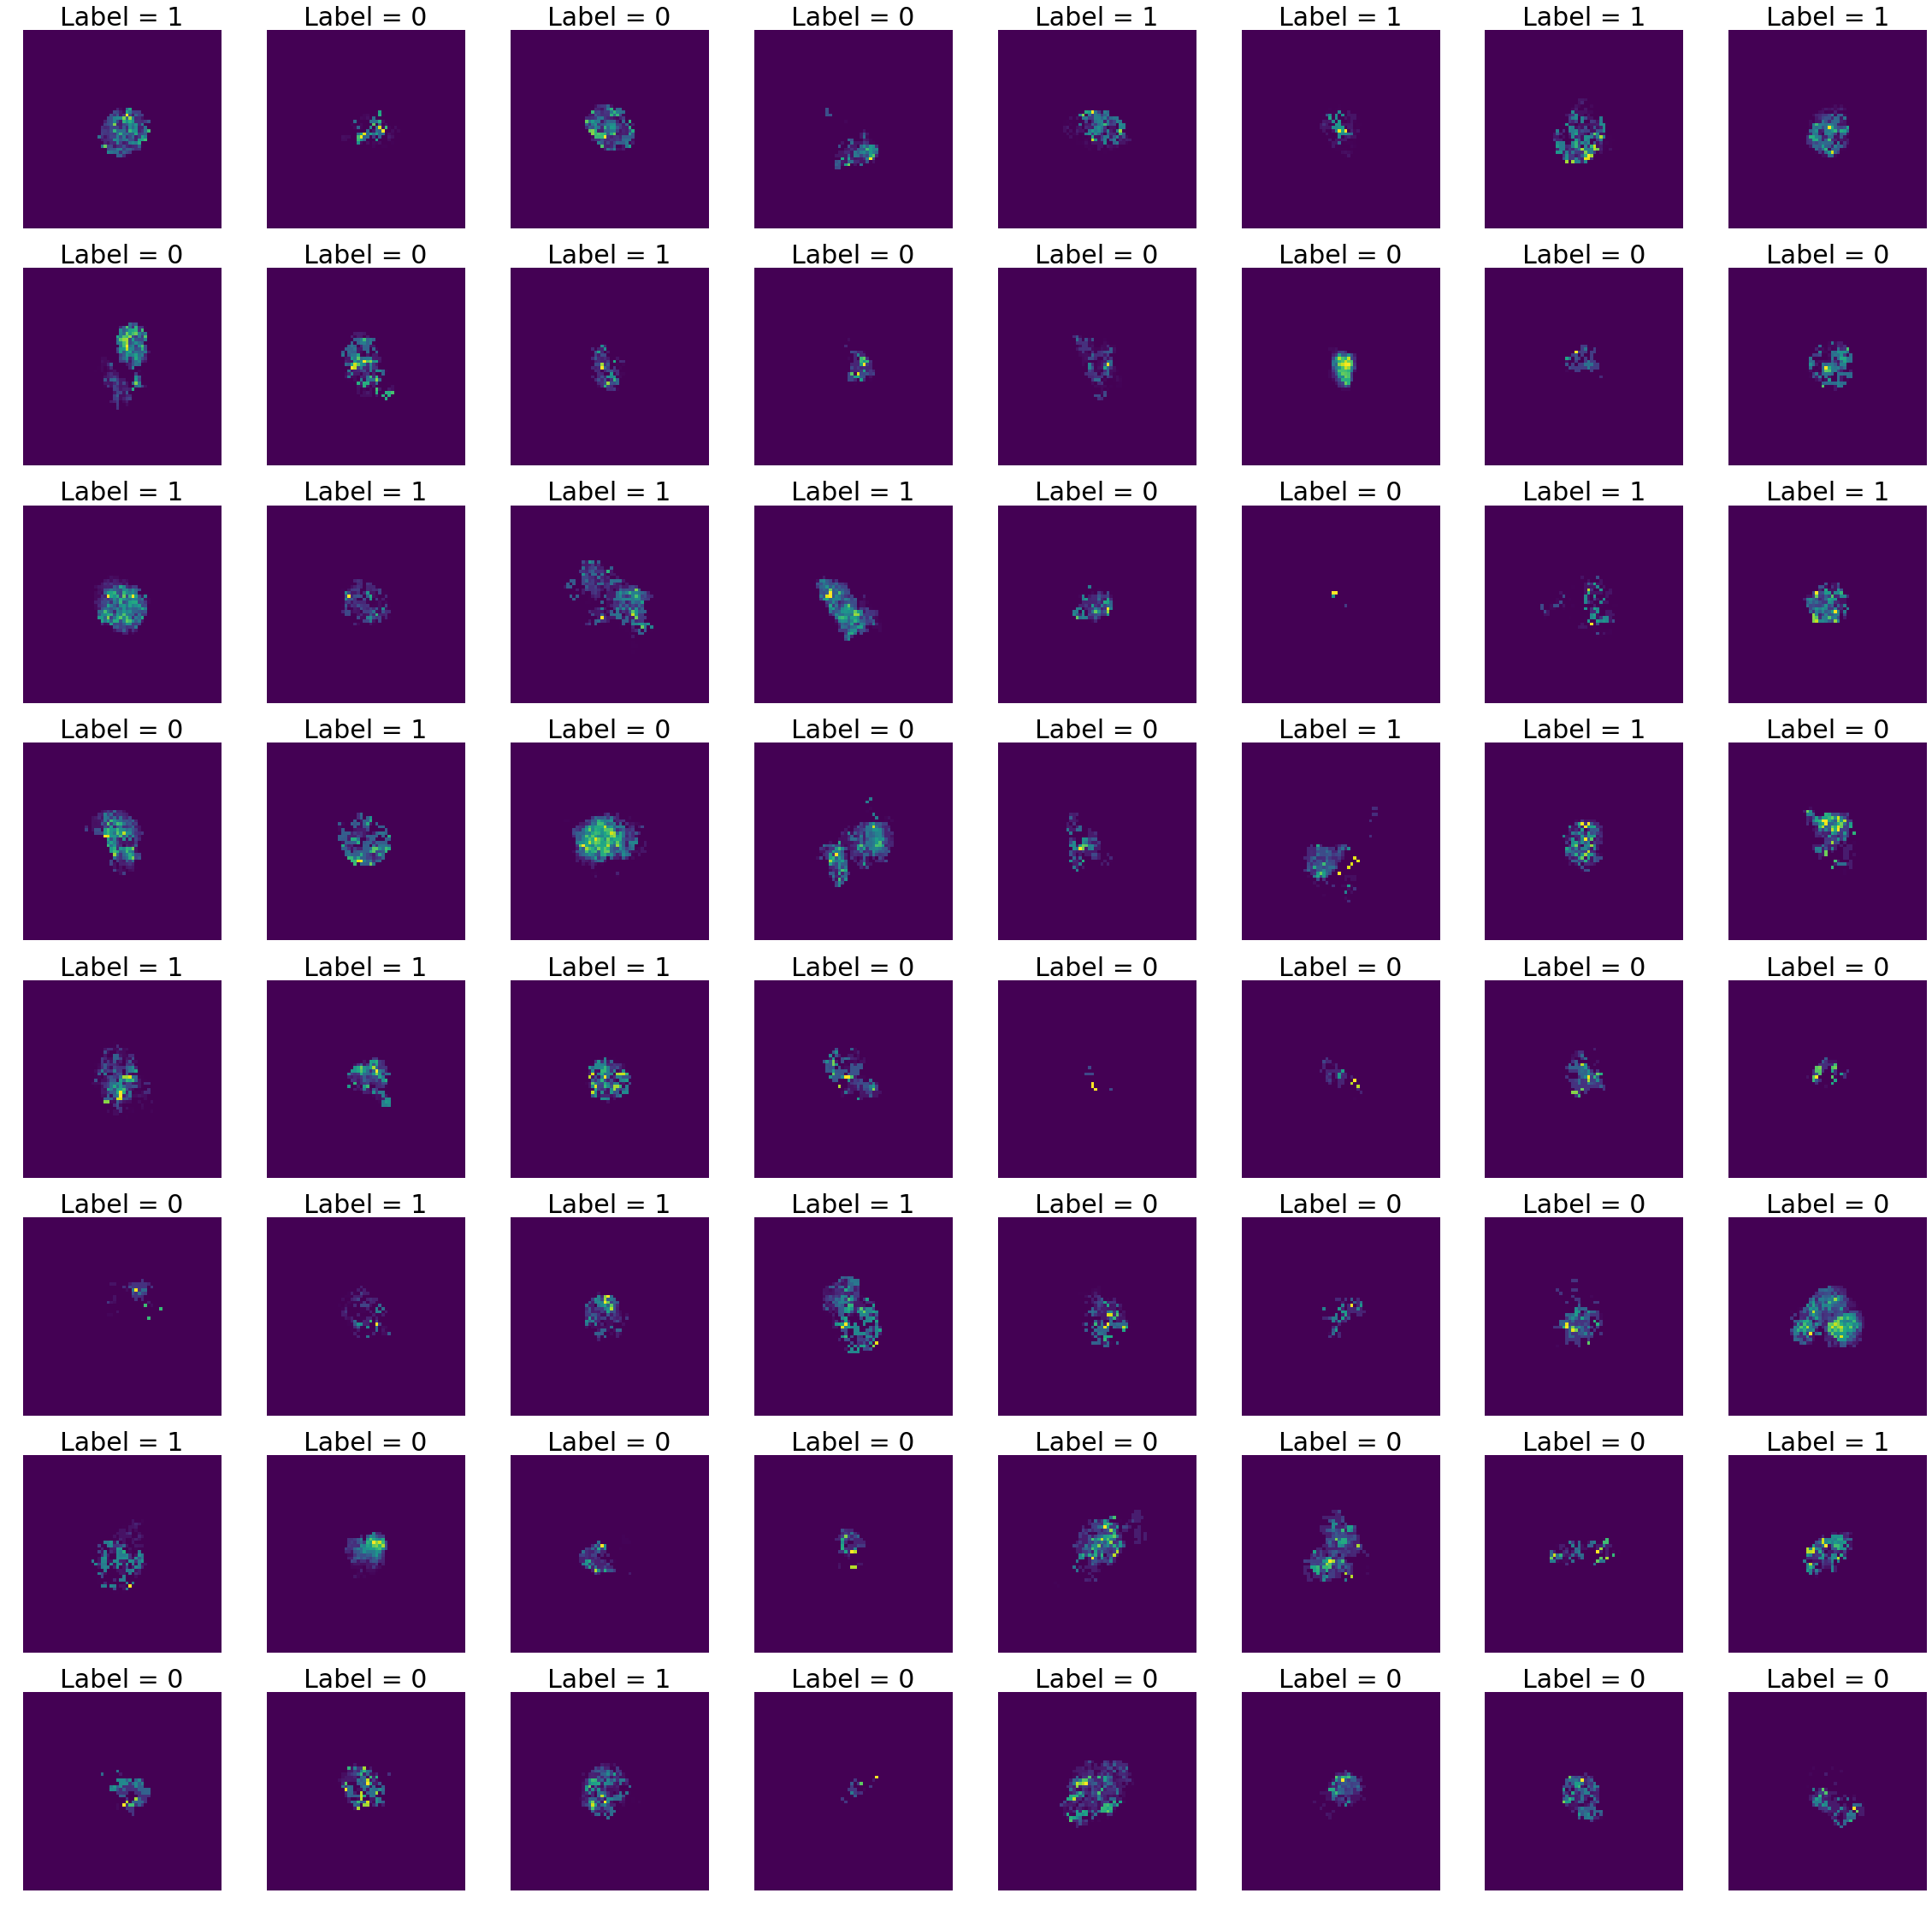

In [5]:
#Train the network
main(config, None)

skipped file: config.json


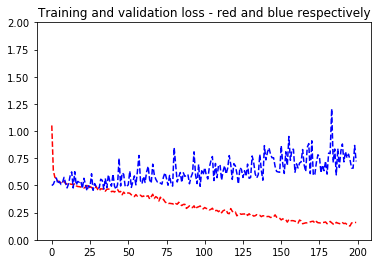

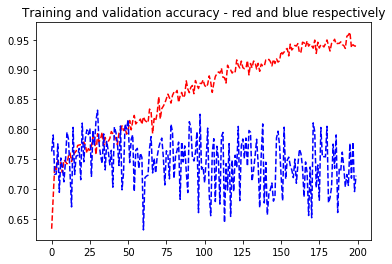

done


In [6]:
saved_dir = 'saved/GroundTruth_smallDataset/0618_201333'
config_saved_filename = os.path.join(saved_dir, "config.json")
#os.system('tensorboard --logdir ' + log_dir) cannot use with google VM without paying $$$
viewTraining.graphLoss(saved_dir, best=False) #imported from utils

print('done')

In [12]:
def main2(config, resume):
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader_test', config)
    '''
    
    data_loader = getattr(module_data, config['data_loader']['type'])(
        config['data_loader']['args']['data_dir'],
        batch_size=1,
        shuffle=False,
        validation_split=0.0,
        training=False,
        num_workers=2
    )
    '''
    # build model architecture
    model = get_instance(module_arch, 'arch', config)
    print(model)
    print(torch.cuda.get_device_name(0))
    normalized = False

    
    # get function handles of loss and metrics
    loss_fn = getattr(module_loss, config['loss'])
    criterion = loss_fn(None)
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    # load state dict
    checkpoint = torch.load(resume)
    state_dict = checkpoint['state_dict'] #dictionary of model parameters from saved file
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(state_dict) 
    
    # prepare model for testing
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval() #tells model to ignore dropout and batch normalization
    
    total_loss = 0.0
    total_metrics = torch.zeros(len(metric_fns))
    
    classes = ('endothelium', 'pct')
    all_pred = []
    all_true = []
    hm_layers = {'final_layer': 'layer', 'fc_layer': 'fc_layer', 'conv_num': 17, 'fc_num': 3}
    
    heatmapper = classActivationMap.CAMgenerator(hm_layers, config, model)
    heatmapper.generateImage(num_images=10)
    
    with torch.no_grad(): #speed up calculations, unable to perform back propogation
        for i, (data, target) in enumerate(tqdm(data_loader)): #tqdm is a progress bar
            data, target = data.to(device), target.to(device)
            output = model(data)
            image = np.squeeze(data[0].cpu().data.numpy())
            all_true.extend(target.cpu().data.numpy())
            all_pred.extend(np.argmax(output.cpu().data.numpy(), axis=1))
            
            #
            # save sample images, or do something with output here
            #
            
            
            if i < 5:
                util.visualizationOutGray(data, output, target, classes, normalized)
                
                
                
            # computing loss, metrics on test set
            loss = criterion(output, target)
            batch_size = data.shape[0]
            total_loss += loss.item() * batch_size
            if output.is_cuda: output = output.cpu()
            if target.is_cuda: target = target.cpu()
            
            for i, metric in enumerate(metric_fns):
                total_metrics[i] += metric(output, target) * batch_size
        
        #plt.show()
        
    
    n_samples = len(data_loader.sampler)
    print("num test images = " + str(n_samples))
    log = {'loss': total_loss / n_samples}
    log.update({met.__name__: total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
    for key in log:
        print("{} = {:.4f}".format(key, log[key]))
    #print(log)
    log['classes'] = classes
    log['test_targets'] = all_true
    log['test_predictions'] = all_pred
    print("My_metric is accuracy")
    util.plot_confusion_matrix(all_true, all_pred, classes=classes, normalize=False) 
    


In [13]:
#saved_dir = "saved/GroundTruth_cellData/0529_191042/"
resume = os.path.join(saved_dir, "model_best.pth")

print(os.path.isdir(saved_dir))
print(os.path.exists(resume))

#config = torch.load(saved_dir + "config.json")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

True
True


heatmapModel64(
  (layer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), paddi

/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


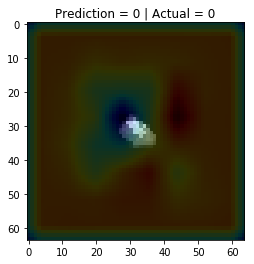

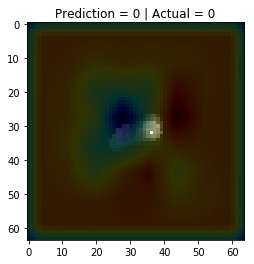

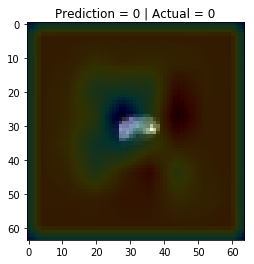

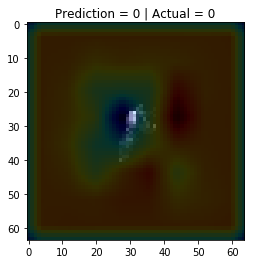

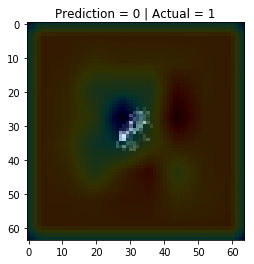

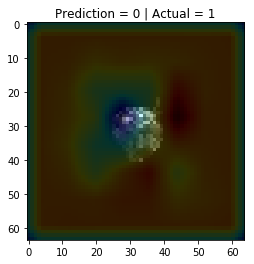

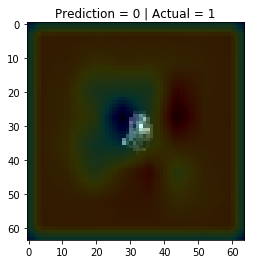

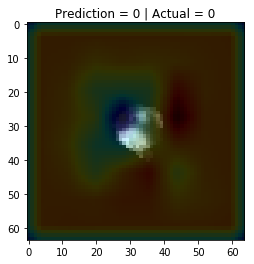

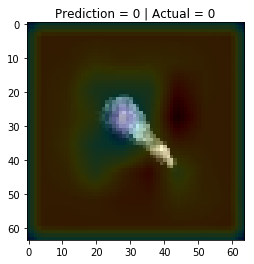

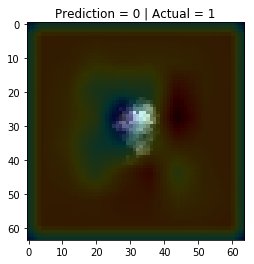

  0%|          | 0/3 [00:00<?, ?it/s]

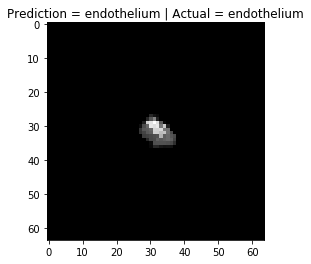

 33%|███▎      | 1/3 [00:00<00:00,  2.55it/s]

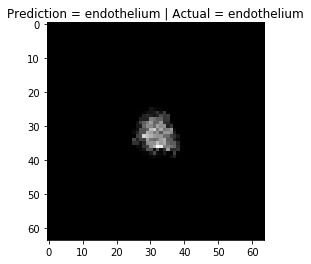

 67%|██████▋   | 2/3 [00:00<00:00,  2.85it/s]

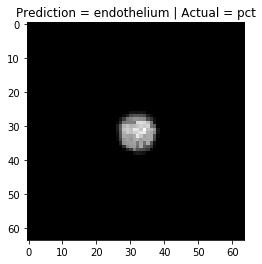

100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


num test images = 89
loss = 0.5946
my_metric = 0.7303
f1 = 0.6172
balanced_accuracy = 0.5000
precision = 0.5351
recall = 0.7303
My_metric is accuracy
Confusion matrix, without normalization
[[65  0]
 [24  0]]


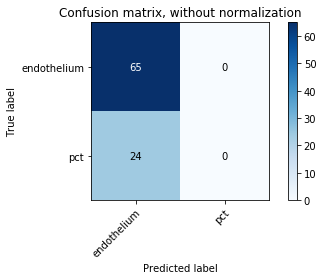

In [14]:
#Test
main2(config, resume)